# Reference: 
https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=x0WeP5PREUuy

In [ ]:
!pip install transformers==4.0.0

## Dataset Preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import seaborn as sns

import torch
import random
import time
import datetime
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('/data-disk/rap/cleaned_lyrics.csv', sep=',', names=['artist', 'lyrics'])
df.dropna(inplace=True) #remove NA values

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, gpt2_type="gpt2", max_length=768):

    self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>', sep_token='<LYR>') #gpt2-medium
    self.input_ids = []
    self.attn_masks = []

    bos_token = '<|startoftext|>'
    lyr_token = '<LYR>'
    eos_token = '<|endoftext|>'
    for artist, lyric in txt_list:
      #encodings_dict = self.tokenizer(bos_token + ' ' + artist + ' ' + lyr_token + ' ' + lyric + ' ' + eos_token, truncation=True, max_length=max_length, padding="max_length")
      encodings_dict = self.tokenizer(bos_token + ' ' + lyric + ' ' + eos_token, truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = GPT2Dataset(zip(df['artist'].tolist(), df['lyrics'].tolist()), max_length=768)

# Split into training, validation, and test sets
train_full_size = int(0.9 * len(dataset))
train_size = int(7/9 * train_full_size)
val_size = train_full_size - train_size
test_size = len(dataset) - train_full_size

train_full_dataset, test_dataset = random_split(dataset, [train_full_size, test_size])
train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


15,638 training samples
4,468 validation samples
2,235 test samples


In [ ]:
# Create the DataLoaders for our training, validation, and test datasets.
batch_size = 2
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The test samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Fine-Tuning

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because we added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(dataset.tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
epochs = 5
learning_rate = 5e-5
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()
            input_context = "<|startoftext|> Look who's back"
            input_ids = dataset.tokenizer(input_context, return_tensors="pt").input_ids
            input_ids = input_ids.to(device)
            sample_outputs = model.generate(
                                    input_ids=input_ids,
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, dataset.tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  7,819. Loss: 1.015673279762268.   Elapsed: 0:00:50.
0:  Look who's back Look who's back


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  7,819. Loss: 3.4931137561798096.   Elapsed: 0:01:41.
0:  Look who's back from where we are Look who's coming back from where we are Looking where we are Looking where we are Looking where we are Looking where we are Looking where we are Looking where we are Looking where I know I know he knows I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look I'm going to look


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  7,819. Loss: 1.6322450637817383.   Elapsed: 0:02:34.
0:  Look who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know who's back! You know


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  7,819. Loss: 1.8720594644546509.   Elapsed: 0:03:26.
0:  Look who's back that's back I can't say no no I can't say no I can't say no he could say no he could say no they could say no he could say no he could say no he could say no he could say no he could say no they could say no he could say no he could say no he could say no she could say no she could say no she could say no he could say no she could say no he could say no she could say no he could say no he could say no she could say no he could say no she could say no he could say no he could say no she could say no he could say no she could say no he could say no she could say no he could say no she could say no she could say no he could say no he could say no he could say no he could say no she could say no he could say no he could say no he could say no he could say no she could say no


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  7,819. Loss: 3.5390541553497314.   Elapsed: 0:04:20.
0:  Look who's back where I came here I'm coming back again Let's see kid Look what's happened I'm coming back again Let's see the kid I'm coming back again Let's see the kid Let's see the kid Let's see the kid Let's see the kid Let's see the kid Let's see the kid I'm coming back again Let's see the kid Let's see the kid Let's see the kid Let's see the kid I'm coming back again Let's see the kid Let's see the kid Let's see the kid Let's see the kid Let's see the kid let's see the kid let's see the kid let's see the kid Let's see the kid Let's see the kid Let's see the kid Let's see the kid Let's see the kid Let's see the kid Let's see the kid Let's see the kid let's see the kid let's see the kid Let's see the kid let's see the kid Let's


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  7,819. Loss: 3.739652395248413.   Elapsed: 0:05:14.
0:  Look who's back in school How about we Yeah how about we kid's back in school How about we kid's back in school How about we kid's back in school You can stop that kid's head in the school All right in the world Yeah all right in the world No wonder that's not what you meant Baby no boy ain't got a problem baby no boy ain't got a problem Baby no girl ain't got a problem Baby no girl ain't got a problem What a shame baby no boy ain't got a problem baby no boy ain't got a problem Baby no girl ain't got a problem Baby no girl ain't got a problem baby No boy ain't got a problem baby no girl ain't got a problem Baby no girl ain't got a problem Baby no girl ain't got a problem What a shame baby no boy ain't got a problem Baby no girl ain't got a problem Baby no girl ain't got a problem Baby no girl ain't got a problem Baby


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  7,819. Loss: 2.551610231399536.   Elapsed: 0:06:08.
0:  Look who's back here Look who's back here Look who's back here Look who's back here Look who's back here Look who's back here Look who's back here Look who's back here Look who's back here Look Who's back here Look Who's back here Look Who's back here Look Who's back here Look Who's back here Look who's back here Look Who's back here Look Who's back here Look who's back here Look Who's back here Look Who's back here Look who's back here Look Who's back here Look who's back here Look Who's back here Look who's back here Look Who's back here Look who's back here Look Who's back here


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  7,819. Loss: 3.173863410949707.   Elapsed: 0:07:01.
0:  Look who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  7,819. Loss: 3.1592233180999756.   Elapsed: 0:07:55.
0:  Look who's back Here's where you started When we got you Back and forth And where you start I ain't so much of a question How come we got you There were so many people who looked up in the window So many places You don't know how we got You don't know when we got you Back and forth You don't know when we got you back And forth Well we tried And the best thing we've been through was the hardest day of our lives We tried so hard we could't keep it We tried so hard we could not keep it We tried so hard we couldn't keep it We tried so hard we could not keep it We tried so hard we couldn't keep it We tried so hard we couldn't keep it We tried so hard we couldn't keep it We tried so hard we couldn't keep it We tried so hard we couldn't keep it We tried so hard we couldn't keep it We tried so hard we couldn't keep it So when we get you Back


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  7,819. Loss: 2.9747986793518066.   Elapsed: 0:08:48.
0:  Look who's back again How long does this wait How many ways do the people who love me stay with me How long do the people who love me stay with me Who knows what you say No more no longer don't need to wait Wait no longer don't go there for a change Don't change if you still love me don't change if you still need to change Don't change if you still want to stay with me Don't change if you still want to stay with me Don't change if you still want to stay with me I'll wait until you're gone for a reason Don't change if you still want to stay with me Don't change if you still need to stay with me Don't change if you still need to stay with me I'll wait until you're gone for a reason Don't change if you still need to stay with me I'll wait until you're gone for a reason Don't change if you still need to stay with me I'll wait until you're gone


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  7,819. Loss: 2.432124376296997.   Elapsed: 0:09:42.
0:  Look who's back In my heart Who can't say hello to me If you're here to talk to me I'm here to help You know I can't believe I can say goodbye If you're here to talk to me I'm here to help You know I can't believe I can say goodbye If you're here to talk to me You know I can't believe I can say goodbye If you're here to talk to me You know I can't believe I can say goodbye If you're here to talk to me You know I can't believe I can say goodbye If you're here to talk to me You know I can't believe I can say goodbye If you're here to talk to me You know I can't believe I can say goodbye If you're here to talk to me You know I can't believe I can say goodbye If you're here to talk to me You know I can't believe I can say goodbye If you're here to talk to me You know I can't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  7,819. Loss: 3.625800848007202.   Elapsed: 0:10:36.
0:  Look who's back in there just for a Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million Look who's back in there just for a million The same people are trying to hold this for the same reason that they tried to hold this for the same reason that they tried to hold this for the same reason that they tried to hold this for the same reason that they tried to hold this for the same reason that they tried to hold this for


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  7,819. Loss: 2.56012225151062.   Elapsed: 0:11:31.
0:  Look who's back now Look who's back now Look who's back now Look who's back now Look who's back now Look who's back now See the scene in front of us right now It's a beautiful scene right here Everybody's ready to leave us Here we go Now we go now Now we go now Now we go Now we go now Now we go now Now we go Now we go now Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now we go Now


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  7,819. Loss: 2.2129063606262207.   Elapsed: 0:12:25.
0:  Look who's backin with me I want to feel the coldest and warmest My body cold and tender I'll fall in love with you I can't see it coming When I'm in the backseat like the driver My body chillin through I'm never tired When I'm in the backseat like the driver I'll never cry When I'm like that I'm the worst at crying I scream at the top of my lungs cause I'll lose everything I love for all eternity But we'll keep on together and I'll see you again You've been so lovely I love you so much for my children but never give up just cause I feel you want me to stay with you forever I don't care if your momma never see you baby so why don music just chillin out now and I'll try to help get you out of it So I've got to get your head and my hand I just gotta see what I got to do and where I'm going right now I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  7,819. Loss: 3.1742990016937256.   Elapsed: 0:13:19.
0:  Look who's back In here to get you better With this in mind I'm out here to find answers I'm trying not to be hurt When all I know is there you know There's so much you can do I'm just asking to take one more sip Of a dose now I'm just saying don't be afraid to try a different recipe Now I know how to make it with a different recipe So what I'm hoping is that something new comes out with me So let me know foodie's on my way It's the cold winter here in West Palm Beach What's going on right now I can't even speak But what I can say is this ain't never my cup of tea I'm sorry that this time last year But there's somethin' wrong with my nose Look how they're eating this nigga Look where I'm at Now look at my face I'm ready to die Now how could I lookin for a nigga I got no money But how could I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  7,819. Loss: 3.7520060539245605.   Elapsed: 0:14:12.
0:  Look who's back Looking at the money I'm getting This is when the money goes to pay my bills This is when the money goes to pay my bills I see money coming in It just ain't in your bank account I'm just paying for it now I'm just paying my bills so now's the time to be happy 'Cause money is real I don't care for the money I had just left 'Cause I know that's what the man wants to see in me 'Cause the money is real I'm just paying my bills so now's the time to be happy 'Cause money is real I don't care for the money I had just left 'Cause I know that's what the man wants to see in me 'Cause the money is real I'm just paying my bills so now's the time to be happy 'Cause money is real I don't care for the money I had just left 'Cause I know that's what the man wants to see in me 'Cause the money


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  7,819. Loss: 0.7207137942314148.   Elapsed: 0:15:06.
0:  Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's back in my room Look who's


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  7,819. Loss: 2.5393826961517334.   Elapsed: 0:16:01.
0:  Look who's back at my door with my guns And I ain't seen nobody who ain't got no money So you can look at my wallet and the rest of the shit that's in it You know what I was saying last time I sold the house And it's me and my gun And that's it I swear To God And if I do That Will Put The Man in jail And He's done that Now if ya know If ya gotta be with me then I'll let ya know Tell me if y'all think yo' All the money That goes to ya Cause the government is fuckin with this shit I keep gon be fuckin with ya And I'm fuckin right with y'all You know what's fuckin with this shit I keep gon be fuckin with ya And I'm fuckin right with y'all You know what's fuckin with this shit I keep gon be fuckin with ya And I'm fuckin right with y'all You know what's fuckin with this shit I keep gon be fuckin


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  7,819. Loss: 3.6340157985687256.   Elapsed: 0:16:55.
0:  Look who's back in charge of our city I don't care what you think We'll hit it harder than the next big guy's time Yeah we'll go down the road if you're strong But don't worry we'll get it right out of here we got the people we need You won't find us now we just gotta get it right we got the right people we need No one can stop us from pushing it I'll make it right yeah yeah yeah Yeah yeah I'm right behind you no one can stop us from pushing it I'll make it right yeah yeah yeah we gotta get it right yeah yeah yeah You won't find us now we just gotta get it right we got the right people we need And now we gotta get it right And now we gotta get it right And now we gotta get it right And now we gotta get it right And now we gotta get it right And now we gotta get it right And now we gotta get it right And now we gotta get it right And


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  7,819. Loss: 1.1718201637268066.   Elapsed: 0:17:49.
0:  Look who's back to back looking at it A couple of months back I thought she wanted a massage I thought she had my back She looked at me like a punk A couple months back I thought she wanted a massage I thought she had my back She looked at me like a punk A couple months back I thought she wanted a massage I thought she had my back She looked at me like a punk A couple months back I thought she wanted a massage I thought she had my back She looked at me like a punk A couple months back I thought she wanted a massage I thought she had my back She looked at me like a punk A couple months back I thought she wanted a massage I thought she had my back She looked at me like a punk A couple months back I thought she wanted a massage I thought she had my back She looked at me like a punk A couple months back I thought she wanted a massage I thought she had my back She looked at me like a punk A couple months back I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  7,819. Loss: 4.3148040771484375.   Elapsed: 0:18:42.
0:  Look who's back with her My best friend who's in danger My best friend who's in danger Get out of the truck and go home Hey girl I'm hurt she's gone outta sight Now I'm sick and tired of all that hurting You can't deny me but you can't deny me I'ma leave You can't deny me but you can't deny me I'ma leave Ohhhhhh you must be feeling bad baby I'm scared you're not gonna love her and she'd rather be with me I'm gonna be there for her I'mma say you know I know what you're thinking so tell me I'mma let you go But don't think this would make a whole bunch of people want to fuck her You shoulda been shot to death or something you know I know your ass is hurting cause the shit is coming I don't feel safe with her I don't feel safe with her I don't feel safe with her I don't feel safe with her I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  7,819. Loss: 4.127184867858887.   Elapsed: 0:19:36.
0:  Look who's back with me Look Who's back with me Look Who's back with me Come on Baby you want a ride See you look good Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Come on baby you want a ride Look Who's back with me Look Who's back with me Look Who's back with me Come on Baby you want a ride Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Come on Baby you want a ride Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with me Look Who's back with


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  7,819. Loss: 1.557353138923645.   Elapsed: 0:20:29.
0:  Look who's back with you baby Look look up at that sexy chick Look me in the mirror Baby look me out look up at that sexy chick Look up at that sexy chick Look up at that sexy chick Look up at that sexy chick Look up at that sexy chick Look up at that sexy chick Look up at that sexy chick Look up at that sexy chick Look up at that sexy chick Look up at that sexy chick Look up at that sexy chick Look up at that sexy chick You look like a porn star Get the fuck outta here Look up at that sexy girl You look like a porn star Get the fuck out fuck I'm from Michigan Look up at that sexy girl You look like a porn star Get the fuck outta here Get the fuck out of the house Look up at that sexy girl We talk about everything You look like a porn star Make the girl look back at you and talk about her Make the girl look back at you and talk about her Make the girl look back at you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  7,819. Loss: 2.7332277297973633.   Elapsed: 0:21:24.
0:  Look who's back down back down back down back down down back down back down back down back down Back down down back down back down Back down back down back down Back down back down Back down back down Back down back down Back down back down Back down back down Back down back down Back down back down Back down back down Back down back down Back down back down back down Back down back down back down Back down back down back down back down Back down back down back down Back down back down back down Back down back down back down Back down back down back down Back down back down back down Back down back down Back down back down Back down back down Back down back down back down Back down back down back down Back down back down Back down back down back down Back down back down Back down back down Back down back down Back down back down Back down back down Back down back down Back down back down back down Back down bac

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  7,819. Loss: 3.460646867752075.   Elapsed: 0:22:17.
0:  Look who's back There is always a way to lose this game It's just me And my nigga back I'm back But there's no mercy out there There ain't no mercy out there I know that It's just me And my nigga back I'm back But there's no mercy out there I know that It's just me And my nigga back And my nigga back Oh my God I am so thankful for what we've done for the past 4 years I've seen how bad it can be When the world is good and the kids are better than we used to It's just me And my nigga back Yeah I got a message For you the one that I got And your one that I got Yeah I got a message For you the one that I got And your one that I got Yeah I got a message For you the one that I got And your one that I got Yeah I got a message For you the one that I got And your one that I got Yeah


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  7,819. Loss: 3.4128363132476807.   Elapsed: 0:23:11.
0:  Look who's back in my shoes Who's not back in my shoes And who's not back in my shoes In your clothes Who's back in my shoes And who's not back in my shoes In your clothes I ain't broke I ain't broke Don't cry in my shoes I ain't broke I ain't broke I ain't broke I ain't broke I ain't broke I ain't broke I ain't broke I ain't broke I ain't broke I ain't broke I ain't broke I ain't broken I ain't broke I ain't broke I ain't broken I ain't broken I ain't broken I ain't broken I ain't broken I ain't broken I ain't broken I ain't broken I ain't broken I ain't broke I ain't broke I ain't broken I ain't broken I ain't broken 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  7,819. Loss: 2.8071601390838623.   Elapsed: 0:24:03.
0:  Look who's back look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back See all this crap that's coming down like we ain't seen anything like this before See all this shit that's coming down like we ain't seen anything like this before See all this shit that's coming down like we ain't seen anything like this Before We All Rise  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  7,819. Loss: 2.1920392513275146.   Elapsed: 0:24:57.
0:  Look who's back for ya Yeah man That's what I was hoping for You had me and I thought you and I were the same But it's all right now You didn't think I could do it But let me tell you about it and I ain't had no time to think about it but if I did I would have done it I wouldn't know how you do it And I told you you I didn't know who you think you were and I ain't had no time to think about it but if I did I would have done it I wouldn't know how you do it And I told you you I was wrong and I wasn't right But don't worry you'll have you got a bigger shot I can't tell no more Now let me take this one out I'm really just a kid You don't make a problem of me don't want to be left alone But if you did and it was okay then I ain't never tried to hide it I'm never tryna


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  7,819. Loss: 3.5451016426086426.   Elapsed: 0:25:51.
0:  Look who's back out here And who's looking on our shoulder And you like who you are You're not doing the work that I'm saying No way it can happen I feel like a fool and I'm sorry I came from nowhere and I'm sorry you're looking to rob us You're not doing the work that I'm saying I can't believe it's you The way that we look and the way that you act Is nothin that we can do without you And don't worry it's not that bad And just don't make the mistake I made And if you think that you can't do what I try to do it just doesn't work I love you and hope it is only because of you and I make it better than before I've done it just makes me wonder who it really is It's too late to try again So don't think that I need to go for the money I have and make it up to you That is really not what I do for you I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  7,819. Loss: 2.5571367740631104.   Elapsed: 0:26:45.
0:  Look who's back with this shit I told you Look Who's back with this shit I told you And he ain't nothin' I told you Look Who's back with this shit I told you And he ain't gone but he ain't gone You got what ya gotta do Look Who's back with this shit I told you And he ain't gone but he ain't gone Yeah this shit it's so much trouble I'm sick and tired of doing these things You know that's the way you try to get your shit up See the way this shit ain't fuckin down I'm done getting my shit up Keep walking and walking through shit like I told you Yeah I'm gone with this shit I told you Look Who's back with this shit I told you Yeah 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  7,819. Loss: 2.512920618057251.   Elapsed: 0:27:38.
0:  Look who's back in the booth I still had you And you looked like a little child in my pants I was trying to save some money With your dick dangling like a needle to the head and the whole crew got up in your place but you were too busy staring at my crotch with the condom on and all that and I was just getting off my ass All that shit is just gravy and it tastes so good I swear I spit on your dick in the middle of my room And your semen was like a sunset for me I'd been there it's only a few days before And you said you'd never want it for me I told you you would never want it for me I told you I'd never want it for me You was trying to save your money that I had no interest in My dick still in your pants and I was just trying to save some money With your dick dangling like a needle to the head and the whole crew got up in your place but you were too busy staring


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  7,819. Loss: 4.419554710388184.   Elapsed: 0:28:31.
0:  Look who's back on that team You better get back on that team You better get you back on that team You better get you back on that team It's a game I like to be up all night long You'll be back soon enough I'm looking for a date and they have no answer I'm looking for a date but no answer I'm looking for a date I'm looking for a date but no answer They just want some help I know a good friend I'm looking for a date But they don't know how to get the fuck on I'm trying to be a good girl But I'm trying to be a good girl I'm looking for a date I'm looking for a date but no answer I'm looking for a date but no answer They just want some help I know a good friend I'm looking for a date But they don't know how to get the fuck on I'm trying to be a good girl But I'm trying to be a good girl I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  7,819. Loss: 2.0371217727661133.   Elapsed: 0:29:25.
0:  Look who's back Look who's back Look who's back Looking who's back Now who's back Look Who's back Look who's back Now who's back Look who's back Look who's back Come on look who's back Look who's back I just can't stop Let's see who's back Hey I know I'm the type to be so crazy But it's always in my control And I won't give in no more Let's see who's back I just can't stop Let's see who's back Let's see who's back I just can't stop Let's see who's back Look who's back It's back you it's time you get back So let's just remember that Who you really want on the dance floor Who you want on the dance floor You got it on when you got it on Who you really want on the dance floor Who you really want on the dance floor You got it on when you got it on Who you really want on the dance floor You


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  7,819. Loss: 2.170508861541748.   Elapsed: 0:30:19.
0:  Look who's back at me Look who's back at me What you gonna do you gonna be in the back room in the front room What you gonna do you gonna be in the front room Let's go and get the cake I wanna make it look bad Don't believe me let me get away I can't believe that I'm telling you lies And even when I don't have to take your love back Don't believe me I can't believe that you're on the other end of a trap Don't believe me I can't believe that you're on the other end of a trap Don't believe me I can't believe that you're on the other end of a trap Don't believe me I can't believe that you're on the other end of a trap What's up Don't believe me I can't believe that you're on the other end of a trap Don't believe me I can't believe that you're on the other end of a trap Don't believe me I can't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  7,819. Loss: 4.249749660491943.   Elapsed: 0:31:14.
0:  Look who's back I'm the guy to go after I'm the man to I'm the one to kill you and if you let me take you I'm going to make you look like me I'm the one to kill you And if you're taking you I'm going to make you look like me I'm the one to kill you And if you're taking you I'm going to make you look like me I'm the one to kill you And if you're taking you I'm going to make you look like me I'm the one to kill you And if you're taking you I'm going to make you look like me I'm the one to kill you and if you're taking you I'm going to make you look like me I'm the one to kill you And if you're taking you I'm going to make you look like me I'm the one to kill you And if you're taking you I'm going to make you look like me I'm the one to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  7,819. Loss: 1.18921959400177.   Elapsed: 0:32:08.
0:  Look who's back in the studio This is my first crew See how that's gonna look A few shots in the studio I'm outta here So don't leave me bein alone I'm just livin right now I'm still in the studio How you doing today do you know me I'm on some of the shows and I'm doing my own things But what's going on so tell me How it's going and where we're at and what do we do at The studio just got busy And I can't wait for you to start to take your turn I'm taking your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time out to take your time


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  7,819. Loss: 2.040187120437622.   Elapsed: 0:33:01.
0:  Look who's back again I'm back for ya And this is me And this is who I've been known to be and been known to be I'm back for ya I'm back for ya And I'm back for ya Yeah I'm back for ya I'm back for ya And I'm back for ya I'm back for ya I'm back for ya Yeah I'm back for ya I'm back for ya I'm back for ya And I'm back for ya Yeah I'm back for ya I'm back for ya Yeah I'm back for ya Yeah I'm back for ya I'm back for ya I'm back for ya Yeah I'm back for ya I'm back for ya I'm back for ya I'm back for ya I'm back for ya I'm back for ya yeah I'm back for ya yeah I'm back for ya I'm back for ya yeah I'm back for ya yeah I'm back for ya yeah I'm back for ya yeah I'm back for ya


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  7,819. Loss: 2.6343798637390137.   Elapsed: 0:33:54.
0:  Look who's back in my life I'm back in my life I'm back in my life I'm back in my life I'm back in my life I'm back in my life I'm back in my life It's my life I want to be back in your world I want to be back in your world I'm back in your life I'm back in your life I'm back in your life I'm back in my life It's my life I want to be back in your world I want to be back in your world I'm back in your life I'm back in your life I'm back in my life I'm back in my life I'm back in my life I'm back in my life It's my life I want to be back in your world I want to be back in your world I'm back in your life I'm back in your life I'm back in your life I'm back in my life I'm back in my life I'm back in my life


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  7,819. Loss: 1.652592658996582.   Elapsed: 0:34:47.
0:  Look who's back In the lab in the lab In the lab in the lab In the lab in the lab In the lab In the lab in the lab In the lab In the lab in the lab In the lab in the lab In the lab In the lab In the lab in the lab In the lab in the lab In the lab in the lab In the lab In the lab in the lab In the lab in the lab In the lab In the lab in the lab In the lab in the lab in the lab In the lab in the lab In the lab in the lab in the lab In the lab in the lab in the lab in the lab In the lab in the lab in the lab in the lab In the lab in the lab In the lab in the lab In the lab in the lab in the lab In the lab in the lab in the lab In the lab in the lab In the lab in the lab In the lab in the lab In the lab in the lab In the lab


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  7,819. Loss: 2.9981322288513184.   Elapsed: 0:35:40.
0:  Look who's back from France today I'm back from France today Look who's back from France today I'm back from France today Look who's back from France today I'm back from France today I'm back from France today Come on get that paper back look Who's back from France today Come on get that paper back look Who's back from France today Come on get that paper back Look Who's back from France today Come on get that paper back look Who's back from France today Come on get that paper back look Who's back from France today Come on get that paper back look Who's back from France today Come on get that paper back Come on get that paper back I'm back from Paris today I'm back from Paris today I'm back from Paris today I'm back from Paris today Come on get that paper back Come on get that paper back I'm back from Paris today I'm back from Paris today I'm back from Paris today I'm back from Paris today Come on get that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  7,819. Loss: 2.7088446617126465.   Elapsed: 0:36:33.
0:  Look who's back with the whole muthafuckin crew Come up in the club get the fuck outta here man And tell the crew who you trust to be real Don't know who's out with them all but they just say your name and they just give you the damn damn thing you just said Let me hit up a joint and a pair of pants They won't go no where that was never intended When I told them I'd be like a fuckin lawyer I was just looking for a lawyer but this man's got an ace So fuck that shit and fuck that bitches Who's my man Don't you wanna fuck with him who you trust I'm not your guy You'll have to get you in the kitchen to finish it When I leave you with a big dick and I can just make you say I hate you My crew I'll send you out in the street to play out the match You ain't getting no love in these dudes they can't even play em in the game


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  7,819. Loss: 3.943244695663452.   Elapsed: 0:37:25.
0:  Look who's back tonight and who's back tonight Well it's a very short time but you know that the club's on fire and you don't have to give it up Cause I know that we can play the game like it's the game of life That's a very long game of the game So we get stuck on the grind we get stuck on the grind So we get stuck on the grind I tell you what I know I'm just telling you what I'm just tell you what I'm just tell you what I just tell you what I just tell you what I just tell you what I just tell you what I just tell you what I just tell you what I just tell you What I just tell you whats up your mind for when you're lost Cause you never know when you're in trouble Cause you never know when you're in trouble Cause you never know when you're in trouble Cause you never know when you're in trouble Cause you never know when you're in trouble Cause you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  7,819. Loss: 4.887503147125244.   Elapsed: 0:38:18.
0:  Look who's back and looking like he has to quit this life And what am I supposed to do and how do I feel right now If he didn't die he couldn't change shit He gotta be with that bitch now The last thing you want is you to waste your time 'Cause the way you act is like this Is my problem that I can't live with Let me tell you what I really mean And tell you who that is I don't care if you know that's okay Or what I mean to tell you I don't care if you don't know That's okay But if you don't know that's okay So just keep on hating on him you are out of your mind The world is fucked I can't stay quiet if you need me to I'm here for you and I need you to be okay I can't see it I can't go and see you in the mirror but I need you with me You can't live and I can't live like that So just do


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  7,819. Loss: 1.5050140619277954.   Elapsed: 0:39:11.
0:  Look who's back with us and what's the deal Who can you make the big bucks look like who they said who they got You've been watching the show right this time You've been watching the show right this time You've been watching the show right this time You've been watching the show right this time You've been watching the show right this time You've been watching the show right this time You've been watching the show right this time You've been watching the show right this time You've been watching the show right this time Your own words are so confusing that you can't get it What's the difference between you and me What's the difference between you and me What's the difference between you and me What's the difference between you and me 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  7,819. Loss: 1.1150000095367432.   Elapsed: 0:40:04.
0:  Look who's backstabbing with my brother Bizzy and that niggas that was out there all day I was like yeah And a lot of us niggas got fucked up I was like I had some of you gettin shit on me I'm still fuckin wit it still fuckin with it Still fuckin with it still fuckin with it Now it ain't what I want I want it's a new way of life Just when it seemed like everything was alright I was like shit I would never do that again It ain't what I want I want it's a new way of life So it ain't what I want I want it's a new way of life I'ma see you on the block when I go to work I gotta give em everything So make sure you come with your own shit if your in it So it ain't what I want I want it's a new way of life 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  7,819. Loss: 4.080363750457764.   Elapsed: 0:40:58.
0:  Look who's back on it who the hell is it What's happening with this man who's back on it I'm about to put down a hammer in your face Why you're hurting so I put down a hammer in your face If this ain't a deal you ain't gonna get it It's my duty to pay your dues It's not a war to lose the land but to fight And I'll come out and save you My only hope is to kill you And if I do then you can find peace My only hope is to save you And if I do then you can find peace My only hope is to save you And if I do then you can find peace My only hope is to save you And if I do then you can find peace My only hope is to save you And if I do then you can find peace My only hope is to save you And if I do then you can find peace And if I do then you can find peace And if I do then you can


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  7,819. Loss: 4.247427940368652.   Elapsed: 0:41:53.
0:  Look who's back to play Call me Sibyl I will destroy you to pieces I will give you a new vision Call me Dusso Dusso Dusso dusso This game is a game of dice Roll and we'll be rolling dice Dusso Dusso dusso Get down to the business of a player Just be the boss of a player Just be the boss of a player Just be the boss of a player Just be the boss of a player Just be the boss of a player Just be the boss of a player Just be the boss of a player Let's go we can go we can go We can go We can go we can go We can go We can go we can go Let's go we can go we can go We can go we can go Let's go we can go we can go We can go we can go We can go We can go we can go Let's go we can go we can go We can go we can


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  7,819. Loss: 3.9338295459747314.   Elapsed: 0:42:46.
0:  Look who's back in town and look out my window I wanna see you when you're gone Now don't worry I'm in no rush I'm just feeling like I ain't even home at all  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  7,819. Loss: 2.1565091609954834.   Elapsed: 0:43:37.
0:  Look who's back Looking for trouble in that shady place How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old way I run around like a fool How you feel in the dark The old


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  7,819. Loss: 1.8488421440124512.   Elapsed: 0:44:31.
0:  Look who's backin up there Don't even know where you at I'll see you in the club tonight If I had a problem I would say uh uh Uh uh I guess we're talking bout our next session And this time we're backin up in the club 'cause we both need a little more time So if you're here tonight make sure that you know my name and I'll be there just to let you know That I'm here and I'm with ya I'm out there and I'm a little extra and you don't wanna see me that way I said I'll let you know it's a good time 'Cause uh uh uh uh Uh uh I guess we're talking bout our next session And this time we're backin up in the club 'cause we both need a little more time So if you're here tonight make sure that you know my name and I'll be there just to let you know that I'm here and I'm a little extra and you don


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  7,819. Loss: 2.0959911346435547.   Elapsed: 0:45:25.
0:  Look who's back now let's face it 'Cause we're a young crew from Atlanta who got the guts to stand up to the law We've been through hell all of our lives But when your brothers is shot through a piece And after the funeral what do they do in the back of your mind When all of your brothers see you still living I'll get it But I don't want to see you gone I don't want to see you just died I need you I don't want to hear how I'm supposed to get this thing out And all I'm trying to do is talk You're still my life I'm here to see you But it's too late I don't know if you're ready now I'm just trying to give you a chance to be strong But it's too late I don't know if you're ready now I'm just trying to give you a chance to be strong But it's too late I don't know if you're ready now I'm just trying


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  7,819. Loss: 3.282369375228882.   Elapsed: 0:46:20.
0:  Look who's back from the past that came before we met you The guy that made all the money for us in his youth that made you famous The man who made us forget him Now we gotta remember the words and do our best to stay together to get this thing on So here we go get this piece of the pie I'm not getting paid for my song but you better listen to my tape I got you ready in the truck on top of the dirt like a car crash So it's time to go slow and let's say good bye And we started up on Monday morning and it didn't matter where our meals were It just wasn't about us all in the morning But you're too special to me the way we make you feel I got so many things to do and you deserve it and we got you ready with every step We're on the same page I'm here to say good bye and don't forget us So listen here I got all you need to know If we go out


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  7,819. Loss: 3.8613197803497314.   Elapsed: 0:47:13.
0:  Look who's back who's gonna catch me Now I ain't sayin he no longer wanna die We gotta stay together we gotta keep this one in the back Stay together we gotta keep this one in the back Stay together stay together keep the one in the back Stay together stay together keep the one in the back Stay together we gotta keep this one in the back Stay together stay together keep the one in the back Stay together keep the one in the back Stay together stay together keep the one in the back Stay together keep the one in the back Stay together keep the one in the back Stay together stay together stay together Stay together stay together Stay together stay together Stay together stay together Keep together Stay together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Together Stay Togeth

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  7,819. Loss: 2.564070701599121.   Elapsed: 0:48:07.
0:  Look who's back on that mic Look Who's back on that mic Look who's back on that mic Look Who's back on that mic Look Who's back on that mic Look Who's back on that mic Yeah what up to that Yeah what up to that Yeah what up to that Yeah what up to that I thought you knew how to rhyme with your tongue So I thought I told you some of this shit Now everybody know what this shit is About to begin with So what's up  It's gonna take awhile I know this shit is going slow But I gotta admit though I been having nightmares I think of the words I was talking to You've been dreaming all day You got this girl on the phone with you She been making plans for me She's asking me to tell you the reason I can't sleep and I can't sleep so She's taking you to the bathroom while she talks to you Yeah I see your girl texting with you But it ain't the same thing I mean what


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  7,819. Loss: 2.072760820388794.   Elapsed: 0:49:00.
0:  Look who's back there It's Gotti What's up With You And That's what she said And I just came And I'm ready to get started And I got a whole brand new body And I'm just like You So I got a new body And I'm just like You So I got a whole brand new body And I'm just like You I got a new body I'm just like You So I got a new body and I'm just like You So I got a new body And I'm just like You So I got a new body And I'm just like You So I got a new body I'm just like You So I got a new body And I'm just like You So I got a new body and I'm just like You So I got a new body And I'm just like You So I got a new body So I got a whole brand new body And I'm just like You So I got a new body and I'm just like You So I got


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  7,819. Loss: 2.9736852645874023.   Elapsed: 0:49:54.
0:  Look who's back here You can take this all to the bank and take all this back to the bank Come take this all to the bank Bring it all out and I will show you all your wealth If you look at the stars and the moon come look at the stars and the moon Come come look at the stars and the moon Come and come Come and Come to me You will be found in this land and you can be found in this land My name is L A G I I can't believe I'm back on a mission like this Why you want me to go on a mission like this Why you want me to go on a mission like this Why you want me to go on a mission like this Why you want me to go on a mission like this I'll tell you what the future holds I'll tell you what the future holds I'm your man I'm going to ride you through this land and I will ride you through this land Come on man take this home you're so beautiful


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  7,819. Loss: 3.810624837875366.   Elapsed: 0:50:48.
0:  Look who's back like I said you'd like to get your money I'll come up a hundred bucks and then I'll go and put my shit in your ear Yeah that's right if you want to fuck with me fuck with me The only thing to do is go kill somebody with some dick I can tell you about them fucking bitches but I can tell you that this is nothing like hell That's right what is that That's right do you want to fuck with me fuck with me I can tell you that this is something you really hate so I can tell you that this is something you really hate so I can tell you that this is something you really hate So I'll fuck this bitch who you like like I'll fuck this bitch who you like You know what I'm talkin bout Don't you be scared I'll do what's right you know what I'm talkin bout Aint nobody talkin no shit They ain't talkin no shit I'm talkin to you all


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  7,819. Loss: 3.142277717590332.   Elapsed: 0:51:43.
0:  Look who's back Who's next Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Whooooo Who's back Who's back Who's back Who's back Who's back Whooooo Whooooo Whooooo Who's back Whooooo Who's back Who's back Whooooo Who's back Who's back Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Who's back Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo Whooooo


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  7,819. Loss: 3.098527193069458.   Elapsed: 0:52:36.
0:  Look who's back in the game With the new new look look like it really shouldn't be this big So when I see a new song that's a little different now That's when I started looking for it I found it I'm so glad that the songs are here to stay with me I can tell you that when I do this I get a little bigger I really love that I can sing this song But I can sing this song because I can sing it from inside it 'Cause I can sing my song to you as long as you know this song is for you I love that I can sing this song like it really shouldn't be this big So when I see a new song that's a little different now That's when I started looking for it I found it I'm so glad that the songs are here to stay with me I can tell you that when I do this I get a little bigger I really love that I can sing this song But I can sing this song because I can


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  7,819. Loss: 2.301307439804077.   Elapsed: 0:53:29.
0:  Look who's back now Look who's in the booth here Look Who's in the booth here Now now if you in the booth and you don't see me there's going to be someone that I haven't seen since I was in school Look who's that girl huh Yeah she is She got her hair on a pony pony she got her hair on a pony She got her hair on a pony pony She got her hair on a pony pony she got her hair on a pony She got her hair on a pony pony pony She got her hair on a pony pony pony She got her hair on a pony pony She got her hair on a pony pony pony She got her hair on a pony pony She got her hair on a pony pony She got her hair on a pony pony She got her hair on a pony pony She got her hair on a pony pony She got her hair on a pony pony You got your hair on a pony pony She got her hair on a pony pony She got her hair on


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  7,819. Loss: 2.956908941268921.   Elapsed: 0:54:22.
0:  Look who's back who's here Who's back Who's here Who's there Who's there Who's there Who's there Who's here Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there Who's there What's there who's there Who's there Who's there Who's there Who's there


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  7,819. Loss: 1.7897454500198364.   Elapsed: 0:55:16.
0:  Look who's back with that song Let's go fuck your head up I ain't gon keep that ass on the floor I been looking for this since the day I turned 15 A long time ago there's no one around me like me I remember first coming to class and sitting here on my bed in class I thought I'd never do the same thing again But what a shame to feel like I was so young when I got there I thought the world would end I was so young when I got there and I thought I'd never do the same thing again But what a shame to feel like I was so young when I got there And I guess they were so good they had me thinking I was grown And it was so nice that we did the same things And the world would end I thought they were so good they had me thinking I was grown And it was so nice to see that they were so good that we did the same things And the world would end  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  7,819. Loss: 3.619523525238037.   Elapsed: 0:56:11.
0:  Look who's back in town Look Who's back in town Look Who's back in town Look who's back in town Who's back in town Look Who's back in town Look who's back in town Look Who's back in town Look Who's back in town Look who's back in town Look who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who's back in town Look Who


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  7,819. Loss: 2.4262611865997314.   Elapsed: 0:57:05.
0:  Look who's back with the first two clips to the start And this one for the real people who ain't gonna play no games See what I'm saying Now if you're a real person with the first two clips To the start then you musta seen this before And this one for the real people who ain't gonna play no games See what I'm saying I'll tell you one and three time So that you can know exactly what's happenin' Well then you gotta be on your guard and put your money where your mouth is And when it comes to the real people who ain't gonna play no games See what I'm saying We don't play no games no games You just be on your guard and put your money where your mouth is Let's be real and do it right And in the end this is what I'm gonna say I'm a big deal And if you're real don't listen to em I'mma do you your share and keep the game for the real people Who


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  7,819. Loss: 3.0408389568328857.   Elapsed: 0:57:58.
0:  Look who's back Look who's outta here Look who's outta here Look who's in the door Look who's in the hallway Look who's outta here This is like a fight here that's like a fight here that's like a fight back I'm in the zone I'm in the zone My hand is on the trigger I'm off my back this is like a fight here I don't wanna fight and get down for my life I don't wanna fight and get down for my life I want to see the real world I know that you know this is my nightmare My heart is cold here and I'm still alive it feels like my soul is gone I'm still here and I want to be and go where the hell you want to be What I got to do is come back to me I'mma be here and go where the hell you want to be What I got to do is Come back to me I'mma be here and go where the hell you want to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  7,819. Loss: 1.0239804983139038.   Elapsed: 0:58:51.
0:  Look who's back in the booth huh No more niggas on my dick Got me in the house of a nigga and he wanna pull me out But I'mma pull my dick out with a big ass clip And he'll be the one to fuck With I'mma be the guy you know the shit you heard But it'll be your friends who know the shit you heard Fuck with my bitch and you know how he act And you know the shit you heard Bitch and I got beef with the man at the bar When we hit the club we get shit like mums fuck on mums They'll make you scream Like I'm a pussy sucker Nigga you know what they mean when we're slippin in the club Nigga you know what they mean When we hit the club we get shit like mums fuck on mums They'll make you scream Like I'm a pussy sucker Nigga you know what they mean When we hit the club we get shit like mums


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  7,819. Loss: 2.523165464401245.   Elapsed: 0:59:44.
0:  Look who's back with these hoes in the streets With my money with my gun I see these niggas walk around with all that money with a shovel I keep my pistol with my Glock on my mami man She got all these hoes so deep inside on their knees Look who's back with these hoes in the streets With my money with my gun I see these niggas walk around with all that money with a shovel I keep my pistol with my Glock on my mami man She got all these hoes so deep inside on their knees Look who's back with these hoes in the streets With my money with my gun I see these niggas walk around with all that money with a shovel I keep my pistol with my Glock on my mami man She got all these hoes so deep inside on their knees Look who's back with these hoes in the streets With my money with my gun I see these niggas walk around with all that money with a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  7,819. Loss: 1.8465380668640137.   Elapsed: 1:00:38.
0:  Look who's back who was on that I seen that's where they headed You a thug fucker you a liar Look who's back who was on that I seen that's where they headed You a thug fucker you a liar Look who's back who was on that I seen that's where they headed 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  7,819. Loss: 3.131307601928711.   Elapsed: 1:01:31.
0:  Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look Who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a rookie Look who's back for me I'm a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  7,819. Loss: 4.143461227416992.   Elapsed: 1:02:25.
0:  Look who's back You ain't got nothing on me This bitch ain't gotta have nobody on her I'm just out with my money I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen I can make it happen  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  7,819. Loss: 2.3950459957122803.   Elapsed: 1:03:17.
0:  Look who's back we look back The first time that I touched you I was your baby and I know you thought of me just as much But this time you're my mother I can't tell you everything I felt at times baby we were one day's work So when it came down to it I wasma give it up So I gave it up for you and your baby 'Cause we love each other just as much I can Just lay there alone without you And I love you like a mother and you can't understand That we always had a family so I'm just here to keep things peace I'mma make sure that nothing's wrong no one else can see you baby And I love you so much I hope I can give you enough to make you feel better baby Oh oh oh oh oh oh oh oh oh Oh oh oh oh oh oh oh oh Oh oh oh oh oh oh oh oh Oh oh oh oh oh oh Oh oh oh oh oh oh oh oh oh oh oh oh oh oh


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  7,819. Loss: 2.8925888538360596.   Elapsed: 1:04:11.
0:  Look who's back on me The one on you Let's go We came in the van we took em We know that we're from a bad side But we still got it on We ain't here yet We still got it on We ain't here yet We ain't here yet We ain't here yet We ain't here yet They'll know we're not the only ones That we're in the hood With the same kind of shit They wanna see it like that With the same love They gotta have a little fun And be good friends With a little bit of fun For the money They gotta spend a few dollars Let me show you some money Where you come from That all we need is money to keep You in the hood With the same kind of shit They wanna see it like that With the same love They gotta have a little fun And be good friends With a little bit of fun For the money They gotta spend a few dollars Let me show you some money Where you come from That all we need


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  7,819. Loss: 2.690655469894409.   Elapsed: 1:05:05.
0:  Look who's back that's for the man who's the realest of all time 'Cause you've been living with the realest of all time The man who's the realest of all time Is it hard to know the realest of all time  Is it impossible to know the realest of all time Can it be because it's your life it's your life The man who's the realest of all time If you ever want to be with me it's too late You'll have to choose between what I'm worth my worth is like a million dollars I want to know the realest of all time If you ever want to be with me it's too late You'll have to choose between what I'm worth my worth is like a million dollars I want to know the realest of all time You'll have to choose between what I'm worth my worth is like a million dollars I want to know the realest of all time I'mma just have fun with your life


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  7,819. Loss: 3.689631700515747.   Elapsed: 1:05:59.
0:  Look who's back from the dead A dead man with no life and he had no love Why he would want to say how did you know my name 'Cause you're telling me why you've turned the corner And now I'm scared of him You're scared of him you're afraid of him You're scared of me you're scared of him It's the same fear I got when you died So many times you never got one for me I feel like I'm in some kind of hell I want it all The pain I been through is now you lost your mind Cause I'll leave you with nothing but a dead man Who's next If we all die and you don't wanna live it's like hell's in the air It's like hell in the air and we've just lost all our minds If I die when your life's over why would you give it up Why would you die when I'm on the verge of dying You know that the streets are closed in your grave when I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  7,819. Loss: 1.9024407863616943.   Elapsed: 1:06:53.
0:  Look who's back and who's down Look who's down and who's down Look who's back and who's down Look who's back and who's down You know who's back and who's down Look who's back and who's down You know who's back and who's down You know who's back and who's down You know who's back and who's down Yeah yeah yeah uh yeah uh yeah yeah Yeah Yeah yeah uh yeah Yeah yeah yeah uh yeah I'm tryin to make some money But I don't know the reason behind it I'm tryin to make some money But I don't know the reason behind it I'm tryin to make some money But I don't know the reason behind it I'm tryin to make some money But I don't know the reason behind it I'm tryin to make some money But I don't know the reason behind it I'm tryin to make some money But I don't know the reason behind it I'm try


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  7,819. Loss: 3.329026699066162.   Elapsed: 1:07:46.
0:  Look who's back again This old friend I need I need to know him I need to know him I need to know him I need to know him Let's get it started huh Let's start what can we do 'Cause he's that good cause you know where he come from 'Cause he's that nice boy with the blue eyes 'Cause he's a good guy don't be afraid to speak shit 'Cause he's the type that don't fuck with your girls If you ever had the chance to be your man you got to know him And I'm with you so let me tell you why this chick is on top of ya And if you ever had the chance to be your man you got to know him And if you ever had the chance to be your man you got to know him And I can see ya cause the way you put your clothes on And the way you show them you're not the type you'll like And I can't wait to see your smile on your face You


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  7,819. Loss: 2.5546493530273438.   Elapsed: 1:08:40.
0:  Look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had Come on look who's back with the first one that you ever had 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  7,819. Loss: 4.230863094329834.   Elapsed: 1:09:33.
0:  Look who's back it's me and them A bunch of chicks with all the cash You aint about to fuck with me no No money no promises to the girl Don't be scared to fuck with me no you got my heart and if it ain't gon work then don't try And if she ain't gon fuck then try and throw in a towel and get it off your chest It is nothing like a good relationship I'm a straight man you aint been warned But she ain't been taught it so no need to talk about it She ain't gon fuck me don't be scared to fuck with me no you got my heart and if it ain't gon work then don't try And if she ain't gon fuck then try and throw in a towel and get it off your chest It is nothing like a good relationship I'm a straight man you aint been warned But she ain't been taught it so no need to talk about it She ain't gon fuck me don't be scared

  Average training loss: 3.08
  Training epoch took: 1:09:46

Running Validation...
  Validation Loss: 2.72


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  7,819. Loss: 0.7770451903343201.   Elapsed: 0:00:52.
0:  Look who's back at you I know you're mad as hell for making this sound We used to get away when we were high We went to a club that was so good for some good stuff They're down for the hooch that we got You've been saying 'I love this girl so hard you're just another hoe' But now you want to fuck her and when you kiss she's gone 'Cause now you think the last time you kissed someone you don't give a fuck What you think you can do cause I'm here to give you a hug when you're late For the last time I thought you would find something else to spend your weekend But now you're back on the grind tryna get by with me and all the things you did for me Yeah I mean this to you for your whole life But this is the same thing you were doing with me And when we made it through the door you said you were the one But I got to say I don't think


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  7,819. Loss: 2.070620536804199.   Elapsed: 0:01:45.
0:  Look who's back and you know them bitches just want to be seen in the street I put them clothes in they clothes in their clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clothes in they clot

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  7,819. Loss: 3.2182483673095703.   Elapsed: 0:02:38.
0:  Look who's back in your life  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  7,819. Loss: 2.6735401153564453.   Elapsed: 0:03:29.
0:  Look who's back in this bitch All I see is two of these bitches She fucking on these bitches That's her friend And she's gone look what happens The bitch got the money on the way So you know I don't do nothing You heard that bitch get caught up in this bitch Fuckin with that motherfucker That bitch be like fuckin me cause you got this bitch And she fucked up on this bitch Now she's gone look what happens The bitch got the money on the way So you know I don't do nothing You heard that bitch get caught up in this bitch Fuckin with that that motherfucker That bitch be like fuckin me cause you got this bitch And she fucked up on this bitch Now she's gone look what happens That bitch been fucking in the wrong place now that bitch that bitch that bitch That's the way it is But there's still shit on my mind that's fucking me Cause she always keep it on and keeps fuckin me I'm try


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  7,819. Loss: 1.8871209621429443.   Elapsed: 0:04:22.
0:  Look who's back with your favorite star You ain't got no time to waste It's just a fact that you get paid So if you ain't got time to waste don't waste it You ain't got no time to waste it It's just a fact that you get paid So if you ain't got time to waste don't waste it You ain't got no time to waste it It's just a fact that you get paid You ain't got no time to waste it You ain't got no time to waste it You ain't got no time to waste it You ain't got no time to waste it Yeah uh I'm a hustler you and I ain't gonna waste the time Well I'm outta here you tryin to take it away Yeah uh I'm a hustler I know you tryin to take it away I see you tryin to take it away Yeah uh I'm a hustler I know you tryin to take it away I see you tryin to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  7,819. Loss: 3.2669177055358887.   Elapsed: 0:05:17.
0:  Look who's back to get him We had the plan to get him right we had the plan to get him right We got the plan to get him right We got the plan to get him right we were going outta town I put in work to make him pay for everything I was working for I was working for I couldn't live without it I just couldn't live without it I had to try the whole damn night to sleep and go outta town If they can get him it'll be hard for me to find some sleep on my own I thought that I was a queen now I'm a queen I got to take him away and let him know just what happened She gave me a kiss on her cheek saying Oh my gosh I just hope she never have to feel the pain I'm so damn glad that I let her know that I love her And I don't even know if you ever need her or not I guess I'll try to turn you into a lover She said Let me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  7,819. Loss: 2.2290406227111816.   Elapsed: 0:06:11.
0:  Look who's back in town I've been trying to get this place up in some hurry I could buy a little something a little more For a hundred thousand maybe a lil more But I don't need a penny to buy a whole lot more My girl got me a little girl so what's the use if I go get a little piece of my life And she's looking good so why not Get your girl off of you and start over She'll love you with that and I love her with the same And you know you won't see her come back so tell me What's the use If I go get a little piece of my life And she's looking good so why not Get your girl off of you and start over She'll love you with that and I love her with the same And you know you won't see her come back so tell me The way you rock the style it's that and it's that And it's that and it's that and it's that and it's that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  7,819. Loss: 2.915233612060547.   Elapsed: 0:07:03.
0:  Look who's back Who's back Who's back Who's back Who's back 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  7,819. Loss: 4.629926681518555.   Elapsed: 0:07:53.
0:  Look who's back again baby Look who's back again yeah Yeah And now we going to put a smile on your face Let me make you feel this is the end of your chapter Look who's back again baby Look who's back again yeah Yeah And now we going to put a smile on your face Let me make you feel this is the end of your chapter Now this time when I take you under my wing I'll show you my love You like I like you You are a baby I like you You need me If you're ready Let me show you the ropes Let me show you the ropes Let me show you the ropes 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  7,819. Loss: 3.5368492603302.   Elapsed: 0:08:45.
0:  Look who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back Who's back who's back who's back who's back who's back who's back Who's back who's back who's back who's back who's back who's back who's back who's back Who's back who's back who's back who's back who's back Who's back who's back who's back who's back Who's back who's back who's back who's back who's back who's back who's back who's back who's back Who's back who's back who's back who's back who's back who's back who's back Who's back who's back who's back who's back who's back who's back who's back Who's back who's back who's back who's back who's back who's back who's back who's back Who's back


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  7,819. Loss: 2.49222993850708.   Elapsed: 0:09:39.
0:  Look who's back on the scene You know how we do the best We get off stage with some pretty girls and some pretty girls in the club I bet you don't wanna see us on my set But who do you want to be I ain't got no problem with that You can stay at home and chill with me If you wanna do something you can do this I'm just gonna see you with my shades on And I can be your best friend So I got the look off that you're gonna be a pretty girl And when I'm gone I'll be right back in your bed And if I need you I can get the feeling off your body And make it work Oh yeah I'm gonna make it work Oh I'll make it work Oh I'll make it work  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  7,819. Loss: 2.12693452835083.   Elapsed: 0:10:33.
0:  Look who's back with this track Yeah here we come Ayo you look familiar I remember that bitch you seen when I used to play wit her from school in the 80's I remember how her ass was back and forth And she was a little late with the money she was making She was about thirteen but now she was on a mission And I wanted to have fun and show her how the world really went She told me to get down at the bar with my friends And I would probably do it over and over again Cause if you wanna get some more we gon take it to the next level Ayo you see this girl is kinda strange like me She loves me but just wasn't in love with me Cause I didn't know that it would feel good for me to see her In the middle of the night she was fucking with me She was doing all kind of stupid shit just for me And she just was doing a little stupid shit just for me Cause I would probably do it over and over again


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  7,819. Loss: 0.9037034511566162.   Elapsed: 0:11:26.
0:  Look who's back again This one's for all the girls who wanna show love in me Hey yo I'm feelin so hot now Yo girl here get ready to go girl Come on let's get to get into some fun You'll get a lot of respect girl come on let's get into some fun You'll get a lot of respect girl come on let's get into some fun You'll get a lot of respect girl come on let's get into some fun You'll get a lot of respect baby come on let's get into some fun You'll get a lot of respect baby come on let's get into some fun You'll get a lot of respect baby come on let's get into some fun You'll get a lot of respect baby come on let's get into some fun You'll get a lot of respect baby come on let's get into some fun You'll get a lot of respect baby come on let's get into some fun You'll get a lot of respect baby come on


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  7,819. Loss: 3.006781816482544.   Elapsed: 0:12:19.
0:  Look who's back What you up for This is a celebration for me It's a celebration for me I'm the one You don't get no respect it's just you You're just yourself and if I say so then it's just you But I'm just you you and if I say so then it's just you And I'm just you you and if I say so then it's just you And I'm just you you and if I say so then it's just you And I'm just you you and if I say so then it's just you Well I know you don't understand Just what's it that makes you mad Why's it that you can't explain You do it to you girl You can't stand it if you don't feel it Just to make it happen So get you something and show it how it look You don't get no respect it's just you You're just yourself and if I say so then it's just you And I'm just you you and if


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  7,819. Loss: 3.479299306869507.   Elapsed: 0:13:11.
0:  Look who's back Yo there's a good guy up north in a pretty town So bring a couple bags yo if you feeling right let me know how you like it if it's what you're talking bout 'Cause there's no doubt I got a lot of people out here that love to be with me I mean every single one of y'all so you gotta give it up if you're feeling right 'Cause I got a whole lot of people out here that love to be with me I mean every single one of y'all so you gotta give it up if you're feeling right 'Cause I got a whole lot of people out here that love to be with me I mean every single one of y'all so you gotta give it up if you're feeling right 'Cause I got a whole lot of people out here that love to be with me 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  7,819. Loss: 1.5145387649536133.   Elapsed: 0:14:05.
0:  Look who's back What's up look who's coming back I came home with an old sock and a old chain What's up look who's coming back Look who's come back I've been waitin and prayin for the day the day the day The day that I see them boys runnin' up on us and talkin 'bout to see who's with who All the good niggas they talkin and playin but now they're hittin' All them good niggas they talkin talkin but now they're hittin' I know it's hard to be that man with the long sleeves That you know what I'm talkin about I'll walk down your street tell a nigga I'm talkin about the city I've been known to keep it real and I know you're still in that world of me You can tell the whole picture but now it's kinda hard to be that man with the long sleeves That you know what I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  7,819. Loss: 1.8260012865066528.   Elapsed: 0:14:59.
0:  Look who's back that's what's up I don't really know what's up But I've been watching you all day I guess there's a million things I know about your career yeah You look good but you know that you need me And I don't care if you're a millionaire or a bitch 'Cause if you be the one and only you'll be the one I'll give you whatever you want I'll do whatever you want And if you're my girl and you don't know me she's fine So girl what you say You know it's about time I let her know that you don't need nobody I'ma give you everything that I want So don't worry about it cause I know that I'm gonna have to wait I'll be in that spot if you're the man that I wanna be No doubt the man that I wanna be So don't worry about it cause I know that I'm gonna have to wait I'll be in that spot if you're the man


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  7,819. Loss: 2.7306690216064453.   Elapsed: 0:15:54.
0:  Look who's back in charge Let's go go let's go to tha house Now when it comes to your niggas in the hood you've been known to get your dick sucked You've heard about us lately now just check out the name and the picture That you've seen was a good time We do drugs in the club on the radio And you know that when we put these joints on We get it bubbling up all over you like bubbling champagne We got it bubbling up all over you like bubbling champagne Come see me put some shit on you do some shit on you girl I ain't tripping I ain't tripping I ain't tripping I ain't tripping I ain't tripping I ain't tripping Oh my God I can't believe this shit I just can't believe that I could be a boss and say you're a bad person that makes me feel like a bad woman Oh my God oh my God Oh my God Oh my God No no no


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  7,819. Loss: 2.6571075916290283.   Elapsed: 0:16:47.
0:  Look who's back with the red hot rashers Look who's back with the red hot rashers You know we in this game of whoa man Look who's back with the red hot rashers Look who's back with the red hot rashers You know we in this game of whoa man Look who's back with the red hot rashers 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  7,819. Loss: 2.015035390853882.   Elapsed: 0:17:38.
0:  Look who's back I'm back I'm back to kick it all off I hope it doesn't take too long And get with it yeah I'm bout to let go And get with it yeah I'm bout to let go And get with it yeah I'm bout to let go And get with it yeah I got it in me I got it in me And I got it in me Now how you doin what I'm doin' Get with it Yeah  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  7,819. Loss: 3.656754732131958.   Elapsed: 0:18:29.
0:  Look who's back on the scene this time Yeah yeah look who's back on the scene this time Yeah yeah who's back on the scene this time Look who's back on the scene this time It ain't easy to see why it feels so right It ain't easy to see why it feels so right I'm not a sucker for drama don't play with my emotions If you play me I'll be there for you It's like the bad bitches in the club the bad bitches out to get me And you can be my enemy if you don't trust my style Cause they wanna let me go or even the bitch get shot at Cause what you got is what you got I mean a girl can get laid I mean I ain't tryna be like this all the time But still I don't love them I'll be your best friend When she leave I swear I'll leave her a nigga with a bad taste And just get left I get tired when I'm not there I will


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  7,819. Loss: 2.0981943607330322.   Elapsed: 0:19:22.
0:  Look who's back What we goin do for the night We just need a ride outta here I'm still goin doin my thing in this house I'm stayin tryin to stay on the inside But I ain't never got a ride to give 'Cause when I ride I got money I got love They say all these ladies ain't got no legs I ain't got nothing I want to be a model That's why I'm a hustler And I be trippin' My pockets big But you ain't know I'll do your thing You ain't been goin for nothing Don't let me fool you I got to keep my head on straight I been goin bein tryin to stay on the inside So I'm goin keep the peace I'm goin make a nigga famous Just to get away from that man You can be a dope man You can be a man You can be a nigga You can be a man You can be a man


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  7,819. Loss: 4.180216312408447.   Elapsed: 0:20:15.
0:  Look who's back with this new song You need to keep it moving baby look who's ready to go Aiyyo that's the song that I'm singing baby look who's ready to go I'm so excited for you girl baby look who's ready to go I'm so excited for you Girl all you got to do is listen You need to keep it moving baby look who's ready to go You better do the same thing over and over I'm saying right by my side I'm so excited for you baby look who's ready to go You better do the same thing over and over I'm saying right by my side I'm so excited for you Look who's back with this new song You need to keep it moving baby look who's ready to go I'm so excited for you girl look who's ready to go You better do the same thing over and over I'm saying right by my side I'm so excited for you Girl all you got to do is listen You better do the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  7,819. Loss: 1.026797890663147.   Elapsed: 0:21:07.
0:  Look who's back in this house looking at my face You ain't gettin nobody in here like I can I ain't no problem with you that's why I ain't like you you're not a girl So when I'm gonna leave and meet with you That's the first time I've been here this long And I'm gonna be fine as soon as I hear that your voice comes through I don't know what to say but you're my man And I'm fine as soon as I hear that your voice comes through I don't know what to say but you're my man And I'm fine as soon as I hear that your voice comes through I don't know what to say but you're my man And I'm fine as soon as I hear that your voice comes through I don't know what to say but you're my man You're a good girl I would have turned you into a nice boy Oh yeah Oh I would have turned you into a nice boy But I'm not


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  7,819. Loss: 2.3515100479125977.   Elapsed: 0:22:00.
0:  Look who's back now I'm still here you know what's up You know it's me you can't deny I gotta show you a good time I can't deny I gotta show you a good time I can't deny I gotta show you a good time I can't deny I gotta show you a good time I can't deny I gotta show you a good time I can't deny I gotta show you a good time I can't deny I gotta show you a good time I can't deny I gotta show you a good time And let's go and I'm gonna give you an excuse to let me say my name I ain't trying to be rude And just to remind you girl I ain't tryna be rude I'm sorry cause you ain't my friend So just keep the fun in me So when you show me that smile I could be lying I never get caught up in you girl So just be careful what you say Baby I love you girl baby baby I need you baby girl


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  7,819. Loss: 1.6371822357177734.   Elapsed: 0:22:52.
0:  Look who's back Yeah yeah yeah yeah I'm back on the mic now You can do what you want with a big ol one You can throw up or you can come out with a big ol one We're about to do an incredible show And I'll say it with a big ol one I will let you know that it's that amazing big ol one We can rock a bunch of records but we can't rock it without you I'm so cool with you but I don't have a clue how you like me I'm so high up that I just want to sing so high up that I just want to sing so high up that I just want to sing so high up that I just want to sing so high up that I just want to sing so high up that I just want to sing so high up that I just want to sing so high up that I just want to sing so high up that I just want to sing so high up that I just want to sing so high up that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  7,819. Loss: 3.9703562259674072.   Elapsed: 0:23:45.
0:  Look who's back on the block with his head up in the air He ain't got no time for nothing He has to do it right It's the best that I've ever had He gotta do it right It's the best that I've ever had He gotta do it right You can call it any way you want to The kid that you always loved And you know he always kept it up He was really cool but only ever wanted to ride around the block I know he knows you are watching He was never scared of nothing he ain't scared of nothing he was cool and the realest boy that he could ever be He was really cool but only ever wanted to ride around the block I know he knows you are watching He was never scared of nothing he ain't scared of nothing He was really cool but only ever wanted to ride around the block I know he knows you are watching He was never scared of nothing he ain't scared of nothing he was cool and the realest boy that he could


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  7,819. Loss: 4.272771835327148.   Elapsed: 0:24:39.
0:  Look who's back with us who's back to go Oh oh who's back to go I just left out from the town where they had been working for And he says he knows me I said my whole shit I'm not the king they're not the king of my shit Yeah I'm not the king they want me to be their king They want me to be the king they want me to be the king I'm not the king they want me to be the king Oh oh oh who's back with us who's back to go And he says I guess he know why I'm back The king is gone you must really be crazy What the hell are you doing when you feel this way And I don't need to say no more But I don't know what else to do when I don't feel like what I'm feeling when you're feeling the way You're feeling the way you can feel the way when you're feeling the way I think I don't know how to feel when we


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  7,819. Loss: 3.4654700756073.   Elapsed: 0:25:34.
0:  Look who's back in the booth with these hot dogs That's all I've been in for I ain't had no change I used to love to rock and roll Now I get money in the hood I got an army of fly chicks That make me wanna ride I'm on the block with the homies Who got me from the back that's where I got all my money I came with all my money My boy was on my shit Now I got my dough right now I'm hungry so I'm goin tryin' Look who's back in the booth with these hot dogs I ain't had no change I used to love to rock and roll Now I get money in the hood I got an army of fly chicks That make me wanna ride I'm on the block with the homies Who got me from the back that's where I got all my money I came with all my money I got my dough right now I'm hungry so I'm goin tryin' I'm doin


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  7,819. Loss: 2.953796625137329.   Elapsed: 0:26:28.
0:  Look who's back again And just to remind you all that I've been around The place where I am I've been with some hoes and some hoes are my hoes and my hoes You can't deny I'm there for you I'm with you And now you need my hoe I'm there for you I'm with you Now it's time to get to it It's time to get to it And just to remind you all that I've been around The place where I am I've been with some hoes and some hoes are my hoes and my hoes So you can't deny I'm there for you I'm with you And now you need my hoe I'm there for you I'm with you Now it's time to get to it I don't know if you'll like it I love you and I really don't know if that means you'll give my heart the kiss It's been hard for me so so it's been tough to tell


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  7,819. Loss: 3.9817018508911133.   Elapsed: 0:27:21.
0:  Look who's back I came here to get some dough You've got what I want and what I need but you know I won't get it all for what I want I'ma get it all for what I need but you know I won't get it all for what I want you know I'm out to get it from the bottom you know I can't be your man but if I get you on my shoulders I'm gonna run through a million gates of the mother fucking planet like you ain't fuckin with me The same ones that told me I was shit but ain't shit now they're fucking with me They used to tell me that I couldn't take it with me When I first started to hate this rap shit wasn't even funny I didn't care how you're gonna fuck it I ain't like me and if you fuckin with me They ain't gonna try to tell me how you gonna fuck this shit nigga they ain't gonna try to tell me how you gon fuck this


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  7,819. Loss: 1.1197664737701416.   Elapsed: 0:28:14.
0:  Look who's back there he's back there Yo yo look who's back there he's back there Yo look who's back there he's back there Yo yo Look who's back there he's back there Yo look who's back there he's back there Yo look who's back there he's back there Yo yo look who's back there he's back there Yo yo look who's back there he's back there Yo yo yo yo yo look who's back there he's back there Yo yo yo yo yo look who's back there he's back there Yo yo yo yo yo look who's back there he's back there Yo yo yo yo yo look who's back there he's back there Yo yo yo yo yo look who's back there he's back there Yo yo yo yo yo yo yo yo look who's back there he's back there Yo yo yo yo yo yo look who's back there he's back there Yo yo yo yo yo yo yo yo look who's back there he


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  7,819. Loss: 2.4502768516540527.   Elapsed: 0:29:08.
0:  Look who's back it's got a new name Now there's the new kid on the block I'm a new kid on the block I'm a new kid on the block I'm a new kid on the block I'm a new kid on the block B B A yeah yeah yeah Yeah yeah Yeah yeah yeah yeah yeah yeah They say you're too young to be in the game right So get out your hat and give a good show you're not playing that role It ain't just a man thing it's just a man thing You're the one you got to learn your lesson The only one that's left to correct is the one you have to prove That you're doing it right and you can do it right Or else you're just a kid to make people wanna play this game They're acting like they know you're a child and you just a kid You're just a kid to make people wanna play this game But you're just a kid to make people wanna play this game Yeah yeah


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  7,819. Loss: 3.260106325149536.   Elapsed: 0:30:02.
0:  Look who's back this one's up to you I'm back at it with a vengeance The other is in the basement and now I'm done with the shit My style is off the charts I never give a fuck if its good or bad So let me see you playin your part I can say this all you want just give me a minute just give me a minute if you got anything to say It's a long song I write a lot of rhymes and I'm not giving a fuck 'Cuz I'm a do a lot of the things that I did in the past yeah I'm back now in the studio And I'm still on tour with my people I got my whole team in the studio And I'm coming back with my crew with a vengeance Yeah they did it before I did it again Let me see you playin your part I can say this all you want just give me a minute just give me a minute if you got anything to say It's a long song I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  7,819. Loss: 3.002129554748535.   Elapsed: 0:30:57.
0:  Look who's back I'm up on the block now Look who's back I'm up on the block now Look who's back I'm up on the block now Look who's back Look who's back You're back yeah yeah yeah yeah yeah I'm on the corner again What the deal the game like I'm with some G's and I'm with all the hood and I'm with the girls and I'm with all the bitches like yeah I'm with the bitches now All I wanna do is chill and fuck hoes and fuck bitches Now I've got a big ol world out there and I don't want none of you To play with the boys I'm in the mood to get a little cocky cause I'm horny and that's the way I got it I got it in the mood to get a little cocky cause I'm horny and that's the way I got it I got it in the mood to get a little cocky I said don't make me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  7,819. Loss: 3.186148166656494.   Elapsed: 0:31:50.
0:  Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back Look who's back You have to be on top of your game You have to be on top of your game If you want to be on top of your game you have to be on top of your game If you want to be on top of your game you have to be on top of your game If you want to be on top of your game you have to be on top of your game And if you want to be on top of your game you have to be on top of your game And if you want to be on top of your game you have to be on top of your game If you want to be on top of your game you have to be on top of your game If you want to be on top of your game you have to be on top of your game And if you want to be on top of your game you have to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  7,819. Loss: 3.178668260574341.   Elapsed: 0:32:43.
0:  Look who's back In front of me Oh my God there's no tomorrow I'm at work and I don't know tomorrow I just want something good from your body I don't know what tomorrow is so I just want something good from your body I don't know what tomorrow is all that I want so I just want something good from your body Look who's back I got you on the back with me I got you on the back with me Look who's back All that I want so I just want something good from your body And the only thing I want So I just want something good from your body And I want something good from your body I like you like me like me Yeah I wanna feel right here here Baby I love you like it's my turn baby I'm right here I'm right here And I'm right here So I just want something good from your body I love you like it's my turn baby I'm right here I'm right here And I'm right here So I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  7,819. Loss: 2.7823994159698486.   Elapsed: 0:33:36.
0:  Look who's back with this new song This is a lyrical masterpiece of the era And I was about to leave the scene With the beat beat that I'm so used to I'm so used to the beats that I'm used to Got a new name it's the Dr Dre that's out this city Where I got a new album and the whole world is seeing it So I'm just a lil older and my shit is back I'm used to this beat that they call the Dr Dre that's out that city 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  7,819. Loss: 2.6212358474731445.   Elapsed: 0:34:29.
0:  Look who's back What's goin up in this world A nigga call that nigga that nigga What's goin up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nigga What's up in this world A nigga call that nigga that nig


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  7,819. Loss: 3.118149757385254.   Elapsed: 0:35:23.
0:  Look who's back We gettin paid for the bullshit they say But the more we do the less we say It's hard to be paid for what we get What we eat from what we eat That's why I love it when I'm broke What we eat from what we eat That's why I love it when I'm broke What we eat from what we eat That's why I love it when I'm broke We got everything up in here It ain't right to play with me it ain't right to hate me How the fuck you get what your people ain't got it in me How the fuck you get what your people ain't got it in me How the fuck you get what your people ain't got it in me How the fuck you get what your people ain't got it in me What we eat from what we eat That's why I love it when I'm broke What we eat from what we eat That's why I love it when I'm broke What we eat from what


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  7,819. Loss: 2.5126841068267822.   Elapsed: 0:36:16.
0:  Look who's back again It's back in the place The name was once the name said when you stepped out of the shadows I had a long life before I ever got high It wasn't a secret but I had to know it I had the heart to grow to know it Don't mistake it as a loss it's a sin to live to see it If you try to be a better man then you're just a victim to it It's so easy I just wanna live my life with you Keep a secret so I could learn to live it Life can't be easy when you're stuck in a certain place Keep in mind that we gotta grow to know it This is for the people I know I can give life away this is for the people I know I can give life away this is for the people I know I can give life away this is for the people I know I can give life away this is for the people I know I can give life away this is for the people I know


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  7,819. Loss: 3.5886826515197754.   Elapsed: 0:37:09.
0:  Look who's back huh I'm back with my niggas with the name of the mack in them bitches niggas like a nigga sayin I'm hot with the dick on my hip My niggas like my dicks cause that's the word that I spit My daddy told my momma to watch my mama tell him my daddy wanna fuck me My nigga my nigga my nigga my nigga I wanna fuck him My bitch my bitch my bitch my bitch My bitch my bitch my bitch my bitch My bitch my bitch my bitch My bitch my bitch my bitch my bitch All my niggas gon show ya I'm on fire I'm on fire I'm on fire Yeah I'm on fire yeah yeah Yeah I'm on fire oh you heard that  Uh uh uh Uh Uh I'm in this bitch with the shit that I'm poppin' My shit is so thick it's hard to miss the ride I'm gon rip your bitch like a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  7,819. Loss: 2.7798259258270264.   Elapsed: 0:38:02.
0:  Look who's back for the party's on Yeah check it out Who's back for the party's on Yeah check it out who's back for the party's on No one's ever felt like this before The game's getting older I'm about to take it again Everybody's talking about it every time I speak I be saying that I can't keep it rolling Yeah you can stop it yeah you can stop it yeah You can stop it yeah you can stop it yeah You can stop it yeah you can stop it yeah You can stop it yeah you can stop it yeah They say that it's a game they like to play and it's a game to win It takes a long time to win it's a game to lose You can see the game get stale when I'm on the floor They see that it's a game they like to play and it's a game to lose It takes a long time to win it's a game to lose 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  7,819. Loss: 1.6964110136032104.   Elapsed: 0:38:54.
0:  Look who's back in the picture Who's back in the picture Who's back in the picture Who's back in the picture Who's back in the picture Who's back in the picture who's back in the picture Who's back in the picture what you got what you got who's back in the picture Who's back in the picture who's back in the picture Who's back in the picture I'm back in the picture who's back in the picture What you got what you got what's back in the picture What you got what's back in the picture What you got what's back in the picture What you got what's back in the picture I'm back in the picture who's back in the picture What you got what's back in the picture What you got what's back in the picture What you got what's back in the picture You got what's back in the picture what you got what's back in the picture What you got what's back in the picture Hey hey hey hey


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  7,819. Loss: 2.149894952774048.   Elapsed: 0:39:47.
0:  Look who's back now who's back Look who's back now where's the beef What's up with that big fat ass nigga What the hell you know this nigga What is your problem I don't know what to do I can't do this in a fight I guess you know my family So let me get some shots right now What a bitch that's so rude she know when her dick come up out the dildo She'll get it straight before her nose or your back And if she give you a bad clit you can put your money in a sauna Let the money in ya and leave you in the bathroom She just want a ring and a ride for the money And you know you can get it if you want it She's right there with the mack in the front and the fanny in the rear And she's really into that ass ass damn yeah she really ain't trying hard I'm glad that it started in the mall it started at the mall She was coming


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  7,819. Loss: 3.360971212387085.   Elapsed: 0:40:40.
0:  Look who's back on the mic I got one two three four I don't wanna battle you I don't wanna fight you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna fight you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna battle you don't wanna fight you I don't wanna


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  7,819. Loss: 2.2163338661193848.   Elapsed: 0:41:32.
0:  Look who's back to fight me The same old guy who's been fronting my name You know the name they call a bad guy from back to back They call me the illest and the illest MC the world knows that you should learn from It all started in a video by a bad guy named Mjolik But it was the illest MC I seen before They call me the illest MC I seen before They call me the illest MC I seen before They call me the illest MC They call me the illest MC I seen before They call me the illest MC You know I'm always on the grind and I'm always on the grind They call me the illest MC I seen before They call me the illest MC I seen before They call me the illest MC You know they call me my main fan 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  7,819. Loss: 2.0567424297332764.   Elapsed: 0:42:24.
0:  Look who's back on top Now look who's back on top Now look who's back on top now look who's back on top now I get a little dough if I don't sweat When I'm done on my shit I feel like I'm on my own now I see it in the mirror now And if I don't make it home before my nigga gon let it hang Now look who's back on top now look who's back on top now Look who's back on top now look who's back on top now Look who's back on top now look who's back on top now look who's back on top now Hey what's up Hey what's up Hello Hi Hi hey Hi hey Hi hey hey Hey hey Hi hey hey Hey hey Hi hey hey hey Hey hey hey hey Hey hey hey hey hey Hey hey hey hey hey hey Hey hey hey hey hey hey hey Hey hey hey hey hey hey hey hey hey hey hey Hey hey hey hey hey hey hey hey hey hey hey


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  7,819. Loss: 3.02018666267395.   Elapsed: 0:43:17.
0:  Look who's back You know who's back Look who's back Hey look who's back You know who's back Look who's back Yo yo yo what's up I ain't really get it on And my niggas just don't get it on But my momma got that gun in the dash in the dash in the dash Yeah yo yo yo yo yo yo yo yo yo yo yo yo yo yo Yo yo yo what's up I ain't really get it on And my niggas just don't get it on But my momma got that gun in the dash in the dash in the dash Yeah yo yo yo yo yo yo yo yo yo yo yo yo yo Yo yo yo what's up I ain't really get it on And my niggas just don't get it on But my momma got that gun in the dash in the dash in the dash Yeah yo yo yo yo yo yo yo yo yo yo yo yo yo Yo yo yo what's up I ain't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  7,819. Loss: 1.7792388200759888.   Elapsed: 0:44:10.
0:  Look who's back I got a problem I can't trust nobody else Can't trust nobody else Who they calling Call them call they call they Call them call they Call they call they I'm like all of a sudden they come out the back And they say they gone And I just don't know They just came out the back and they said they gone Yeah And I just don't know What am I supposed to do What Am I supposed to do Where am I supposed to get You can call me at the door I can do a little more Then I'm just too scared of someone else and I just don't know Why you just don't know And you just don't know You just don't know Why you just don't know Cause your heart just won't take you There's something about your face I can't take But when I don't know What am I supposed to do What Am I supposed to do 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  7,819. Loss: 4.182916164398193.   Elapsed: 0:45:03.
0:  Look who's back with more songs than a rap song It's all about the game I'm a soldier so if you don't know it it's alright I just gotta get my facts straight And when I'm ready we can rock the block And if there's not one you know it's alright I'm so fly and that's that They say a man won't win when he runs and hides When he won't run you run with the wrong man You know you won't win if you stay with the wrong man And that's that When I'm ready we can rock the block And if there's not one you know it's alright I'm so fly and that's that They say a man won't win when he runs and hides When he won't run you run with the wrong man You know you won't win if you stay with the wrong man And that's that When I'm ready we can rock the block And if there's not one you know it's alright I'm so fly


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  7,819. Loss: 2.413997173309326.   Elapsed: 0:45:55.
0:  Look who's back you know who's back So what's up you know who's back Hey yo I'm a kid I got a big bag of shit but I'm not a fan of your music I'm a new rapper yo I got no records I had to make a move before I started to sound like a rapper I had to sound like a rapper So you can say that I got the shit I got now who was the best I just don't care I just gotta listen to you yo I'm not a fan of your music I'm not a fan of your music I got to listen to you yo I'm not a fan of your music But who's my baby You know what I mean you can take a little of mine I'm just saying yo I got a big bag of shit but I'm not a fan of your music I'm a new rapper yo I got no records I had to make a move before I started to sound like a rapper I had to sound like a rapper


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  7,819. Loss: 3.1055216789245605.   Elapsed: 0:46:48.
0:  Look who's back tonight Yeah we're back Look who's back tonight Yeah we're back This is me I ain't never been a hoe But that was all that I had in my head And this is me I ain't never been a hoe But that was all that I had in my head And this is me I ain't never been a hoe But that was all that I had in my head I ain't never been a hoe But that was all that I had in my head And this is me I ain't never been a hoe But that was all that I had in my head I ain't never been a hoe But that was all that I had in my head I ain't never been a hoe But that was all that I had in my head I ain't never been a hoe But that was all that I had in my head I ain't never been a hoe But that was all that I had in my head I ain't never


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  7,819. Loss: 1.8893078565597534.   Elapsed: 0:47:40.
0:  Look who's back again I'm back to see who was the hardest to put it down Look who's back again I'm back to the day I met him you couldn't take it no more No matter what we went through we came to the end And you just could not hold on to what you got from him I told him you should go and take your time But all you get is your chance to make it in the game I told you that you should wait And take it back to the game I told you that you should wait You're never the same I told you to get over there But for now that's right that's right you should wait I told you if it's not enough it's too late Tell me what you need from him What's your man for you I need him And you just keep waiting so you can make it in the game I told you I'd rather be with you with him And if it's not enough it's too late Tell me what you need from


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  7,819. Loss: 3.8052289485931396.   Elapsed: 0:48:33.
0:  Look who's back from vacation I feel like I'm back in the zone I'm back to back yeah All I see is some young lames on the block I don't give a fuck but I'm coming back You know we gon play this out for the B M A U E Y'all niggas gotta respect that but all I gotta say is let me know when they see the next one I've been a dogg since the fifth grade at The Varsity I'm the one who'll do whatever I gotta do to keep up with the crowd I got the gat and the four fours look like a model they won't make me do it like that I got the glock and the forty five I got the whip look like a motherfuckin model it ain't nothing but ice on me look where the ice at I'm back in the zone I'm back to back yeah All I see is some young lames on the block I don't give a fuck but I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  7,819. Loss: 1.6510978937149048.   Elapsed: 0:49:26.
0:  Look who's back for the ride We ain't gonna stop till we do it again Now who's back now We ain't gonna stop til we do it again What's that What's that Now what's that  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  7,819. Loss: 3.9444098472595215.   Elapsed: 0:50:16.
0:  Look who's back up here we ain't playin this ball Play you in that motherfucker game like you know we bout it I'm still in control but you ain't got to come through We'll be with a little bit of drama let it all out This is what you had with me The shit's bad but I'm fine I'm just bein a little bit different I got a bunch of new girls in my life I'll be in the club drinking champagne and I ain't going away She's gone and she's gone and she's gone And I'm gone and she's gone And I'm gone and she's gone But if you think it's over I'll be gone and I'm gone  I'm still here and I won't go away I am here and I won't go away I'm still here and I won't go away I'm still here and I won't go away You said you couldn't fuck But that just ain't the reason why I stayed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  7,819. Loss: 2.1841413974761963.   Elapsed: 0:51:09.
0:  Look who's back I be rolling through the hood and everybody's getting robbed Hey yo baby check it out Yo baby don't call me when I come around I'm on a mission Yo baby don't call me when I come around I'm on a mission Yo baby don't call me when I come around I'm on a mission Yo yo yo yo don't call me when I come around I'm on a mission I know you know I don't know what to call me when you think I'm here I'm a bust your brains out on that old lady bitch yo yo yo I don't know what to call me when I come around I'm on a mission If there ain't one here yo I'm on a mission I'm on a mission No matter who you got in your car and I ain't got no cash or no ass Yo yo yo I ain't got no shame I can't even stand to look in yo purse Can't nobody else help me I ain't gotta play with


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  7,819. Loss: 4.236462593078613.   Elapsed: 0:52:01.
0:  Look who's back Look who's back Look who's back Look who's back I think it's been a while since you saw the smile on the smile on the smile on the smile I guess it's been a while since I seen you staring at the smile on the smile on the smile Look who's back Look who's back Look who's back I think it's been a while since you see the smile on the smile on the smile on the smile I guess it's been a while since you saw your smile on the smile on the smile Look who's back Look who's back I think it's been a while since you saw the smile on the smile on the smile Look who's back Look who's back I think it's been a while since you saw the smile on the smile on the smile Look who's back Look who's back I think it's been a while since you seen the smile on the smile on the smile Look who's back Look who's back Look who's back


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  7,819. Loss: 2.615596055984497.   Elapsed: 0:52:54.
0:  Look who's back in town who's back in town Look who's back in town who's back in town Look who's back in town who's back in town You never knew so young I gotta say my name I mean girl you look so brand new I mean if you're feeling tight tonight let me know That there's no way I can have sex tonight let's get into it cause tonight we have sex I mean you know that that's right you and me and you know that you should come to our hotel tonight I mean you know I like to talk about you I don't really care if your on the road tonight but tonight we have sex yeah Yeah I feel so sexy tonight and tonight we go all night Just keep on calling and don't forget your baby you love the way you do it tonight tonight yeah I don't think so baby girl just keep on calling and don't forget your baby You love the way I do it tonight tonight yeah I don't think so baby girl just keep


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  7,819. Loss: 1.1050442457199097.   Elapsed: 0:53:47.
0:  Look who's back you know what I mean Look who's on the floor And who's around and who's doing all this How many niggas on this side of town you know what I mean Look who's on the floor and who's doing all this Who the hell the fuck you talking bout You know what I mean yeah I'm like What I mean I'm like who's that Who the fuck the fuck you talking bout You know what I mean you know who the fuck you talking bout You know what I mean it don't matter how I look I'm so hot it's hard to get the fuck out your body I ain't that bad for you either But you're a fuck if you don't make a few more hoes I'm not that bad for you either So don't make me move it I'm a do what I want no need to worry bout You know what I mean yeah I'm like Who the hell the fuck you talking bout You know what I mean I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  7,819. Loss: 0.9797773957252502.   Elapsed: 0:54:41.
0:  Look who's back at it with my hands up and my feet on the ground What's up with the boy that was the man in the white coat I'm from the city where I got my first baby I'm from the city where I've got my first baby See I can't forget the day that you were gone I wasn't at the party when I left I couldn't forget the party when I left Yeah I swear I was there for you when you said oh baby oh baby I can't forget that one night I'm from the city where I got my first baby Oh yeah I swear I was there for you when you said oh baby oh baby I can't forget the one night I'm from the city where I got my first baby Yeah baby let me keep it real with you Let me keep it real with you Let me keep it real with you I don't know why I'm going to school with this girl That I've never met before And if I could be a man I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  7,819. Loss: 3.9115941524505615.   Elapsed: 0:55:36.
0:  Look who's back in the picture They don't see the real niggas like us I don't understand cause this is the year I put my life on hold Like I didn't want to go into trouble I guess the same thing goes for everybody else in the game So let's take a look at all the good times that they've been in so far And who you think they should be with I hope I'm the one that'll be here with you So don't you come with me let alone leave me alone That's the way things go down in these parts Where you come with me I don't want no one else I don't want no man I don't want no girl I don't want no man They say you're so down and out and I'm just tryna find myself But you seem so down and out and you seem so down and out Oh oh oh oh oh oh oh oh Oh oh oh oh oh oh oh oh oh oh Oh oh oh oh oh oh oh


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  7,819. Loss: 4.284835338592529.   Elapsed: 0:56:30.
0:  Look who's back We in the mix here man Yo look who's back Here we go again And I'm like a rockstar I'm on a mission you ain't seen me in years' Yo my nigga my nigga I'm on the road like a rockstar I'm on the road like a rockstar I'm on the road like a rockstar Yeah you know the time is right now it's like it's my year 'Cause everybody's trying to put the work on they head and that's how it is I'm on the road like I'm on the road I'm on the road like I'm on the road Watch the stars get bigger than a football field You know I'm on the road See me in action in this club like I'm a star Cause I'm on the road I'm on the road Yeah I'm on the road like I'm on the road I'm on the road I'm on the road I'm on the road Watch me in action in


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  7,819. Loss: 2.2300798892974854.   Elapsed: 0:57:23.
0:  Look who's back in the game Now you know why the hell you keep talking that shit You talkin about us talkin about us talkin about us talking about us talking about us talking about us talking about us talking about us talking about us Talk about us talkin about us talkin about us Talk about us talking about us talkin about us Talking about us talkin about us talkin about us Talk about us talkin about us talkin about us Talking about us talkin about us talkin about us Talk about us talkin about us talking about us Talk about us talking about us talking about us talking about us Talk about us talking about us talking about us Talking about us talkin about us talkin about us Talk about us talking about us talkin about us Talk about us talking about us talkin about us Talk about us talkin about us talkin about us Talk about us talking about us talkin about us Talk about us talking about us talking about us talking 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  7,819. Loss: 2.19681715965271.   Elapsed: 0:58:16.
0:  Look who's back on the scene look who's back on the scene look who's back on the scene look who's back on the scene See who's back on the scene see who's back on the scene look who's back on the scene Look who's back on the scene see who's back on the scene See who's back on the scene see who's back on the scene See who's back on the scene see who's back on the scene So if you think about it you see this guy He tried to do the same thing he did the other night look who's back on the scene look who's back on the scene So if you think about it you see this guy He tried to do the same thing he did the other night look who's back on the scene Look who's back on the scene see who's back on the scene So if you think about it you see this guy He tried to do the same thing he did the other night look who's back on the scene


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  7,819. Loss: 1.9239449501037598.   Elapsed: 0:59:09.
0:  Look who's back on the mic I'm back on the mic Yeah it's J Lo Sosa We can do anything anywhere anytime I want The nigga I know was trying to fuck with me just a week ago But I'm not goin nowhere I'm back to back again I said Hey yo yo yo Hey yo yo yo yo Yo yo Hey yo yo yo yo Hey yo yo yo yo Hey yo yo yo yo hey yo I got a problem with this rapper on the track man And he's tryin to fuck with my mic son You be on that shit I be on that shit I be on that shit You be on that shit I be on that shit It's nothin to me that I can't relate with That's nothin to me that I can't relate with You be on that shit I be on that shit I be on that shit You be on that shit I be on that shit I be on that shit You be on that shit I be on that shit I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  7,819. Loss: 2.3797454833984375.   Elapsed: 1:00:03.
0:  Look who's back to do this shit My nigga The Young Guns is back And the shit's on yo mind I say This nigga My shit is all that shit That I just had to say to get this high  They say the shit's about to change You know them other niggaz think it's not what it is But you know they ain't gon stop you from rap So I'ma give a shout out to the muthafuckas that got them G's in the whip I'm in the streets And I'mma rap for y'all niggaz that love to rap for y'all If you wanna see the true niggaz like me I'm gonna show the real you and your boys They hate the haters that claim they got they way With their guns they aim just at you so yo money's too far out on your side of the street You know where I got my weapon and it'll never leave ya spot So when you get down to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  7,819. Loss: 2.985991954803467.   Elapsed: 1:00:57.
0:  Look who's back you know I'm back to bust a nut I'm a young nigga you know it all So baby stay on the edge I got no time for stress You know you know I'm here to get you And the cops on the way yeah what I'm about it Ain't no stoppin on that dope nigga ain't got no time for stress I'm on my way so I can get you And baby stay on the edge I got no time for stress You know you know I'm here to get you And the cops on the way yeah what I'm about it Ain't no stoppin on that dope nigga ain't got no time for stress I'm on my way so I can get you And baby stay on the edge I got no time for stress You know you know I'm here to get you And the cops on the way yeah what I'm about it Ain't no stoppin on that dope nigga ain't got no time for stress I'm on


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  7,819. Loss: 2.7159922122955322.   Elapsed: 1:01:50.
0:  Look who's back Look at who's back look at who's back Look at who's back who's back You're outta your mind it's time to start listening See I know you were thinking that you were gonna reach this point But really I'm just thinking it's just the way that it go down I hope you understood it's really not that hard to reach I hope you understood it's really not that hard to reach Look what happened to my mind I thought you were gonna reach this point But really I'm just thinking it's just the way that it go down I hope you understood it's really not that hard to reach I hope you understood it's really not that hard to reach Look what happened to my mind I thought you were gonna reach this point But really I'm just thinking it's just the way that it go down I hope you understood it's really not that hard to reach I hope you understood it's really not that hard to reach Look what happened to my mind I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  7,819. Loss: 3.4766271114349365.   Elapsed: 1:02:43.
0:  Look who's back tonight Everybody's back everybody's back Everybody's back Everybody's back everybody's back Everybody's back everybody's back Everyone's back everybody's back Everybody's back everybody's back It's the big boys in the hood I got the whole team out I'm the biggest hit man In the whole damn world so keep that one on ya I'm just tryna hit every single one If I get in that game to take my game high I'ma go out like I'ma get my own thing In the booth I'mma take my own thing In the booth let them people know You should come with me If you get in that game to take your game high I'ma go out like I'ma get my own thing In the booth I'mma take my own thing In the booth let them people know Your main reason for getting the game high If you don't like that shit you can't stop it Don't even take your time When you come with these people and get


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  7,819. Loss: 3.402158498764038.   Elapsed: 1:03:36.
0:  Look who's back for You know what you're suppose to do Well let's do this with all my dogs and I bet we can get down with our dogs And I'ma keep it real I ain't goin back to my game I ain't goin to my game I ain't goin back to my game Look what you got right Now I gotta do this for me I'm just too fresh now I'm fresh now I'm so new baby you don't gotta wear a mask It's just my business so I'ma leave it alone I'm just too fresh now I'm so fresh now Look who's back for You know what you're supposed to do Well let's do this with all my dogs and I bet we can get down with our dogs And I'ma keep it real I ain't goin back to my game I ain't goin to my game I ain't goin back to my game Look what you got right Now I gotta do this for me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  7,819. Loss: 2.2625269889831543.   Elapsed: 1:04:30.
0:  Look who's back on the scene I can smell the blood You can taste it in my blood But if I'm still alive I can't help but feel the pain There's no escaping it you don't see no mercy It's been a hell of a ride It's been a hell of a ride It's been a hell of a ride All aboard the Titanic You're never gonna let it slip You're always gonna give your life for a cause Just remember who that is Your heart just won't let it hit you You're the one that you're always waiting for You don't know you're losing your mind Just remember who that is No matter who you are Ohh you're the one you're always waiting for You don't know you're losing your mind Baby I love you so much You say it feels good to be with me I love you so much You said that you'd be right I said baby you'll be right It's been a hell of a ride It's been a hell


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  7,819. Loss: 1.0494407415390015.   Elapsed: 1:05:24.
0:  Look who's back this year I know it don't make sense man Man you just go ahead and hit your head with something better then your head You don't want that bitch I don't even want to talk about That's how you feel about me now I want that fuck back again I told you I want that fuck back again I wanna fuck again I want that fuck back again I want that fuck back again That's how you feel about me now I want that fuck back again You don't want that fuck back I'm feeling like I'm having sex again I got sex again I got sex again Yeah that's how you feel about me now I want that fuck back again I want that fuck back again I don't want you all around the way again I want it back again I want it back again I don't want you all around the way again I want it back again I don't want you all around the way again I want it back again I don't want you all around the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  7,819. Loss: 1.8949382305145264.   Elapsed: 1:06:18.
0:  Look who's back you know who that is Yeah I love your way I like my way I like my way and you make me feel good And if I say so baby I'll tell you about your man Oh I won't be lying Just I know you have your mind on me and I will Tell you about your man If I'm on your mind I'm on your mind Yeah I like my way I like my way Yeah I like my way And if I say so baby I'll tell you about your man Yeah I don't mean to be rude Cause I just want you to understand That your man's the one who really cares And if your man is a star he will shine I said I love your way I like my way and you make me feel good And if I say so baby I'll tell you about your man I ain't ever said that I didn't mean to be rude Cause I just want you to understand That your man's the one who really cares And if your man is


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  7,819. Loss: 2.7086968421936035.   Elapsed: 1:07:10.
0:  Look who's back I get the message on your phone and tell it to the boss It's what I'm about to do I don't like that you're coming in my way You're just trying to make me wanna throw something up I feel like your attitude was the right thing to be in this game of do or die I really don't love you I just wanna put it down I'm feeling like you got me going broke You try to come through and say that you're in it for the right reasons Now you don't get in I feel like your attitude was the right thing to be in this game of do or die I really don't love you I just wanna put it down I'm feeling like you got me going broke Yeah I really don't love you I just wanna put it down I'm feeling like you got me going broke It's a shame that I can't control it I'm feeling like you got me throwing up Throw up threw up Throw up Throw up throw up Throw


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  7,819. Loss: 3.69606614112854.   Elapsed: 1:08:04.
0:  Look who's back and who's doing the rest of the shit Talkin to me I'll be up on the phone wit all the muthafuckas who talk shit Shit I was on the phone with y'all nigga I was on the phone with y'all nigga We talk shit shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit Talk shit talk shit talk shit Talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit talk shit Talk shit talk shit talk shit talk shit talk


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  7,819. Loss: 0.5160094499588013.   Elapsed: 1:08:57.
0:  Look who's back Who's back Who's back I ain't heard you much I ain't heard you much I ain't heard you much What You say what you say I don't wanna hear you much I can't believe the same song that you've just sang I ain't get a chance to make a difference I feel like I'mma get a chance to be more important to you I guess I must be right now I gotta figure it out I need your help to take care of my problems We've got to put some work in to be real I'mma be a better man but I ain't got time To play this game you can't get the job done you got to play the game I'mma take some of that work to make a difference I gotta think about what is it really worth to you you got to give me a chance to make a difference I gotta think about what is it really worth to you you got to give me a chance to make a difference I gotta

  Average training loss: 2.69
  Training epoch took: 1:09:10

Running Validation...
  Validation Loss:

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  7,819. Loss: 2.640817165374756.   Elapsed: 0:00:52.
0:  Look who's back in the house I know what you mean See I'll be the last one to get lost out of your sight No doubt I'll keep your head up high like it was nothing I'll go to war with it like a dog that's afraid to bite It don't matter where you are you'll always be there I love the way your eyes can't help but stare We all fell in love that's true It doesn't matter where you are you'll always be there We all fell in love that's true It doesn't matter where you are you'll always be there I'm sorry I don't know why But it seems I need somebody to take me in See how it works how it works The more you cry the more you cry That's why we gotta be together to fight That's what we get so if you're crying don't even try that Cause you don't cry we ain't going nowhere I know what you mean See I'll be the last one to get lost


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  7,819. Loss: 1.5352420806884766.   Elapsed: 0:01:45.
0:  Look who's back In this game baby you're the same Yeah uh I'm in this game Yeah uh Look who's back In this game baby you're the same I'm in this game Look who's back And if you're not the same You're not gonna see the same thing That I do Yeah yeah I'm in this game But I'ma have my time baby Take it back to the beginning And then you could see That it was a long time back Then there was a time where I'm down You couldn't do anything to me now You said you were with me And now you're down and sorry For all the things that happened You said you were here Now you're down and sorry for what you did You should of said things You could of just left me alone But I was always on some other journey to find a perfect way And now I'm back on some other road again So when your gone and I miss you You're a better person when you're gone I'm sorry


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  7,819. Loss: 3.1691038608551025.   Elapsed: 0:02:38.
0:  Look who's back Yo I know you love this one and it's a must yeah We know what to do Yeah it's been a week and it feels good to see you Now we're both gonna have to do our thing and let the pain go Let the love get to us Let's go let the love get to us Let's go let the love get to us Let's go let the love get to us Let's go let the love get to us Let's go let the love get to us Let's go Let the love get to us Let's go let the love get to us We know that life was a struggle for a while So I just want to give you everything you've been waiting for I just want to take all of you and give you what you want right now Let me take you and give you what you need right now Let me make you feel the love you feel right now Let me make you love yourself I know I know I know How you feel right now Let


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  7,819. Loss: 1.5959373712539673.   Elapsed: 0:03:30.
0:  Look who's back in the kitchen You niggas is back in the kitchen The crew is back in the kitchen The crew is back in the kitchen You niggas is back in the kitchen The crew is back in the kitchen The crew is back in the kitchen Yeah my boy said to be the boss I was just saying you niggas is back in the kitchen The crew is back in the kitchen The crew is back in the kitchen The crew is back in the kitchen You niggas is back in the kitchen The crew is back in the kitchen The crew is back in the kitchen They know that the crew is back in the kitchen They know that the crew is back in the kitchen Uh uh uh uh uh Yeah Uh uh uh uh uh uh It's the first time that they've ever done it again Uh Uh uh uh uh uh Uh uh uh Now it's you niggas who want the best of me You niggas is back in the kitchen The crew is back in the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  7,819. Loss: 1.6778123378753662.   Elapsed: 0:04:23.
0:  Look who's back with the best new track on the market What's on the menu what's on the menu Let's take a trip around the world Take a trip around the world Take a trip around the world Let's take a trip around the world Take a trip around the world Uh huh Uh huh 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  7,819. Loss: 2.561331272125244.   Elapsed: 0:05:14.
0:  Look who's back with more drama A new day comes a new day of fame It all ends up being a new day of fame I can't believe that I thought we'd go this far It's like we made it I can't believe that I thought we'd go this far This is life for me I know I can't believe it I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that I can't believe that 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  7,819. Loss: 3.350499391555786.   Elapsed: 0:06:06.
0:  Look who's back at it again It's that dude with the red face that you can't stand I'm in it for the money I'm not playing But I think I'll make it If they see my card like I'm playing I won't be running with no niggas I'll be going wild I know a whole lot of niggas just wanna get money Look the other day a dude called up with the same name And said Hey man I'm from the South who's got his own shit and got it poppin out of the trunk He said Hey man I'm South boy but I'm from the west cause West's a gangsta life I ain't scared of shit cause I'm out with the same bitch I ain't afraid of shit cause West's a gangsta life You see the same chick I was in the hood with When I was a youngster in the hood she wanted me to fuck But I was living on the block with my momma's man I had


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  7,819. Loss: 3.5012340545654297.   Elapsed: 0:06:59.
0:  Look who's back You ain't never seen what that face looks like Look who's back You ain't never seen what that face looks like Look who's back You ain't never seen what that face looks like look Who's back You ain't never seen what that face looks like Look who's back You ain't never seen what that face looks like Look who's back You ain't never seen what that face looks like Look who's back See you there I go I'm a be back But the love was too strong To give up so soon Don't worry I'm back You ain't never seen what that face looks like Look who's back You ain't never seen what that face looks like Look who's back You ain't never seen what that face looks like Look who's back You ain't never seen what that face looks like Look who's back You ain't never seen what that face looks like Look who's back Uh huh who's back Now who's back man I think we should


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  7,819. Loss: 2.886168956756592.   Elapsed: 0:07:52.
0:  Look who's back on the mic Yeah the nigga who got down and how he's come up with these dope tracks Now he's back on the mic Yeah the nigga who got down and how he's come up with these dope tracks Now he's back on the mic Yeah the nigga who got down and how he's come up with these dope tracks Now he's back on the mic Yeah the nigga who got down and how he's come up with these dope tracks Now he's back on the mic Yeah the nigga who got down and how he's come up with these dope tracks Now he's back on the mic Now he's back on the mic Yeah the nigga who got down and how he's come up with these dope tracks Now he's back on the mic Yeah the nigga who got down and how he's come up with these dope tracks Now he's back on the mic Yeah the nigga who got down and how he's come up with these dope tracks


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  7,819. Loss: 2.53515887260437.   Elapsed: 0:08:45.
0:  Look who's back in town to tell you bout somethin' 'Cause we're gonna be back when you get ya' 'Cause we're gonna be back when you get ya' 'Cause we're gonna be back When you get ya' I can tell that you don't want no more 'Cause there's somethin I'll tell you about 'Cause baby girl I ain't gonna let you stop me Don't put your head back against the wall And leave yourself open to the fire Oh girl you can't stay here alone 'Cause we're gonna be back when you get ya' 'Cause we're gonna be back when you get ya' Baby girl I ain't gonna let you stop me 'Cause there's somethin I'll tell you about 'Cause baby girl I ain't gonna let you stop me Don't put your head back against the wall And leave yourself open to the fire Oh girl you can't stay here alone 'Cause we're gonna be back when you get ya'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  7,819. Loss: 2.6422924995422363.   Elapsed: 0:09:38.
0:  Look who's back on the scene I'm back on the scene I'm back on the scene I'm back on the scene Look who's back on the scene I'm back on the scene I'm back on the scene I'm back on the scene I'm back on the scene I'm back on the scene I'm back on the scene Yeah yeah yeah yeah yeah yeah The streets ain't right I know I know I know I I know I know I know You know you don't know me I know I know But what are you gonna do you know that I know You know you don't know me I know I know 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  7,819. Loss: 1.7522318363189697.   Elapsed: 0:10:32.
0:  Look who's back it's a new era of the hip hop That's coming with the new styles from the hip hop You can call it what you want to it's still Hip Hop and hip hop is on a roll I ain't scared to test and prove something new It's never been a game in this game Hip Hop and hip hop is on a roll I ain't scared to test and prove something new Hip Hop and hip hop is on a roll The world ain't nothing but a bunch of whack niggas And they don't wanna hear me they want to feel me That's why I'm so dangerous I'm dangerous I ain't scared to test and prove something new I'm so dangerous I'm dangerous I'm dangerous Hip hop is on a roll hip hop is on a roll I don't scared to test and prove something new Hip Hop and hip hop is on a roll I ain't scared to test and prove something new 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  7,819. Loss: 3.3952035903930664.   Elapsed: 0:11:26.
0:  Look who's back I'm the new one now I'm so new but what's the world like with me Yeah my rap styles so unique like one of my own You're so fucking good I just can't take it no more My shit is so raw You can tell I'm wild And you can tell I'm wild I just can't take it no more I'm so fuckin wild I just can't take it no more My shit is so raw You can tell I'm wild And you can tell I'm wild 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  7,819. Loss: 3.2509639263153076.   Elapsed: 0:12:18.
0:  Look who's back again  Yeah I can't believe I got this man in my life Now I guess I got to try And if he don't go out with you I won't let him go My baby ain't had no man no man since I was a young baby It's a bad girl to go through And you gotta figure out how to be on your own And I ain't tryin to be a dummy I can't believe I had this man in my life Now I guess I got to try And if he don't go out with you I won't let him go So I know that this one won't be right For me But I think I'm livin in my past And I'm tryin to fix em now I wonder if my pasts gon pass And if my pasts'll end And I wonder if I'm livin in my pasts Theres a war and I'm tryin to fix em now  Yeah Oh I was born with this life But in


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  7,819. Loss: 1.0788134336471558.   Elapsed: 0:13:10.
0:  Look who's back here And now they're all back again I got that bad shit that you know They ain't gonna stop They ain't gonna stop They ain't gonna stop They ain't gonna stop They ain't gonna stop Yo I'm on that bitch like the rest of the fuck up They ain't gonna stop they ain't gonna stop They ain't gonna stop they ain't gonna stop Yo I'm on that bitch like the rest of the fuck up They ain't gonna stop they ain't gonna stop They ain't gonna stop Yo I'm on that bitch like the rest of the fuck up I got that bad shit that you know They ain't gonna stop they ain't gonna stop Yo I'm on that bitch like the rest of the fuck up Yeah it's alright The bad shit I'm on I just don't love it I ain't loving that I'm just loving that I ain't loving that I can tell they didn't want it I just can't take it They ain't gonna


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  7,819. Loss: 2.3079380989074707.   Elapsed: 0:14:04.
0:  Look who's back in the lab This is a group of brothers out here who make noise so they can get on the mic and do this thing and it's just like a banger or whatever So I got these people back in the lab They can do that thang I got this thing I need they don't want to go home I got this thing I need they don't want to go home They got this thing I need they don't want to go home They got this thing I need they don't want to go home But everybody is back And we're feeling very sick of the shit they're telling us Everybody I know is trying to make some noise So we're doing this thing to keep the party on a high note So everybody got a place and we got a party We can do whatever we want to do that thang But everybody that knows know know They got the thing that I need to hear and I'm trying to get it now and I'm feeling better and I'm feeling


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  7,819. Loss: 2.974307060241699.   Elapsed: 0:14:58.
0:  Look who's back again Look who's back again Look who's back again Look who's back again Look who's back again Yeah yeah yeah yeah It's back again man It's back again It's back again yeah It's back again It's back again man It's back again It's back again yeah It's back again It's back again man 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  7,819. Loss: 2.3049838542938232.   Elapsed: 0:15:50.
0:  Look who's back again It's them niggas and the shit they did with us that's crazy 'Cause we started this shit shit and started with us and now we're back again It's them niggas and the shit they did with us that's crazy I'm back again What you gon do when we do it again Oh what I was taught to do when you came through me again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again again a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  7,819. Loss: 2.753243923187256.   Elapsed: 0:16:44.
0:  Look who's back I swear it's me Aaliyah Yo I hope you get to see me right here before you ever seen my face But look who's back I swear it's me Yo baby Look who's back I swear it's me Yo baby Look who's back I swear it's me I swear it's me Yo baby I'm a motherfucker if I ever gotta I swear it's me Yo I'm a motherfucker if ever gotta I swear it's me Yo yo yo yo yo yo yo yo I swear it's me Yo yo yo yo yo yo yo Yo yo yo yo yo yo yo What up baby I'm bout to be back I swear it's me Yo yo yo yo yo yo yo yo Yo yo yo yo yo Yo yo yo yo yo yo yo Yo yo yo yo yo yo yo yo yo Yo yo yo yo yo yo Yo yo yo yo yo yo yo yo Yo yo yo yo yo yo yo Yo yo yo yo yo yo yo yo 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  7,819. Loss: 2.4956631660461426.   Elapsed: 0:17:36.
0:  Look who's back in the mornin' The young niggas on these streets I call em g's Fuck who you callin my nigga You can't ride with me I'm a G I'm a G I ain't in a pack I'm on a mission You'll get shot if you're playin with me I'm a G I'm a G I ain't in a pack I'm on a mission You'll get shot if you're playin with me I'm a G I'm a G I ain't in a pack I'm on a mission I put my shit on the line and I'm out I put my shit on the line and I'm out I got the nerve I'm a G I'm a G I ain't in a pack I'm on a mission You'll get shot if you're playin with me I'm a G I'm a G I ain't in a pack I'm on a mission You'll get shot if you're play


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  7,819. Loss: 2.004157066345215.   Elapsed: 0:18:30.
0:  Look who's back tonight with another episode of The Big Bang I'm out on a mission but gotta catch a flight now This is just a demo that I'm just recording Let me see you take a look around the scene Now we're on the stage and everybody's screaming Everybody screaming Oh man what up now Let me see you take a look around the room What was going on now It's me and the guys from the West Side That's how we made it out the back in this party It's the West side of Chicago we're coming back for another one of our jams We're coming back for another jam And tonight we'll be in this club at 2 p m It's a crazy party and tonight we'll be singing Yeah yeah yeah yeah yeah The beat will sound so good and the crowd will jump Yeah yeah Yeah it will sound so good and we'll jump yeah Yeah yeah We're coming back for another jam It's a crazy party and tonight we'll be singing Yeah yeah yeah yeah yeah


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  7,819. Loss: 3.7021799087524414.   Elapsed: 0:19:24.
0:  Look who's back again And who's back again And who's back again And who's back again And who's back again And who's back again And who's back again And who's back again And who's back again And who's back again And who's back again And who's back again I'm coming back for the ones who're back again And they ain't ready for the rest of us Cause I'm gone and I ain't got a thing to say back again And I don't want no problem with what you say you say I'm coming back for the ones who're back again and they ain't ready for us Cause I'm gone and I ain't got a thing to say back again And I don't want no problem with what you say you say I'm coming back for the ones who're back again And they ain't ready for the rest of us Cause I'm gone and I ain't got a thing to say back again I'm back I'm back You're


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  7,819. Loss: 2.2823798656463623.   Elapsed: 0:20:19.
0:  Look who's back on the track Aiyyo what you sayin on the phone It's Miley Cyrus and Lil Kim what I said I said what I said I'm back man man I'm back man Man what I said What I said Man what I said Man what I said What I said What I said I said I think I'm on the phone man what I'm a callin baby What I'm a callin baby I told you to call me back I'm back man Man what I said That's alright I don't need you man I need you I feel you man Man what I said Man what I said Man what I said I said Yeah that's OK That's ok That's ok That's OK that's OK I can't believe that this ain't right And I think I'm sorry I'm sorry I don't need you Man what I said Man what I said I'm sorry Man what I said Man what I said Man what I said Man what I said Man


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  7,819. Loss: 4.265653133392334.   Elapsed: 0:21:13.
0:  Look who's back to do it again and again again Who's back to do it again and again I know it's time to go and do it again but what If you get killed I wanna feel a nigga cry and think a nigga cry again You'd probably never know just how deep a nigga is The game is still real The game is still real It's like a nigga tryna take a nigga head from my man The game is still real The game is still real It's like a nigga tryna take a nigga head from my man You wouldn't understand how much I feel inside The game is still real The game is still real It's like a nigga tryna take a nigga head from my man I wanna feel a nigga cry and think a nigga cry again  You'd probably never know just how deep a nigga is The game is still real The game is still real It's like a nigga tryna take a nigga


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  7,819. Loss: 2.6567485332489014.   Elapsed: 0:22:06.
0:  Look who's back now I'm here for the night I've got the baddest nigga on the planet to get you right This is my squad I'm a be the shit I'ma keep you goin my dick is in my pants I'm a be the shit I'ma keep you goin my dick is in my pants I'm the shit the name is C T H I I I'm a be the shit I'ma keep you goin my dick is in my pants I be the shit I'm the shit that's comin straight out of this world I'm still a be the shit I'ma keep you goin my dick is in my pants I be the shit I'ma keep you goin my dick is in my pants I be the shit Fuckin with the world you know you know you know it And I know a nigga I got the shit I got the shit for you I'm still fuckin with the world that's how we doin it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  7,819. Loss: 0.3961685299873352.   Elapsed: 0:22:59.
0:  Look who's back look who's in the club looking for the money nigga Yeah look who's back look who's in the club looking for the money nigga  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  7,819. Loss: 2.0762593746185303.   Elapsed: 0:23:50.
0:  Look who's back and he's back I know the game is rough and they're in the back I know he's back to the game cause he's from the block He started at a young age in the streets of L A He was the first out in the game in the streets But he stayed off the street and did a little thing for the D And in the streets I learned to play that rap game well And in the streets I learned to play that rap game well And everybody's saying something about his game He started in L A And in the streets he started at a young age in the streets But he stayed off the street and did a little thing for the D And everybody's saying something about his game He came back from the ghetto to the streets of L A Now he's back to the game on the block He still got the chains out he still got the ones out Now he's back and he's back But what else's he got in the streets of L A He still


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  7,819. Loss: 3.412989854812622.   Elapsed: 0:24:44.
0:  Look who's back on the map Look where the stars are We gone and now look at them we're gone I think I'm looking to see if they're coming with me They ain't coming with me I think I'm looking to see if they're coming with me I think I'm looking to see if they're coming with me I think I'm looking to see if they're coming with me I think I'm looking to see if they're coming with me I think I'm looking to see if they're coming with me I don't know if they've seen me but I'm looking to see if they're coming with me I think I'm looking to see if they're coming with me I got my eyes on the prize you ain't seen me before I got my eyes on the prize I got my eyes on the prize you ain't seen me before Look where the stars are We gone and now look at them we're gone I think I'm looking to see if they're coming


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  7,819. Loss: 1.5823925733566284.   Elapsed: 0:25:39.
0:  Look who's back It's Jazzy Chamillitary who's back Oh come on Yo you know how it go You look like you know how it go You look like you know how it go I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl I'm back to the beat on the beat again baby girl Yo you know what I'm sayin Yo I'm back to the beat again baby girl I'm back to the beat again baby girl


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  7,819. Loss: 4.074379920959473.   Elapsed: 0:26:32.
0:  Look who's back man Damn I guess you know the rest Damn I guess you know the rest Damn I guess you know the rest Damn I guess you know the rest Damn I guess you know the rest Damn I guess you know the rest Damn I guess you know the rest I guess you know the rest Damn I guess you know the rest Ha ha ha ha yeah I just hit that one on the one on the one on the one oh yeah Damn Whoa I said you know the rest Damn Whoa Ha ha ha you know you know the rest Damn I guess you know the rest Damn Whoa Ha ha you know the rest Damn Ha ha I guess you know the rest Damn Whoa I said you know the rest Damn Damn Whoa Ha ha I guess you know the rest Damn Whoa Ha ha you know the rest Damn Whoa I said you know the rest Damn Whoa Ha ha I guess you know the rest Damn Whoa Ha ha I guess you know the rest Damn Whoa Ha


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  7,819. Loss: 1.9594342708587646.   Elapsed: 0:27:25.
0:  Look who's back with the new album I know you don't know how far you've come But I'mma tell you how much I need you today Hey yo I got a new album on the way man We got the same old stuff together I wanna do it with you I'ma make it right I wanna do it with you baby I ain't got no love I can't do this for you baby I don't need you 'Cause I'mma make it right I wanna do it with you I got a new album on the way man We got the same old stuff together I wanna do it with you I'ma make it right 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  7,819. Loss: 2.2834866046905518.   Elapsed: 0:28:18.
0:  Look who's back on the scene And we ain't really goin back to sleep yet Theres only a couple of people that got to get back on their feet So lets just get to it now Theres only one that's not gonna lie on the first night So keep it movin' Theres only one that's really gon lie on the first night So keep it movin' Theres only one that's really gon lie on the first night So keep it movin' Theres only one that's really gon lie on the first night So keep it movin' Theres only one that's really gon lie on the first night So keep it movin' Theres only one that's really gon lie on the first night So keep it movin' You know who did it Theres only one that's really gon lie on the first night So keep it movin' Theres only one that's really gon lie on the first night So keep it movin' Theres


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  7,819. Loss: 2.037644863128662.   Elapsed: 0:29:12.
0:  Look who's back again now it's BOSS BOSS BOSS BOSS BOSS BOSS BOSS This is the world premiere of Sesame Street It's the new era Sesame Street's the world premiere of Sesame Street This is the world premiere of Sesame Street's the new era Sesame Street's the world premiere of Sesame Street This is the world premiere of Sesame Street's the new era Yo come over here with the funky sound of Sesame Street  BOSS Yo I'm glad you came over here for this evening of Sesame Street  BOSS I'm glad you came over here for this evening of Sesame Street I was looking for the kids and I didn't know they called me up to do a show about Sesame Street Sesame Street's the place to be if you really care to get excited See I see the way that you're dancing your style is amazing so I'm gonna do something about it I can see why the kids love when you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  7,819. Loss: 1.7786822319030762.   Elapsed: 0:30:07.
0:  Look who's back in the house I'm down with the gangsta rap niggas Niggas that be ridin in the house I can't nobody touch the G code A bitch in a tux With a gat in the holster And you can tell I'm crazy Now I'm the niggas in the house I ain't no type to be trippin off the cops I'm out here playin the clip like a gat man 'Cause you know you know that's how we do It's like we're fuckin wit these niggas Who got beef with us And everybody got beef with us It ain't no beef so keep your eyes on me I'll be up early in the morning I can't wait till my bitch is gettin down I can't wait till my bitch is gettin down I wanna be on a grind like niggas in the house When I can't wait to go to the shop And you know it ain't no time to make


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  7,819. Loss: 1.7739267349243164.   Elapsed: 0:31:01.
0:  Look who's back I see you in my mind now I wanna know why the fuck you done stopped when you told me You tell me you want more I got more to say baby don't want me to cry Don't wanna feel bad now I know what you've been through and you know what I know You have a smile on your face when you're gone it looks to you like it's a blessing to be alive And you do it for me you have to do it to me And I can't forget about you because there's a future to face and there's a better way That I can see baby don't want me to cry Don't wanna feel bad now I know what you've been through and you know what I know You have a smile on your face when you're gone it looks to you like it's a blessing to be alive And you do it for me you have to do it to me And I can't forget about you cause there's a future to face And I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  7,819. Loss: 2.0203113555908203.   Elapsed: 0:31:55.
0:  Look who's back again again I'm ready Now what's that I was never in the mood So I guess that's what they call a 'grip' Well I don't know what you're talking bout What the fuck are you talking bout Is there a Gatorade in your cup Well yeah I drink a lot of Hennessy and I'm like oh damn yeah Yeah I'm about to drop I'm about to drop Drop my pants I'm about to drop my pants Hey I got my Gatorade I'm about to drop I'm about to drop Drop my pants I'm about to drop Drop my pants I'm about to drop Drop my pants Hey now I have to do some walking I'm about to drop Drop my pants I'm about to drop Drop my pants I'm about to drop Drop my pants I'm about to drop Drop my pants I'm about to drop Drop my pants Now look who's back again I'm ready I think I know ya But I guess you're


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  7,819. Loss: 1.7583534717559814.   Elapsed: 0:32:48.
0:  Look who's back We got the next guy Who's back What's the matter wit you Let's get this shit off my chest It's so hard now To make this shit sound real Real I don't wanna feel the drama And it's so hard now to make me feel the drama Ohh hmm Let me duce you to my life It's all good It's all good It's all good It's all good Let's get this shit off my chest It's so hard now To make this shit sound real Real I don't wanna feel the drama And it's so hard now to make me feel the drama Ohh hmm Let me duce you to my life It's all good It's all good It's all good It's all good It's all good Let's get this shit off my chest It's so hard now To make this shit sound real Real I don't wanna feel the drama And it's so hard now to make me feel the drama Ohh hmm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  7,819. Loss: 2.1355578899383545.   Elapsed: 0:33:41.
0:  Look who's back Yo the real OG boy I got more respect for me And it don't matter who's here for me I'll be around I'll be around I'll be around I'll be around I'll be around And it don't matter who's here for me I'll be around I'll be around I'll be around I'll be around I'll be around The real OG boy Yeah yo I've been around since 89 If this shit didn't sell you by your mouth then I wouldn't have seen you By my hood I would have seen you By my crib I would have seen you But my niggas ain't gonna tell 'em no more We got niggas with us that don't want no more I hope they don't tell me no more You know they wanna know about me If you don't talk shit then don't come around And I don't give a fuck if your car stinkin' I'ma hit the block wit some loot niggas in


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  7,819. Loss: 2.086365222930908.   Elapsed: 0:34:35.
0:  Look who's back on the scene Who's down on the floor Who's in a wheelchair What's up to the new man What's up to the old man I'm just happy I got a new chick But I don't know who she's with Maybe cause she can't stand the new man She used to hang wit me when I used to do work with the old man Now I'm in a wheelchair that's why my back hurts And my back hurts Cause when I had to walk I'd be at the door I'd be on the bed But when it comes to the show the old man can't take it The old man can't take the pain And even if he could I would still hurt someone Like you can't love a man that's really all you need And I just gotta know He's the one I'm afraid to trust If you love somebody just take the time to speak with you I want my man to tell you Something's wrong but I can't figure why He's trying


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  7,819. Loss: 3.944736957550049.   Elapsed: 0:35:30.
0:  Look who's back now with the latest album From a band of fools with the heart of a maniac and a mind that's crazy The world around me is a dangerous place you can't escape it And if you don't have nothing to fear then take the safety off Your whole life it's you and your friends that is making you mad And when you lose your mind don't take it for granted You're making you mad the life is never the same The fact is your past is all behind you cause you're on a mission  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  7,819. Loss: 2.6449437141418457.   Elapsed: 0:36:23.
0:  Look who's back in this bitch I've always known Fuck it yo it's the end of the world when you start to gettin it right I used to wanna be a star and now I need my fame to grow Yeah they say my name in the game but I don't even know how to write it They say that I'm a rapper I say that but I don't even know what I'm supposed to do Ayo I guess I got to get my paper straight This money I'm all about and now it's been spent Ayo look who's back in this bitch I've always known Fuck it yo it's the end of the world when you start to gettin it right I used to wanna be a star and now I need my fame to grow Yeah they say my name in the game but I don't even know how to write it They say that I'm a rapper I say that but I don't even know what I'm supposed to do Ayo look who's back


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  7,819. Loss: 2.2978484630584717.   Elapsed: 0:37:16.
0:  Look who's back with you now who's back with you now What the fuck am I supposed to do Is you gonna kill us Or is it gonna help us to survive We're the only ones who know that the devil's at the door Let me tell you something now I ain't ready for what it feels like to be a brother 'Cause every time you feel like you're dying you can't fight it I've lost so many brothers I'm scared to go to war 'Cause a brother could become your partner But I don't have no partner So now I'm coming to you to ask you for help Now I'm coming to you to ask you for help So you know I don't really wanna die So how you gonna say you'll do it to me And if I can help but you need help What you say Let me tell you something you should know 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  7,819. Loss: 1.2897775173187256.   Elapsed: 0:38:10.
0:  Look who's back that's not even in the game at all Well it's not in the game anyway it's probably true That the way I look you'll never know what it's gon take to bring the pain You'll never know what it will take to bring the pain I'm a survivor But I ain't scared of that pain When I die you'll be there for me But I ain't scared of that pain You'll never know what it will take to bring the pain You'll never know what it will take to bring the pain I'm a survivor But I ain't scared of that pain When I die you'll be there for me But I ain't scared of that pain I'm a survivor But I ain't scared of that pain When I die you'll be there for me But I ain't scared of that pain I'm a survivor But I ain't scared of that pain It can be cruel sometimes it can be even more cruel Sometimes the pain can feel so good yeah sometimes it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  7,819. Loss: 2.5981438159942627.   Elapsed: 0:39:03.
0:  Look who's back in here nigga I got my money I got my paper nigga I got my paper I got my paper nigga I got my paper nigga I got my paper nigga I got my paper nigga I got my paper I got my paper nigga I got my paper nigga Fuck this aight and let's get this motherfucker We gotta get this nigga we gotta get this nigga Thats why I keep running with my click nigga I'm on my back nigga Come here nigga I'm not in it for the money nigga I just don't fuck with the money nigga I'm a motherfucker I know I do but I fuck with the money nigga I'm not here for the money nigga I'll never fuck with you motherfucker Fuck around and I get your paper nigga I know this shit be true so I give you all my paper nigga Yeah nigga I know you know what I'm saying


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  7,819. Loss: 2.6425621509552.   Elapsed: 0:39:58.
0:  Look who's back You lookin down look what happened to my girl  Bitch  Bitch Bitch Hey bitch I know you can't do nothin to my girl Bitch  Bitch  Bitch Bitch You know I know you can't do nothin to my girl Bitch  Bitch  Bitch Hey I know you can't do nothin to my girl Bitch  Bitch Bitch Hey I know you can't do nothin to my girl Bitch  Bitch Bitch  Hey you can't do nothin to my girl You can't do nothin to my girl  You can't do nothin to my girl you can't do nothin to my girl You can't do nothin to my girl you can't do nothin to my girl You can't do nothin to my girl you can't do nothin to my girl You can't do nothin to my girl you can't do nothin to my girl You can


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  7,819. Loss: 2.7727081775665283.   Elapsed: 0:40:53.
0:  Look who's back it's me like me And you should know that I'm down with ya I can't keep a secret I been there with ya I been there with ya But you can't hang with me like I don't know ya I'm like the man that I be with And you should know that I'm the man that I be with And you should know that I'm the man that I be with It's like this I'm a tell you what I've been through Just me and you it's like we been through So let me just get to know ya It's just me and you it's like we been through So let me just get to know ya 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  7,819. Loss: 0.9859134554862976.   Elapsed: 0:41:46.
0:  Look who's back tonight Well I'm gonna make it rain tonight It's gonna rain tonight But tonight it won't be no way to go 'Cause everybody here tonight is gonna have a big time party Let's go We'll do this till there's no tomorrow And we'll do this until they tell me that they gonna kill me tomorrow Just know it's not that simple and it ain't easy to be somebody new And you're gonna say a lot of shit it's not that easy to be somebody old It's not easy to be somebody new And you're gonna say a lot of shit it's not that easy to be somebody old There's a lot of things that you can't say That's right everybody here tonight is gonna have a big time party Let's go We'll do this till there's no tomorrow And we'll do this until they tell me that they gonna kill me tomorrow Just know it's not that simple and it ain't easy to be somebody new And you're gonna say


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  7,819. Loss: 2.925703287124634.   Elapsed: 0:42:40.
0:  Look who's back to tell me what's in the new Jug and I got to tell you where it's at I think I got a lot to say to help you all understand Who you are What you're worth And all I know is what you've got I'm in the new Jug with a twist of a jive and you know we're goin down The new Jug is back on top with a twist of a Jive who you are who you are who you are who you are who you are who you are Who you are who you are I'm so ready to do this what do we have to do What do we have to do What do we have to do You know we're gon do something to do what do we have to do Who you are Who you are Who you are Who you are who you are Who you are Who you are Who you are Who you are who you are who you are who you are Who you are who you are Who you are


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  7,819. Loss: 1.4462263584136963.   Elapsed: 0:43:34.
0:  Look who's back again I thought we should talk about this again I can see how it feels to have no one to hold you down Like a broken phone call we'll probably never find you It's all about what is there and what should we do Cause we want it all all so we can show you And if you don't believe me take it and you won't go nowhere I'm sorry I don't mean to come off like a jerk I'm sorry but I'm here to give you what you've been waiting for All you got to do is sit back and try to talk it over Now if you think this is all over then you're probably right It's probably going nowhere I'll probably never find you You've been waiting for so long to get down to earth And you've been waiting for so long to get down to earth So you can say that it was all about what is there And what should we do Cause we want it all so we can show you And if you don


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  7,819. Loss: 2.864189386367798.   Elapsed: 0:44:28.
0:  Look who's back with the reworked version of the game And you don't have to ask me Who's the one to save you from the hell of the game Just call me I'ma pull it to a beat I'll take your last breath Then I'll tell you what I want to see And in case anyone who's been wondering I'm here to save you You say I ain't got the style and I don't mean the game I'ma let you do the thing you done done You see I'm the type of nigga with a whole lotta shit that be true If I was a rapper I would not make a rap about a bitch I'm just trying to let you know I really like her but I won't do her any favors And baby I gotta get back to the crib so what's the problem You say I ain't got the style and I don't mean the game I'ma let you do the thing you done done You see I'm the type of


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  7,819. Loss: 1.2327001094818115.   Elapsed: 0:45:24.
0:  Look who's back in this bitch Yo what up I was born with this motherfucker to smack This motherfucker ain't a player he's about to smack This nigga that's frontin in this bitch Yo Yo He's out here in this motherfucker Yo Yo The fuck is this bitch I don't know He got a baby daddy that's about to pull his plug Now yo I told you man it's bout to happen He won't stop till the fucking day I die I'm just out here with this motherfucker Yo This boy's a killer he's about to get you fucked Yo Yo This motherfucker is a villain He's about to get you fucked Yo Yo What's up yo Yo I got the mixtape called The Game in my pocket This motherfucker came back in this bitch Yo This motherfucker's a killer you need to bust this bitch Yo Yo This motherfucker's a villain Yo I'm tired of you motherfuckers trippin


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  7,819. Loss: 2.475658416748047.   Elapsed: 0:46:18.
0:  Look who's back at it I'm a brand new brother I could say that it's been so long before I see a big brother again And I could be with you no one could ever say I know And now it's me with the girl that I love And this boy is all I remember You think I'm fake but it's the truth You think that I'm all that and it's all I forget Now all I really need to do is call the ladies and we'll roll a fat bag of cash And we're headed into a big show that might change the mood Some dude might pull up in a white van just to see some fun But they'll be waiting for us and we'll be there when we get there That's when the shit go off to a different low And this boy is gonna have to step it up and put it right It'll take a while for you to see me But I'ma be your nigga all night long 'Cause you know it ain't shit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  7,819. Loss: 2.8536977767944336.   Elapsed: 0:47:11.
0:  Look who's back Who's back Look who's back Who's back who's back Who's back Looking at them haters looking at all this pain And all this pain Trying to keep up with them numbers But the truth is when it's on they're gone So get it on who's back Who's back Look who's back Who's back What's the deal If you live this way then you want to go away You got that gun in your hand and you know the police want to check you And when it's time to get up it's time to go home They say when a thug's up and ain't no tellin' Now the streets is like a gunfight And once a day and it's a hard fight You gotta stay down with the gang It's the same old same old same old old They say when they hear a gun crack You gotta stay down with the gang It's the same old same old same old They say when they hear a gun crack They say when they


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  7,819. Loss: 0.42033761739730835.   Elapsed: 0:48:04.
0:  Look who's back for The return of the band from Japan No doubt a new crew here that can bring their sound to life Oh it's my go watch it go a minute And I ain't trying to play that shit down I just wanna take a little time to go and get on my level I've been in the music world and I been blessed to be the person that I am With this set and this microphone I'll be the person you feel that'll make you feel like you on a lyrical level Yeah Yeah I'm a G this is how I'm living right now And I ain't going nowhere just tryna stay a little bit in the saddle Yeah yeah If you're on this then I'm going for it I'm going for it Yeah if you're on this then I'm going for it Yeah if you're on this then I'm going for it I'm going for it Yeah yeah If you're on this then I'm going for it I'm going for it Yeah I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  7,819. Loss: 3.6975138187408447.   Elapsed: 0:48:57.
0:  Look who's back I see you're all my friends Now look who's back and you're all my friends Yeah yeah I got a big house and a big car My niggas on the road you can call it the ride Now look who's back and you're all my friends Yo check it check it check it check it Check it check it check it check it Hey y'all got a big house baby I got a big house You can call it the ride and I got a big car That's what I'm talkin about Yeah check it check it check it check it 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  7,819. Loss: 2.475707530975342.   Elapsed: 0:49:50.
0:  Look who's back from the pen and paper You've got the word I'm back from the pen and paper You've got the word I'm back from the pen and paper You've got the word I'm back from the pen and paper Now let me duce you to what is this for This is to my man the poet known for the flow this is to my man the poet known for the flow so let's get it on It's the same old same old and the same old man here to kick it like this and then come to the pen and paper and let me duce you to what is this for This is to my man the poet known for the flow this is to my man the poet known for the flow so let's get it on It's the same old same old and the same old man here to kick it like this and then come to the pen and paper and let me duce you to what is this for This is to my man the poet known for the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  7,819. Loss: 3.2171072959899902.   Elapsed: 0:50:45.
0:  Look who's back with the sequel To take control of a nation once considered impossible To control a nation once considered impossible By the power of this song by the power of this song You don't need a lot of information to figure out that you're losing control It's hard to keep from thinking that's what we're losing control Look who's back with the sequel To take control of a nation once considered impossible To control a nation once considered impossible And how the hell are we supposed to keep going without a war So many reasons why you should take action that's why I'm here you're not on the scene You're on the sidelines watching for the Armageddon You can't stop me I don't give a damn And I ain't even playing with the mic I'm just keeping it real to you And that's how I'm going to keep you coming back next time And it's gonna be the same song this time I'm still on the set And it's going to be the same so

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  7,819. Loss: 2.3118464946746826.   Elapsed: 0:51:39.
0:  Look who's back I'm back again like that  Aiyyo I'm back again like that Yeah you and your girl are back again I wanna get you in the mood cause I wanna have a play again It's like a movie after the movie yeah I said the way you act after this  I'm like yeah I wanna make you think again I can't get my mind on what your body do When I talk about it just act the way you do I wanna make you think again I can't get my mind on what your body do When I talk about it just act the way you do I'mma make you think again I can't get my mind on what your body do When I talk about it just act the way you do So I put on my jeans and I get my gat ready to go I got me an attitude cause you're my man And I know what you want So I can tell you that I love you I can tell you you're special to me And


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  7,819. Loss: 2.5530104637145996.   Elapsed: 0:52:31.
0:  Look who's back bitch bitch Fuck around and get a little dick nigga Shit ain't that funny nigga fuck around and get some dick nigga Shit ain't that funny nigga Fuck around and get some dick nigga What's up fuck what up Bitch get the fuck up off my dick nigga I'ma fuckin get it Bitch get the fuck up off my dick nigga Fuck around and get some dick nigga Shit ain't that funny nigga fuck around and get some dick nigga Shit ain't that funny nigga fuck around and get some dick nigga Shit ain't that funny nigga fuck around and get some dick nigga Bitch get the fuck up off my dick nigga fuck around and get some dick nigga Fuck around and get some dick nigga fuck around and get some dick nigga Bitch get the fuck up off my dick nigga fuck around and get some dick nigga Bitch get the fuck up off my dick nigga fuck around


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  7,819. Loss: 3.271003007888794.   Elapsed: 0:53:25.
0:  Look who's back in this shit Fuck the world is a bunch of hoes you fucking with in the club I'm on my own I want em and I want em to come to my town If you bitch ass niggas that's just tryna fuck it up When you come down with that I'mma try not to feel this and try not to take this And try not to bite the hand that feeds my dick If you ain't fucking wit me don't try to fuck with me I'm a fucking pussy nigga You know what I'm about you know what I'm about I got a bitch that wanna fuck with me I got a bitch that wanna fuck with me I wanna fuck she wanna Fuck Fuck fuck Fuck fuck I think its kinda funny when niggas get so involved I can't even help it But I feel like I'm fucking in the club now I feel like I'm fucking in the club now It ain't fucking no shit right about now Its all good baby you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  7,819. Loss: 1.5107638835906982.   Elapsed: 0:54:19.
0:  Look who's back again Yeah yeah yeah You know what time it is Yo that's me Nasty niggas keep on bein wild and tryin to be mean And they got them niggas on the loose It's a shame cause they all know one thing I get it all I got a lot of it my nigga and I got a lot of it And I got niggas who know I do it well But I still keep on bein my thang like I'm supposed to Got a bad bitch out of the mix She wanna smoke crack and I'mma have to get her But they got an ass in the mix so they always got a bad bitch Out on the road I don't really care I don't need a nigga to do it I got more hoes in the mix than the bitch that I came with I ain't gotta lie I don't need a nigga to fuck with I know a whole lotta bitch that I know they bad Cause they


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  7,819. Loss: 3.476297378540039.   Elapsed: 0:55:14.
0:  Look who's back with some crazy shit The new shit for ya the kid is back With two fucking guns with me and my nigga Fucking nigga It's F ck Krayzie I give niggas what they want And it's just the realest shit on the album right now I'm talking bout this here and that here and that here and that here So I'd give a fuck if I thought you knew how that came down to go down I was just trying to stay alive as long as I could so I hit the pen and said now all the drama has been resolved so all the shit we did that made it seem like the last straw Now if it wasn't for me and Jay Karrama we would all have died together I know you feel bad but don't worry about me cause I know your heart is fine I know that you were a friend to me but I want to fuck you with that shit that's right here so let me put on the mask so


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  7,819. Loss: 2.5221974849700928.   Elapsed: 0:56:08.
0:  Look who's back Look who's back No matter the year When you see me on the floor look you know it's the greatest day of your life' I don't ever know who I am so I don't know who I know So here's another show I want you to understand I'm all about the party I want to give you this place You just can't understand I just wanna tell you about my life  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  7,819. Loss: 2.838073253631592.   Elapsed: 0:57:00.
0:  Look who's back I don't wanna see you here you're here again I wanna get close to you And when I say close my eyes can't I see you You want me there's no more love no more talk to you 'cause I'm never gonna be the one to say goodbye To anybody in the middle of the earth It's too bad somebody died I'll be there for you forever I know this world you're holding You can be there for me everywhere you turn 'cause I'm never gonna be the one to say goodbye To anybody in the middle of the earth It's too bad somebody died I'll be there for you forever I know this world you're holding You can be there for me everywhere you turn 'cause I'm never gonna be the one to say goodbye To anybody in the middle of the earth It's too bad somebody died I'll be there for you forever 'cause I'm never gonna be the one to say goodbye I got a chance to see you But I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  7,819. Loss: 3.3415300846099854.   Elapsed: 0:57:53.
0:  Look who's backin up frontin' Now I can't wait to get up outta here And look who's backin up frontin' That's the way it was back in the days I just had to go through the motions Now I know it's gotta be more than just workin to earn this paper No money so let's get this money And what's a man to do when he gets this money And who's this man and what's up I thought I told you I was gonna tell you What's up now 'Cause I had to go through some pain And it's a fact that I ain't been goin through all this pain So let's go on a date and let's spend some cheese 'Cause now I can't wait to get up outta here And the shit I've got to do is tell you Now I got the power to be a man I'll make you take control and turn this shit into reality I know I'm here cause I'm try


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  7,819. Loss: 1.9474644660949707.   Elapsed: 0:58:46.
0:  Look who's back on the scene with a few more things to say I want to be your man but how do we do that Let me tell you this man's the man in ya face you know him from the day you met him He's a star baby you know him a star Don't go outside he's all there on the street And he's got a number two on the front page That means he got a number four on the front page And on the rear he got a number five And on the front he got a number six And I'm really gonna tell you about your man I'm gonna tell you about your man You know He's what I want to be my man baby I'm gonna tell you all about my man Just let me get you my man ohh baby I don't think he knows I don't think he knows I don't think he knows If he knows then he knows He's what I want to be my man baby I'm gonna tell you all about my


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  7,819. Loss: 2.581801652908325.   Elapsed: 0:59:40.
0:  Look who's back in the streets I got a nigga with a hundred on his head You want to kill me nigga you want to get in the ring My nigga let's get it straight I'm the nigga I got to get it from my nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man nigga I'm on fire man


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  7,819. Loss: 3.740447998046875.   Elapsed: 1:00:35.
0:  Look who's back with me I was the only one you was with on the night bus With your girl and my girl from the house With my girl and you from the house With my girl and you from the house With my girl and you from the house Now if you want it don't be mad at me I got a man who knows what he talking about I ain't scared of a little nigga nothin less what I did to you Don't be mad at me cause you know I got a man that'll give you all the love and a car with the engine that ain't really what it seems Put your hands up in the air and say to myself Hey Hey Hey hey hey hey hey Hey Hey Hey Hey Hey Hey Hey Say he's the man Don't worry bout me because he ain't here to have you down But when you see me you will know I'll put your hands up in the air and sing I love you all the way but my girl is on my line Now


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  7,819. Loss: 2.8600502014160156.   Elapsed: 1:01:28.
0:  Look who's back on the road The music's on and on they're saying oh oh oh oh oh Oh oh oh I'm back on the road The music's on and on they're saying oh oh oh oh Oh oh oh I'm back on the road The music's on and on they're saying oh oh oh oh oh oh Oh oh oh The music's on and on they're saying oh oh oh oh oh oh oh Oh oh oh oh I'm back on the road The music's on and on they're saying oh oh oh oh oh oh Oh oh oh I'm back on the road The music's on and on they're saying oh oh oh oh oh oh oh Oh oh oh oh The music's on and on they're saying oh oh oh oh oh oh oh Oh oh oh oh Oh oh oh Oh oh oh 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  7,819. Loss: 1.8439637422561646.   Elapsed: 1:02:21.
0:  Look who's back again They say you can't win because you're not good at what you're thinking about They say you can't win because you're not good at what you're thinking about Now who's back again You say the right kind of team don't you think it's too obvious They say you can't win cause you don't work too hard for it You know they're hating cause they're missing the essence They say you can't win cause you look too strong Cause they're losing the world they got no one else You say there's a better thing to do You're living the life of a king so don't you let them try you And I don't give a fuck how much I appreciate you But I'm not the one to give em more than they want I don't care if they say that I don't give a fuck what they say I'm a good dude I'm a good dude I'm a good dude They're getting so excited they wanna be in the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  7,819. Loss: 2.7259175777435303.   Elapsed: 1:03:14.
0:  Look who's back with us The new school kid with a new name You better watch your back you won't ever know Who is this kid The new school kid with a new name You better watch your back you won't ever know Who is this kid The new school kid With a new name You better watch your back you won't ever know I'm from the future where we'll have a revolution Take a look at history like this They say the future is over the future is gonna be a fight I was raised on the blocks and the hood got a lot of guns and a lot of guns to bust and people to feed I remember the old days in the 80's when a kid would roll and smoke a blunt and watch a fight And say he had to shoot a brother for his kids cause then they'd learn to love each other So nowadays we're seeing things that used to be cool I think that's part of why the things they do is so bad Cause now everyone's scared of all


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  7,819. Loss: 1.2769312858581543.   Elapsed: 1:04:07.
0:  Look who's back in the house this is my life The whole neighborhood is getting the same shit I done put this on you I'm sorry for the rumors that's been around You should put your hands up on your momma and go straight to heaven I've seen these rumors been way over that I've seen em all day long And this is the real shit and I'ma put this on you A bitch nigga tryin to get high and be a lame bitch nigga I gotta make ends meet and it's on to the next man It's on and on and on It's on and on and on and on And this is what it's gonna be it's on and on Now I take a look around my neighborhood and my shit is just as real as it seems I'mma leave you in a hole cause these niggas always get in my shit And I'mma let go of em so I can have a nigga that is what I am You ain't gotta know


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  7,819. Loss: 3.444058418273926.   Elapsed: 1:05:00.
0:  Look who's back in the building and we're the ones that's calling it day after day And you're telling me you're the baddest man that's in it with my dick up and down my throat I'm coming for the door with a bag full of ganja and two bottles for the bottles And I'll be getting to her on the floor with the ganja in a pocket full of cash and a ganja in her hand So I can get a nice piece of the pie while you're holding on to your ass So we can split the money in two we don't want nobody to take our money We're taking over the city and we ain't even ready to move no more Now you know the plan I'll put my dick up your ass and let you know you're down with the G O L O S S When the time come fuck the plan That's what the fuck we're about I'm coming for the door with a bag full of ganja


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  7,819. Loss: 1.4922960996627808.   Elapsed: 1:05:52.
0:  Look who's back Who's right Here I come who is y'all Who's on the wall Who's on the bed What's up who's comin through Who's got shit to say Yeah whoa whoa I don't even want to know But the world I see is a place where you really really only get in When I'm just trying to make a mil It doesn't mean anything to me that I'm so fly It's kinda like a dream It's real And I've been tryin to get away for about a year Now how far can I go If this world can go Can I see my momma I know she's so high above me I can tell she's scared of me But the world I see is a place where you really only get in When I'm just tryin to make a mil It doesn't mean anything to me that I'm so fly It's kinda like a dream It's real And I've been tryin to get away for about a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  7,819. Loss: 2.4086520671844482.   Elapsed: 1:06:45.
0:  Look who's back who's on it with us Got this motherfucking crew that we be talking to So check out they shit in they shit like they were in my shit Got em like they came to get me fuck your girl on a Saturday night You ain't fucking with my bitches fuck your girl on a Friday night You can call me on Saturday but it's Friday night You don't have to have no homie to fuck I can be a star you want to go to school on Saturday And if I tell you that I love you then I'm all on your tip I be calling you on Saturday and I can be in your house on Sunday And if you need some of that you can say hello I don't fuck bitches I don't love bitches Fuck that I know I will when I see you I'm on Friday night on Saturday on Sunday Got your money on Friday night on Saturday on Sunday Got your girls on Friday night on Saturday on Sunday Got your moms on Friday night


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  7,819. Loss: 0.9512213468551636.   Elapsed: 1:07:38.
0:  Look who's back on the record I'm comin from the trenches You can call me Mr Clean as a mack 10 for my crew and I'ma keep it moving I'm here to get you ready for whatever you feel Like a preacher I preach from the trenches It's me that you're lookin for I know what to do I'm a preacher from the trenches I ain't lookin for a preacher No I'm not I'm not a preacher no I'm not a preacher I'm not lookin for a preacher I'm not a preacher I'm not lookin for a preacher No I'm not I'm not a preacher No I'm not a preacher 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  7,819. Loss: 3.507614850997925.   Elapsed: 1:08:30.
0:  Look who's back look what do we got Look who's back look what do we got Look who's back look what do we got Look who's back look what do we got Look who's back look what do we got Well I'm a tell you what it's about See I'm a tell you how you feel I'm a tell you how you feel I'm a tell you how you feel But all the ladies that you know look what you know Look who's back look what do we got Look who's back look what do we got I feel like you're missing out on my part 'Cause I'm back in that motherfuckin world And I'm back in your hood And I ain't gon leave the club without that 'Cause I'm back in that motherfuckin world And I ain't gon leave the club without that 'Cause I'm back in that motherfuckin world Look who's back look what do we got Look who's back look what do we got Look who


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  7,819. Loss: 1.6691361665725708.   Elapsed: 1:09:24.
0:  Look who's back you're on the news Look who's coming back You're in the news Look who's coming back You're in the news Look who's coming back You're in the news Look who's coming back I am looking through your window You're the one that I admire The one I look up to the most I feel so honored to be in the place that I am today My life's looking good it's time to make a decision What do I do cause I'm trying to live the good life And when I look up I can't help but think what the hell's happening Cause now I'm sitting on this empty table I can barely get up because I'm living like this You just keep calling and calling in the phone And I'm gonna make your life a mess And you just keep calling and calling till I'm out You know I'm getting paid so you're going out It's getting harder and harder but you're staying And you just keep calling and calling in the phone

  Average training loss: 2.60
  Training epoch too

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  7,819. Loss: 0.9633803963661194.   Elapsed: 0:00:51.
0:  Look who's back Look who's back Look who's back Look who's back Well yeah we go back again Well this time we're back in the place to be And I mean here we are the first time we've done it again And the record is going strong here we are It's all about the money no limit and money in the bank But when it comes to money no limit and money in the bank When it comes to money no limit and money in the bank When it comes to money no limit and money in the bank If we all had the means to put in work That would be a major help to me and to my brother Steve In the end we just made it and I love the way it feels to be in our element When it comes to work no limits and money in the bank But when it comes to money no limit and money in the bank When it comes to money no limit and money in the bank  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  7,819. Loss: 2.2790133953094482.   Elapsed: 0:01:44.
0:  Look who's back again I was there that's what I found I'm back with a vengeance I don't care what anybody says I don't care what you said I don't care what you feel Or anything I do If you say you wanna go to Heaven I'm out there in the streets If you wanna go to Heaven I'm out there in the streets If you wanna go to Heaven I'm out there in the streets In the streets In the streets In the streets In the streets In the streets in the streets In the streets Out here and it's real and you feel us And I feel you you and I know you love us And I love you and I know you love us And I love you and I know you love us And I love you and I know you love us Out here and it's real and you feel us And I feel you you and I know you love us And I love you and I know you love us And I love you and I know you love us I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  7,819. Loss: 1.6503819227218628.   Elapsed: 0:02:37.
0:  Look who's back This nigga got a gun to the head this the kid that got shot in the head he's comin back with the murder he's comin back with the murder this ain't the first time this nigga had it I get shot every fucking time in my life my niggas is callin for help this nigga is tryin to shoot me I don't know about you you know who you are nigga you know who you are what you gonna do nigga you know who you are Nigga you don't know about me you know who you are nigga you know who you are what you gonna do nigga you know who you are what you gonna do nigga you know who you are nigga I just want to be on a corner nigga nigga nigga nigga nigga I just want to be on a corner nigga nigga nigga nigga I just want to be on a corner nigga nigga nigga nigga


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  7,819. Loss: 1.4836734533309937.   Elapsed: 0:03:31.
0:  Look who's back Look who's back Look who's back Check it what the fuck I've done in my whole life I can't lie I've been down this road before The way I've been doing this And I can't believe it This beat's too damn sick I'mma get the rest of em All the way I feel like I'm tired No rest cause I ain't got time I got a bitch on my line and I'm a real nigga I ain't got time for nothing cause I can't get no money on no bank I ain't gotta give to no hood nigga I don't got no love for no motherfucker You can get robbed if you don't live with it I got a problem nigga so I'm on a mission I get the rest of em All the way I feel like I'm tired No rest cause I ain't got time I got a bitch on my line and I'm a real nigga I ain't got time for nothing cause


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  7,819. Loss: 2.38492488861084.   Elapsed: 0:04:26.
0:  Look who's back again Look Who's back again Look Who's back again Who's back again What's up again Look Who's back again Look Who's back again What's up again Look Who's back again Look Who's back again I don't wanna miss you 'Cause what's up is you ain't here again Baby what's up baby What's up baby Who's back again Come on come on come on Hey hey hey Come on Come on come on come on Hey hey Hey hey Come on come on come on I don't wanna miss you 'Cause what's up is you ain't here again Baby what's up baby What's up baby Who's back again Come on come on come on Hey hey hey Come on Come on come on come on Hey hey hey Come on come on come on Hey hey hey Come on come on come on Come on come on You know who's back again You know who's back again You know who's back again You know who's back again You know


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  7,819. Loss: 2.8053126335144043.   Elapsed: 0:05:20.
0:  Look who's back in the club you know we bout to bang We gettin drunk cause everybody got some dro And if your drink up don't get drunk cause we don't care It's the party I said the party I said it's the party I say party party It's the party the party I said it's the party I said I'll tell you one more time baby cause I'ma go and tell my girl I'll tell her I'll tell her I'll tell her tonight I got another drink all in my face I'm feeling so good but I'm in this world at the end of the night It's the party I said the party I said the party I said it's the party I said party party It's the party the party I said it's the party I said it's the party I said I'll tell you one more time baby cause I'ma go and tell my girl I'll tell her I'll tell her I'll tell her tonight I got a pretty


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  7,819. Loss: 3.6726579666137695.   Elapsed: 0:06:13.
0:  Look who's back look who's back Yo I'm back again you need to pay the price The price of fame for what I have done to you You see I'm the one from the past that's the one I call home I'm the one who can make you smile and I'm the one who is good for ya Don't you ever say he ain't around You know what I mean I'm gonna go and save him and I don't really care what he say Keep me on my guard baby keep me on my guard Put my hand on your waist hold your thighs Don't think he cares Don't think he cares No I'm about to go and save him so I'm gonna do what I do I wanna be like I just can't do But I gotta do it I wanna do it I wanna do it I wanna do it I wanna do it I wanna do it I wanna do it I wanna do it I wanna do it I wanna do it I wanna do it I gotta do


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  7,819. Loss: 4.2868146896362305.   Elapsed: 0:07:06.
0:  Look who's back in town Let's go It's a show for you and your mama it's a show for you and my people Don't say I got nothing to brag about But don't say I'm on too much money Don't say I gotta pay somebody but I'm rich And that's when you got to ask for help 'Cause your friends and family don't understand And I'ma be able to help you And get you through the hard times I'm sorry that I've done it This wasn't meant to be so easy So I'd like to welcome you to my show I've been here before My people in the hood all the time They used to call me the daddy the daddy the daddy and I don't have to tell em The kid got his own daddy I got a sister and a daughter And I'm tryna figure what the hell the fuck it's all about My people in the hood all the time They used to call me the daddy the daddy the daddy


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  7,819. Loss: 2.980696678161621.   Elapsed: 0:07:59.
0:  Look who's back on the run of this town Now what the fuck are you all here for Girlfriend I got a problem with this guy 'cause my chick is a pussy eater He don't eat her like she's supposed to he said that she needs to eat her pussy so well She told me that's what his wife's for and I heard him say that bitch should be his bitch That's what his wife's for and I heard him say that bitch should be his bitch That's what his wife's for and I heard him say that bitch should be his bitch I'm a pussy eater in the belly of the beast Bitch I've been eating that pussy for years It's my job cause this pussy ain't right Don't let me go I told you girl you ain't gotta be a slut in this life That pussy ain't right Don't let me go I told you girl you ain't gotta be a slut in this life That pussy ain't right Don't let me go I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  7,819. Loss: 4.380719184875488.   Elapsed: 0:08:53.
0:  Look who's back on the stage with the new sound And we kick your ass in the style of G O L O V E A B L O You know I am sicker than your average rap fan You can't believe I'm so sicker than your average rap fan It's time for me to step in your life And turn your whole world around You see I'm sicker than average rap fan I know I'm sicker than average rap fan I know I'm sicker than average rap fan I know I'm sicker than average rap fan It's a real sick shit and when I get around you better be on your grind Yo bitch don't come near me though If you ain't got a plan I'm sicker than average rap fan Just put that shit on your hip and I'll start to flow Yo bitch you can't get enough of me if you don't give a fuck And don't act like you think I'm some other one if you try to fuck with me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  7,819. Loss: 2.4530112743377686.   Elapsed: 0:09:47.
0:  Look who's back again The Kid has his back It's been a while since you've had a fan So I'm here to save you And I'm here to make sure you're feeling right It's been a while since I've played a song That didn't leave a lick on the table I got my own people that I can turn to to But if they find some love I'ma give em what I want It's the Kid's here for the love You make that happen You get that beat down Then it's off the mike And we take our time and make it happen I'm the Kid but I don't play for free So I gotta let you know This time we're gonna let you know I've been listening to music lately I've got to find out if it makes a difference If it keeps me on my grind If it keeps me motivated Just to see who can do the best So come and sing to the show for me You don't have to sing to the show


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  7,819. Loss: 2.913444757461548.   Elapsed: 0:10:41.
0:  Look who's back in action Now watch me flip this shit You know I'm one of a kind You can catch me at my show at 5 P M A on 8th avenue In the place to be with the rest of the crew Now don't forget I'm back to rock the place You ain't a fucking motherfucking star if you're too scared to do it You're just another one of those lame ass bitches from the past you know I'm in the club I got my swag in my hand I'm feeling good I get to go I got the vibe and I got the money I got the club all in my clothes I'm feeling great And if this bitch won't give me a chance I ain't got to tell no one cause I'm the one And that's why I don't give a fuck If she won't give me a chance I'mma leave tonight If this bitch won't give me a chance I'mma leave tonight If this bitch won't give


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  7,819. Loss: 3.026362657546997.   Elapsed: 0:11:33.
0:  Look who's back Yo yo what's that Yo yo what's up Yo yo Yo yo yo where's my money boy where's my stash boy Where's my cash boy where's my money boy Where's my cash boy where's my stash boy Where's my cash boy Where's my cash boy Where's my cash boy Where's my cash boy Yo yo yo what you want Yo yo yo Yo yo yo where's my cash boy Where's my cash boy Where's my cash boy Where's my cash boy Where's my cash boy Yo yo yo yo where's my stash boy Where's my cash boy Where's my cash boy Where's my cash boy Yo yo yo who's yo yo where's my stash boy Where's my cash boy Where's my cash boy Where's my cash boy Yo yo yo where's my stash boy Where's my cash boy Where's my cash boy Yo yo yo where's my stash boy Where's my cash boy Where's my cash boy Yo yo yo where's my


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  7,819. Loss: 0.3989713490009308.   Elapsed: 0:12:26.
0:  Look who's back Who's back Who's back Yo I love that DJ Drama that's what I use to bring out And if you ain't down with a dope MC then you ain't gon rhyme That's why I go hard for what I like so I stick up for the streets that I'm in When I see em walk up in the club with me that's where they belong 'Cause the rap game's full of real niggas and I get caught with that fake shit Real niggas be real niggas and I be real niggas Cause I be the illest nigga that you ever seen from my clique I be the illest nigga that you ever seen from my clique And all of the real niggas that's back on the block with me I be the illest nigga that you ever seen from my clique I be the illest nigga that you ever seen from my clique I be the illest nigga that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  7,819. Loss: 3.2650527954101562.   Elapsed: 0:13:20.
0:  Look who's back on the loose Look who's back on the loose Look who's back on the loose Look who's back on the loose Look who's back on the loose Yo what you wanna do now You got that mami now She wanna see me fall She ain't on yet I want her to see me fall I want her to see me fall And come around and see me fall I wanna see you fall Come around and see me fall I wanna see you fall Come around and see me fall I wanna see you fall See see see see come come Come around and see me fall Yeah and I know you like it on the side Or on the top of the hill Or on the roof in the middle or on the porch With the lights on you know I got to know it See see see see you fall Come around and see me fall I wanna see you fall Come around and see me fall I wanna see you fall Come around and see me fall See see see see come come Come around and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  7,819. Loss: 1.919214129447937.   Elapsed: 0:14:15.
0:  Look who's back You know them girls look at me like we're in my shoes The girls are just like to go wherever they wanna go I look in the mirror I try to count to ten But they always keep on keep going back It's one thing that I'm not trying to do 'Cause it's another thing that I'm not trying to do 'Cause it's another thing that I'm not trying to do 'Cause it's another thing that I'm not trying to do 'Cause it's another thing that I'm not trying to do 'Cause it's another thing that I'm not trying to do 'Cause it's another thing that I'm not trying to do 'Cause it's another thing that I'm not trying to do 'Cause it's another thing that I'm not trying to do I keep doing what you say You just a little bit too advanced Can't keep going no more Baby it's a must I put up with your bullshit You try to front but I don


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  7,819. Loss: 2.646756887435913.   Elapsed: 0:15:10.
0:  Look who's back like it's December in LA I'm on my way to the crib and when I get there I'm like Daa and he ain't got no room for us I don't even wanna come up to the crib to show him the bed and tell him I'm on my way cause there ain't no room in here for us Ohhhh ohh baby girl I don't really wanna be alone baby but I wanna chill with ya I don't want to fight with you but I love ya girl I don't want to fight with you But we should do something a little somethin different You got something to say to me I know I'm a little lonely right now So let me see you open up your eyes let me see your smile girl What does it mean when you're looking down at my eyes I don't wanna be alone cause there ain't no room in here for us Ohhhh ohh baby girl I don't really wanna be alone baby but I wanna chill with


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  7,819. Loss: 0.8244937658309937.   Elapsed: 0:16:03.
0:  Look who's back and I'm back to bring it on with my two cents Come to the hood with the hoodie and the gold chain I'll pull up and show you where I been and the name on the chain I'm a young niggaz legend that always doin shows at the park Got the pistol and the pistol and I done shot a nigga off and I know it's fake I'm a young nigga you can bet your ass the game is over I'm a young nigga you can bet your ass that the game is over You can bet your ass the game is over Yo where my muthafuckin guns at I just got this lookin' I got these niggaz I just got this lookin' Oh my God you niggaz lookin like me Look where it's at Look where it's at Yo what's the deal niggaz lookin like me Look where it's at Oh what's the deal niggaz lookin like


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  7,819. Loss: 2.65462589263916.   Elapsed: 0:16:56.
0:  Look who's back Yeah who's it DJ Clue We got this here song We got this here song Yeah what what what This right here right here right here This right here right here right here right here This right here right here right here right here Here we go here we go here we go here we go here we go here we go here we go here we go here we go here we go Here we go here we go here we go here we go here we go here we go Here we go here we go here we go here we go here we go here We gon keep that molly all in the air tonight It ain't no game though I'm a stay with my niggas you can try to fight wit' All you gotta do is just step to the left And that nigga's on his way out that door Thats why he don't want to leave that door alone I got a plan to make my moves tonight So I'ma lay this thing down tonight Go


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  7,819. Loss: 3.6942696571350098.   Elapsed: 0:17:49.
0:  Look who's back Look who's back I'm back here You wanna know what it is A classic MC with the raw energy I'm back here Yo yo yo yo I'm back here And I've been the hottest since the days of the Apollo Now I'm back in the mornin to the track that's on my mixtape tour But this time I'm like a rhyme for you girl I'd like to get you right right now I would like to get you right now I'm in the house I'd like to get you right right now This one's for you girls in the studio The record's on the table But I'm just beginning to do the thang in this rap shit Yo yo Yo this one's for you girls in the studio The record's on the table But I'm just beginning to do the thang in this rap shit Yo I'm back here So all your chicks is still with the group So all my women all their dudes are on some nice music I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  7,819. Loss: 1.6974190473556519.   Elapsed: 0:18:43.
0:  Look who's back at me What's up boy You know why you're acting shady You know what you gonna do with it I'mma be in my house tonight So I can show you what my nigga said The rest of y'all can't even hear me What happened to it boy I don't know man What happened to me what happened to me boy You know what you gonna do with it What happened to it what happened to me boy What happened to me what happened to me boy I'mma be with it tonight Let's go I think I'm going home to get my weed right tonight You know what I'mma do right now nigga I'mma be with it tonight Let's go I think I'm going home to get my weed right tonight You know what I'mma do right now nigga I'mma be with it tonight Let's go I think I'm going home to get my weed right tonight You know what I'mma do right now nigga I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  7,819. Loss: 2.695674419403076.   Elapsed: 0:19:38.
0:  Look who's back in it This time we're about to make history No need to tell you what's up Cause in the next ten years we'll be bringing back the original The black man the black man the black man in the womb black man the black man Who's your leader You're my king I'm your father You are my shepherd I will fight for you And there's no time limit to what we'll be doing You are my savior I'm your protector You are my lord I'm your shepherd I can see it in your eyes I know how you look at me I can tell what you want from me You are my champion I know the power you possess And I'm in you You're the father I believe in God That's what I've been missing Your grace I'm in love with you You are my leader I'm your shepherd I will fight for you And there's no time limit to what we'll be doing You are my savior I'm your protector You are my lord I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  7,819. Loss: 2.128833293914795.   Elapsed: 0:20:32.
0:  Look who's back this time in the lab with the gats in front of me And I'ma blow this beat out the park like a hot rod Then it's on again like the back of a boat It's like the back of a bong Now we got an old school ride for this day of the week The city where the hustlers do their thangs for the dollars They don't care what the dollar cost But they don't care what the dollars cost I'm running this rap shit like a marathon I got my nine on my hip and my nine in my pocket And if ya can do it do it for the city You can do it do it for the city And if ya can do it do it do it for the city You got to do it do it for the city Or you got to do it do it for the city I'ma show ya my nine I'ma show you why I'ma show ya my nine What you wanna do What you wanna do Oh


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  7,819. Loss: 1.9654639959335327.   Elapsed: 0:21:25.
0:  Look who's backin up on the mic I'm still tryin to come up for some good ol fashion I feel like I've got to be on some good ol time It's like I got to be on some good ol time I'm tryin to come up on some good ol fashion I feel like I've got to be on some good ol time Yeah now listen we on it I'm on some good ol fashion I feel like I've got to be on some good ol time Now I'mma get back on track to make it home See I can't wait to see what people want for dinner Everybody grab a drink get on out the chair Everybody grab a drink get on out the chair So I'm back to the game of the scrill See I'll be the man that's always down to kick it I ain't never ran for president but they call me the president I'mma get money I ain't never gonna be a lame duck A politician ain't gotta vote for me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  7,819. Loss: 2.760373592376709.   Elapsed: 0:22:19.
0:  Look who's back in the place The ladies of the house That's right Awwww Oh yeah So you know I'm coming through with that right here I'm coming through I'm coming to ya baby The ladies of the house That's right I'm coming through I'm coming to ya baby The ladies of the house That's right I'm coming through With that right here baby oh no This is the kinda thing I like baby You make me feel real real easy baby I think it's you that makes me happy yeah I think I should just tell you somethin' I know it's me And you know that I need you baby yeah You make my life complete I don't know what else I can do for you baby And you know you got something for me baby baby I can't explain it baby So let's just take it off and get back to the thing right here Hey yo I'm coming through with that right here I'm coming through I'm coming to ya baby The ladies of


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  7,819. Loss: 3.7842118740081787.   Elapsed: 0:23:12.
0:  Look who's back with this brand new track Yo D12 I'll tell ya who's in the room And what I be doin' 'Cause I'm feelin yo game right right yo I'm feelin yo game right Yo I'm feelin yo game right Now what's going on I gotta see if we're on yo nerves right Now I don't know if you can stop me I'm feelin yo game right Now what's gonna come through once we step in this arena I can see a lot of you girls thinkin about me girl But my heart is a baby And I got plans to make it I got plans to bring you to my house and your bedroom And I can see the look on your face girl I can see it all But until then yo I gotta see if you're ready to go Yo I'm feelin yo game right Now what's going on I gotta see if we're on yo nerves right Now I don't know if you can stop me I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  7,819. Loss: 1.917718529701233.   Elapsed: 0:24:07.
0:  Look who's back it's the kid from the new school Ghetto boy you could call that shit real tough It ain't no joke it's the kid from the ghetto I'm talking Ghetto boy you could call that shit real tough It ain't no joke it's the kid from the ghetto I got what you need and can't forget what I'm from you ain't no joke Ghetto boy you should be ashamed of yourself Cause if you don't I ain't got to laugh at you You need to look better than what you done Look who's back it's the kid from the new school Ghetto boy you could call that shit real tough It ain't no joke it's the kid from the ghetto I'm talking Ghetto boy you could call that shit real tough It ain't no joke it's the kid from the ghetto I got what you need and can't forget what I'm from you ain't no joke Ghetto boy you should be ashamed of yourself Cause if you don't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  7,819. Loss: 2.0249104499816895.   Elapsed: 0:25:02.
0:  Look who's back I get the fuck out of here Who's in the mix Who's in the mix I hit that girl up I'm the best Now she's gone Oh my god She's gone She's gone She's gone I hit that girl up She's gone Oh my god Yeah what's happening girl now I hit that girl up She's gone Oh my god Yeah what's happening girl now Now she's gone Yeah yeah I hit that girl up She's gone Oh my god Yeah who's coming through now I hit that girl up Oh my god Yeah what's happening girl now 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  7,819. Loss: 2.755511522293091.   Elapsed: 0:25:54.
0:  Look who's back in this motherfucker huh Look who's back in this motherfucker huh Look who's back in this motherfucker huh Look who's back in this motherfucker huh I don't know what's going on with them niggaz You heard about the nigga from the A T That was with the Feds on the phone call We had a conversation about some paper What up nigga nigga I just wanted to tell you what I heard And just how much cash we made the nigga from the A T What happened this way nigga What happened all of that nigga What happened all of that I can't believe you didn't give me the cash and what you talkin 'bout Now we just keep it real nigga I'm with em though nigga I guess that's why these niggaz keep talkin 'bout 'cause they know these niggaz ain't givin us nothing It's just us you know the truth


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  7,819. Loss: 2.1228883266448975.   Elapsed: 0:26:46.
0:  Look who's back Who's back in this world Look who's back Who's back in this world I see him coming down on the street look He don't give a fuck how they act look he know what his name is Look who's back who's back in this world Who's back in this world I seen him coming down on the street look He don't give a fuck how they act look he know what his name is Look who's back who's back in this world Look who's back in this world I saw him coming down on the street look He don't give a fuck how they act look he know what his name is Look who's back who's back in this world Look who's back in this world I see him coming down on the street look He don't give a fuck how they act look he know what his name is Look who's back who's back in this world Yeah look who's back in this world I see him coming down on the street look He don


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  7,819. Loss: 2.2180001735687256.   Elapsed: 0:27:40.
0:  Look who's back I need my number I know somebody who knows me I need my number I know somebody who knows me I need my number I know somebody who knows me Who want a nigga with a flow who just wanna party all night I need a nigga with a flow who just wanna party all night I need a nigga with a flow who just wanna party all night I need a nigga with a flow who just wanna party all night I need a nigga with a flow who just wanna party all night I need a nigga with a flow who just wanna party all night I need a nigga with a flow who just wanna party all night I need a nigga with a flow who just wanna party all night I need a nigga with a flow who just wanna party all night He wants to give me a blunt I want to know what it take To get rich I want to buy my own watch I want to have a Bentley coupe baby girl it's over there Look


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  7,819. Loss: 2.886173725128174.   Elapsed: 0:28:33.
0:  Look who's back Look who's back Looking at me now You can call this who's back Look who's back Looking at me now You can call this who's back Who's back Look who's back Look who's back Looking at me now You can call this who's back Oh look who's back Look who's back Who's back Who's back Look who's back Look who's back Look who's back I can tell when you were coming down We had the same thing Now we're back again This shit's too bad I couldn't take it this way again I'm back again And I'm back again See you can call this who's back Look who's back Look who's back Look who's back Look who's back Look who's back I can feel the force it's tearing through my soul And I don't even wanna live again Now I'm gone again Don't wanna live again This shit hurts again And I don't even wanna live again Now I'm gone again Don't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  7,819. Loss: 3.194027900695801.   Elapsed: 0:29:29.
0:  Look who's back Yeah You know who's back Man who's back Yeah Yeah You know who's back Man who's back And you know who's back And you know who's back Look who's back Yeah You know who's back Yeah I told you niggaz you was dead wrong Nigga shut the fuck up nigga And you know who's back We ain't gon fuck you up niggaz don't wanna fuck with us Niggaz don't wanna fuck with us I know niggaz gon fuck up nigga And I'ma tell you niggaz I'ma tell you niggaz we gon fuck up Nigga We ain't gon fuck you up niggaz don't wanna fuck with us Niggaz don't wanna fuck with us I know niggaz gon fuck up nigga And I'ma tell you niggaz I'ma tell you niggaz we gon fuck up Niggaz don't wanna fuck with us If you tryna


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  7,819. Loss: 3.9883668422698975.   Elapsed: 0:30:23.
0:  Look who's back and what's it About a month before we meet this month It's just us 2 girls and I'm having a good time And you're just trying to impress us I can't believe how we're looking at each other Now how you feeling babe See you're always talking to me I can't believe how you're acting All I can do Is tell you everything you need to know If you don't feel what I can't believe then you'll say you need to tell me All I can do Is tell you everything you need to know All I can do Is tell you everything you need to know all I can do Is tell you everything you need to know all I can do  Girl we just had a baby and your still with me And you ain't gone call your girl when I call but you'll do my thang Cause if you don't feel what I can't believe then you'll say you need to tell me All I can do Is tell you everything you need


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  7,819. Loss: 1.7298929691314697.   Elapsed: 0:31:15.
0:  Look who's back I've come to take your hand Hand me a lighter and let me explain This shit is insane Man I'm a take your hand Give me some light Give me some light I'm all alone I ain't tripping on nobody But you see this shit coming I can't take no more It's coming now I'm taking your hand The way I'm going and your attitude is telling me that You could never take a girl like me on a road trip I could never take her anywhere But I'm taking your hand now you're tripping on nobody But you see this shit coming I can't take no more It's coming now I'm taking your hand The way I'm going and your attitude is telling me that You could never take a girl like me on a road trip I could never take her anywhere But I'm taking your hand now you're tripping on nobody But you see this shit coming I can't take no more It's coming now I'm taking your hand The


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  7,819. Loss: 2.738722801208496.   Elapsed: 0:32:08.
0:  Look who's back at me now You gotta be on the same page That's the type of nigga with the type of shit that you should put on I don't mean to be rude just show me what you know about it I know you got a nigga who'll pull up just to do ya like a car chase You know them broads say you're a dime but I know that you're a dime less Don't play that shit You know what I'm saying about the broads And you know what I'm saying about the broads And you know what I'm saying about the broads Yeah yeah yeah nigga yeah 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  7,819. Loss: 3.460109233856201.   Elapsed: 0:33:01.
0:  Look who's back What a motherfuckin story what a motherfuckin story I'm tryna tell you right now You see this here motherfuckin nigga don't be scared of me He's back from Vietnam he don't know what's coming You better not be scared to die motherfucker What's going on with us man what is going on We got this motherfucker here with us I seen it all before I seen it all before How are you doin what you gotta do You know what I'm sayin He's back from Vietnam he don't know what's coming You better not be scared to die motherfucker Look who's back What a motherfuckin story what a motherfuckin story Oh I seen a nigga from Vietnam and he tried to blow up his fuckin radio It was at a nightclub he heard that nigga on the radio He jumped up on the floor and started to cry He was still with his girl who just came out the shower He told


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  7,819. Loss: 2.13177227973938.   Elapsed: 0:33:54.
0:  Look who's back in this motherfucker Look who's back in this motherfucker Come to the front to the back and the rear to the front and the rear to the front with my shit you bitches all in this motherfucker Look who's back in this motherfucker  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  7,819. Loss: 1.5290734767913818.   Elapsed: 0:34:47.
0:  Look who's back in this house Now you know we ain't playing this game We just got one in us you know what I'm saying So don't you let nobody see you walkin like you actin fool Ain't no lie ain't no lie Just don't let nobody see you walkin like you actin fool Ain't no lie ain't no lie Just don't let nobody see you walkin like you actin fool Ain't no lie ain't no lie Just don't let nobody see you walkin like you actin fool Ain't no lie ain't no lie Just don't let nobody see you walkin like you actin fool Ain't no lie ain't no lie Just don't let nobody see you walkin like you actin fool Ain't no lie ain't no lie Just don't let nobody see you walkin like you actin fool Ain't no lie ain't no lie Just don't let nobody see you walkin like you actin fool Ain't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  7,819. Loss: 0.9944441914558411.   Elapsed: 0:35:41.
0:  Look who's back in the house Niggas tryna play me but I don't give a damn 'Cause I'm a street nigga so I don't know what to do I'm a hard worker but my boss always told me not to take no work Got no family and I ain't no fool No matter what they do I'ma make it home So I got no sleep but then there's a cold one And then there's a storm or maybe it's the cold one 'Cause I'm a street nigga so I don't know what to do I'm a hard worker but my boss always told me not to take no work Got no family and I ain't no fool No matter what they do I'ma make it home So I got no sleep but then there's a cold one And then there's a storm or maybe it's the cold one 'Cause I'm a street nigga so I don't know what to do I'm a hard worker but my boss


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  7,819. Loss: 4.025357723236084.   Elapsed: 0:36:34.
0:  Look who's back and who's comin back to blow you out of your fucking mind With the most insane shit to ever happen to the hardcore rap shit Ever since the original release of my album You got your mind twisted like a freak's head turned on a switch You're an insane black man I've seen visions of you and your dead people you're a freak You've a name and you've got a number It's on I remember that shit and you thought I would be your worst friend But then I saw you get to calling you out your fucking mouth It sounds weird but your only son is born to be a freak The kid is raised by a crazy mother who believes that he's the God And he believes everything he does is all for his own The only person that has the right to tell him that it's okay to be you is you I got the feeling I've lost my mind I've lost my mind I know what I've done and what I've been through you've got


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  7,819. Loss: 3.0734548568725586.   Elapsed: 0:37:28.
0:  Look who's back with the first track on this rap shit We gon rip this shit right from the back We gon rip this shit right from the back Fuck it bitch we gon rip this shit right from the back 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  7,819. Loss: 1.9018752574920654.   Elapsed: 0:38:19.
0:  Look who's back Who's back Who's back Who's back Who's back Who's back Look who's back Who's back Who's back Who's back Look who's back 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  7,819. Loss: 2.396399736404419.   Elapsed: 0:39:11.
0:  Look who's back And I ain't even tryin to know I'ma say It ain't even that you can't stand it And I ain't even tryin to know I'ma say It ain't even that I can't stand it 'Till you see me I'm never gonna fall for that 'Till you know that I can't stand it Look who's back And I ain't even tryin to know I'ma say It ain't even that you can't stand it And I ain't even tryin to know I'ma say It ain't even that I can't stand it 'Till you see me I'm never gonna fall for that 'Till you know that I can't stand it Look who's back And I ain't even tryin to know I'ma say It ain't even that you can't stand it And I ain't even tryin to know I'ma say It ain't even that I can't stand it I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  7,819. Loss: 1.7596828937530518.   Elapsed: 0:40:05.
0:  Look who's back It's just you and me in the room The music's just me and you and me in the room Now watch me rock my band It ain't nothing to me it's nothing to you I rock my band It ain't nothing to me it's nothing to you I rock my band It ain't nothing to me it's nothing to you I rock my band What's that You sayin you wanna come to my show And everybody's goin crazy 'Cause that's why I won't stop When the lights turn on in your room I hear you screamin' And my man gettin to smilin' Your body's rockin the spot I've been seein' Now who ya thinkin' Bout to rock that body You said your body gon rock and everybody else gon diss me I said I'm not that guy to be dissin' I said I'm not that guy to be dissin I said I'm not that guy to be dissin' And


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  7,819. Loss: 2.893437147140503.   Elapsed: 0:40:59.
0:  Look who's back We know who we are And it's going down with this brand new album of ours We the ones that got the hype We the ones that got your girl high and you know that that's true Yeah we represent the future of the underground we represent the past Just listen to all these girls that you got all these girls that you had All these girls that you were just trying to get your girl high We represent the underground that's where your girls be That's where our girls be at Now you see us everywhere you go Yeah we represent the future of the underground Yeah we represent the past Now you see us everywhere you go Yeah we represent the future of the underground Yeah we represent the past Come on we represent the past Yeah we represent the past Come on come on Come on come on come on Come on come on come on come on Come on come on come on come on Come on come on come on come on Come on come on come on come on Come on

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  7,819. Loss: 1.6433510780334473.   Elapsed: 0:41:52.
0:  Look who's back in a dank room with the shit on hold It's the same old thing that happened to me The first day I found out it was all really right A lot of people are just having fun We had a conversation about some shit that I was having trouble with My sister called and said What's wrong What's wrong I said I was having problems with my sister I said My sister was having problems with her And the next thing I knew somebody was walking in the door And we were holding hands and laughing about the shit that I had to say But then I heard something a little too familiar I grabbed my sister by the hand and said What's wrong what's wrong  I said My sister was having problems with her And it took a little too long I said I got mad cause I didn't know that she had a brother So I looked around and said What's wrong what's wrong What's wrong what's wrong What's wrong What's wrong What's wrong What's wrong What


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  7,819. Loss: 2.737492799758911.   Elapsed: 0:42:46.
0:  Look who's back with the big bang Look what we did to that bitch You bitches think I'm crazy All I do is fuck hoes You bitches think I'm crazy All I do is fuck hoes You bitches think I'm crazy All I do is fuck hoes You bitches think I'm crazy All I do is fuck hoes You bitches think I'm crazy Now the rap game is runnin deep like a marathon If you wanna be a gangsta nigga it's hard to get it I'mma bust these ass and I ain't gotta worry bout a mackin ass You know this motherfucker that's runnin around my town Bitch I'm the one you should check out Bitch I got a fuckin name I'm runnin around this bitch so fuck y'all You bitches ain't a fuckin thing I'm runnin around y'all bitch You bitches ain't a fuckin thing I'm runnin around y'all bitch You


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  7,819. Loss: 1.5288589000701904.   Elapsed: 0:43:40.
0:  Look who's back with some old school hits from the past The past is the past like it was the future Look who's back with some old school hits from the past The past is the past like it was the future Look who's back with some old school hits from the past The past is the past like it was the future Look who's back with some old school hits from the past The past is the past like it was the future See me in your living room sitting on your couch smoking a little weed If you a smoker then you will get a bigger pipe If you don't then you can get a bigger pipe No no No no I'm not smoking no Henny's no no no no No no no no I'm not smoking no Henny's no no no no no No no no no no I'm not smoking no Henny's no no no no no No no no no I'm not smoking no Henny's no no no no no no No no no no I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  7,819. Loss: 3.7309353351593018.   Elapsed: 0:44:35.
0:  Look who's back and we're out now Oh my Lord Lord Look what we've done since the beginning And we're back again and again and again And we're back again and again and again And we're back again and again and again And we're back again and again and again And we're back again and again and again And we're back again and again and again And we're back again and again And we're back again and again And we're back again and again We've done it man And we've done it man Let it go let's go let's go let it go Let it go Let it go let's go let's go let it go Come on let it go let's go let's go let it go All that's left is your soul You've found your soul all that's left is your soul Now that I have all that's left is your soul All that's left is your soul All that's left is your soul You've found your soul all that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  7,819. Loss: 2.751215934753418.   Elapsed: 0:45:29.
0:  Look who's back I thought we're gettin closer baby We're getting closer baby Oh yeah I've got my eye on you baby oh oh oh oh oh oh oh yeah We are gonna see in a minute yeah yeah Baby we are gonna see in a minute we're gonna say oh oh oh oh yeah 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  7,819. Loss: 2.722090005874634.   Elapsed: 0:46:20.
0:  Look who's back at it yo I'm still getting paid I got the streets I'm still gettin paid I'm still getting paid I got the streets I'm still gettin paid I'm still gettin paid I'm still gettin paid I got the streets I'm still gettin paid I got the streets I'm still gettin paid I'm still gettin paid I put a hole in the floor in the back of the club This club for the hood and I'm still getting paid You got the club nigga you got the club nigga You got the club nigga nigga nigga you got the club nigga You got the club nigga nigga nigga you got the club nigga You got the club nigga nigga nigga you got the club nigga You got the club nigga nigga nigga you got the club nigga You got the club nigga nigga nigga you got the club nigga I put a hole in the floor in


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  7,819. Loss: 1.3447868824005127.   Elapsed: 0:47:12.
0:  Look who's back Who's back who's back Where everybody's back Look who's back who's back Who's back who's back Where everybody's back Look who's back who's back You just can't live without a voice You just gotta use it Make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make a difference make a difference Make a difference make

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  7,819. Loss: 2.815976619720459.   Elapsed: 0:48:05.
0:  Look who's back I thought he could've gone But he had a face he would take off his back He used to call me I was gonna take him home If I didn't do this I would be broke I didn't have a job and I was in need of a wife and I was in love with some bread And I would go up out and buy a house with some clothes and buy a house without a roof He used to take me to parties where he'd go up and down And he'd come from behind and do whatever to make me feel good he was on a quest to please him He used to ask me if I had some money so I said I had I had a life in his hands I was in a bind in some shoes he said I should go do some things that weren't right I wasn't like them other boys that I'd used to know who'd do these things that weren't right But that didn't mean he would have a problem with me I wouldn't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  7,819. Loss: 1.5631455183029175.   Elapsed: 0:48:58.
0:  Look who's back I can't believe it's so long Now it's over cause it seems like the world's over I'm a kill it kill it kill it kill it now I'm a kill it kill it kill it kill it now I'm a kill it kill it kill it kill it now I'm a kill it kill it kill it kill it now I'm a kill it kill it kill it kill it now I'm a kill it kill it kill it kill it now Kill em all I kill em all I kill em all I kill em all I kill em all I kill em all I kill em all I kill em all I kill em all Yeah that's how I'm finna do it again I'm a kill it kill it kill it kill it now I'm a kill it kill it kill it kill it now I'm a kill it kill it kill it kill it now I'm a kill it kill it kill it now I'm a kill it kill it kill it now I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  7,819. Loss: 2.824399471282959.   Elapsed: 0:49:51.
0:  Look who's back there  They say that there's no need for some kind of check I know you thought me over but we still got some dough That's when I grabbed you by your neck and forced you to strip There's no time to be confused 'cause tonight I'm taking everything I've got The money is all I need but the time is just coming to close I guess I'm just beginning I guess I'm just beginning Look who's back there  See I seen you at a party and I was with a girl on the corner I thought you wanted to see the girls in the front of me And I just couldn't get into your eyes So now I'm taking my time To put the pictures up on the wall And keep going with every step I take So I can let you know that my baby is here I don't wanna leave I just want you back And you know what It feels like I've got so much on my mind But I still gotta keep it real with you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  7,819. Loss: 1.9133870601654053.   Elapsed: 0:50:43.
0:  Look who's back in the spot where my name's at I come through with a hundred grand like a pack of jacks Like a kid from back at the corner Where everybody play when we up in the mix Now let the mixtapes and my rap get back at the front of the spot It's the Big House I get right to it like that You can see it's a classic Big house house with a brand new sound I don't need no record company I can pay for it I know it's a big house but they play it on tape I make it hot like a hot grill I need to make a million I need to make a million I need to make a million I don't need no record company I can pay for it Big house big house big house Big house big house Big house big house Big house big house Big house big house Big house big house Big house big house Big house big house Big house big house I'm gonna bring out my big house I said I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  7,819. Loss: 1.778945803642273.   Elapsed: 0:51:37.
0:  Look who's back again Look who's back again Well I'm back man I'm back to do what I do I'm back up up up up up up up up up Up up up up up up up up up up up I'm back up up up up up up up up up up up up up I'm back up up up up up up up up up up up up up I got a question for you I wanna know what is it about you that makes you wanna get high in my life But in reality I don't care if it's the alcohol or your body cause we are not the same I'm a different type of person man I'm all about my money I don't care if it's the money or your body cause we are not the same I'm a different type of person man I'm all about my money I don't care if it's the money or your body cause we are not the same I'm a different type of person man I'm all about my


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  7,819. Loss: 2.8935203552246094.   Elapsed: 0:52:30.
0:  Look who's back It's the old school B G Killa We out here in that old school old school old school old school We out here in that old school old school old school old school It's the old school B G Killa I'm the shit B G Killa I'm the shit B G Killa B G Killa You know the kid is back He wants to hit it big for the Ghetto and the hood And the ghetto and the hood He know he gets hit by this buster The B G Killa B G Killa You know he is back he wants to get it B G Killa You know he's back he wants to make it I'm the new kid up and they tell you he's back he wants to blow It's like every time that he puts the bomb to his name Now the boy's like yeah this is the B G Killa I was a young G and my daddy's a thug so I know I knew I could do it all


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  7,819. Loss: 1.0550838708877563.   Elapsed: 0:53:24.
0:  Look who's back again The baddest rap duo of all time Who better keep it hot than us It's the original and not the sequel The one that broke out the bubble with that crack cocaine Yeah I know what it is I got the rap game to blow It's one hell of a lot of things to do It takes a lot to know I know I know I got the game to blow I don't believe all the people saying the same thing to you I'm saying this is how it works for the record dealers and the magazines So they all wanna take me up on my word Aha I know I know that's a fact But I'm trying to get the best of these haters so I'm taking it all the way And yeah they don't wanna see me get on my own But if they can't hear me then they can't see me When they can't hear me then they can't see me So what can you do when I leave you up on your own 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  7,819. Loss: 2.0471744537353516.   Elapsed: 0:54:18.
0:  Look who's back This is new york and dallas So listen up y'all niggas you know who we are You know we got the whole mother fucking West coast and all across the whole mother fucking USA Straight up let me tell you a story let me tell you how we do it y'all niggas do it y'all niggas do it y'all niggas do it Straight up let me tell you a story let me tell you how we do it y'all niggas do it y'all niggas do it y'all niggas do it Straight up let me tell you a story let me tell you how we do it y'all niggas do it y'all niggas do it y'all niggas do it Yeah y'all niggas y'all niggas y'all niggas y'all niggas Straight up y'all niggas y'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  7,819. Loss: 2.2240588665008545.   Elapsed: 0:55:13.
0:  Look who's back again Who's back again Who's back again Come on now look who's back again Who's back again Come on now who's back again Who's back again Come on now who's back again It's your turn girl come on it's your turn now Look who's back again Who's back again Come on now who's back again You can't believe you were my lover and your number one And now your number one girl you know how I feel Now I hope you feel me yeah But don't worry girl won't you just feel me I'm a come on girl just a come on girl just a Come on now it's your turn girl Come on now who's back again Who's back again Come on now who's back again You can't believe you were my lover and your number one And now your number one girl you know how I feel Now I hope you feel me yeah But don't worry girl won't you just feel me I'm a come on girl just


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  7,819. Loss: 0.4291824698448181.   Elapsed: 0:56:07.
0:  Look who's back on the scene huh Oh this is a story about my cousin and my cousin that I had to tell My cousin's my cousin my cousin my cousin I heard some talk about how we had a story to tell My cousin told me we were gonna keep it real my cousin and we had a story to tell I said I couldn't believe how the way I had it done The way we had it done the way that we had it done the way that we had it done the way that we had it done the way that we had it did the way that we had it did the way that we had it did the way that we had it did the way that we had it did the way that we had it did the way that we had it had the story started at around the same time and we knew it was a lie But I knew I could never lie for no one Cause we had a story to tell My cousin and my cousin the way we had it done My cousin told


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  7,819. Loss: 1.4678773880004883.   Elapsed: 0:57:00.
0:  Look who's back I'm from the city now Look who's back I'm from the city now Look who's back I'm from the city now Look who's back I'm from the city now I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of time I don't have a lot of


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  7,819. Loss: 3.1746761798858643.   Elapsed: 0:57:53.
0:  Look who's back man He's back with a vengeance And what we had in mind He got us scared so we played the game How'd it go how's it going look who's back man He's back with a vengeance And what we had in mind He got us scared so we played the game So look how we did I've done lost I don't know about nobody I love you It's been a real rollercoaster ride since we stepped off the plane Now he's the man who always keeps it real with his soldiers But he's still so focused on what he accomplishes You can hear me when he talk he say that I'm the best he's ever done to me That's for real I do the talking I'm in it to win it I'm in it to win It's a battle of the superman that I battle my way through it In his eyes is the game that I play I'm in it to win it I'm in it to win it I'm in


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  7,819. Loss: 1.7735648155212402.   Elapsed: 0:58:47.
0:  Look who's back again Oh yeah this is a brand new era For the real niggas in the place With a new crew with anotha touch of a gun Niggas ain't never did it like this before They made moves and they all had one thing in common Cause the rest of the crew was niggas with a big ass ass ass I'm not surprised by these niggas that come up out the projects But I don't play with the rest of y'all y'all So I'm taking these niggas down with the vengeance Niggas wanna feel the fame and fame but they just don't live up to the name So I'm taking these niggas down with the vengeance Niggas wanna feel the fame and fame but they just don't live up to the name So I'm taking these niggas down with the vengeance Yo my niggas we got that shit we got you thinkin they gon get paid I do this for these


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  7,819. Loss: 2.836461067199707.   Elapsed: 0:59:41.
0:  Look who's back up off the wall like this Oh you're cool I swear you ain't had that long You know you the same that's why you don't like me Don't need no other bitch I can tell you like this Girl I'm down for my town I ain't with it cause I don't give a fuck who you are You ain't got a name you just don't like me That's your problem I've got it locked down I'm the one I'm the one that don't understand Fuck all the nonsense I'm the one that need a new name I want a new name I need a new name That's the bitch that's that I need You ain't got a name that's that I need You ain't got a name that's that I need It ain't that bitch that got it out for the fame You ain't got to work to get it I'm the one you wanna be I said you don't want that bitch You ain't got that name


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  7,819. Loss: 2.9910168647766113.   Elapsed: 1:00:35.
0:  Look who's back here You know who you are I'm ready for the change man I'm ready for the change man Oh no I'm not the one But you can bring your girl back to me Just to keep it off the wall No no no no no Just to keep it off the wall Oh no you can bring your girl back to me Just to keep it off the wall No no no no no Just to keep it off the wall No no no no no Just to keep it off the wall Yo girl I'm your man Your man My lady's here Your man My lady's here My lady's here All my ladies out there Your lady's here All my ladies out there Your lady's here I'm ready for the change man Come on baby come on Come on baby come on Come on baby come on Yeah girl come on Yeah girl come on Yeah girl come on Yeah girl come on Yeah girl come on Yeah girl come on Yo baby come on Come on baby come on Come on baby come


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  7,819. Loss: 4.076847553253174.   Elapsed: 1:01:28.
0:  Look who's back They like a bunch of lassies from out of town They got a thing about they money And they don't know what they got when they buy it They got a thing about they money And they don't know what they got when they buy it Now who's back They like a bunch of lassies from out of town They got a thing about they money And they don't know what they got when they buy it Look who's back Look they don't know a lot of the things they buy they don't know They make their money and they get money like they supposed to Look who's back They like a bunch of lassies from out of town They got a thing about they money And they don't know what they got when they buy it They got a thing about they money And they don't know what they got when they buy it They got a thing about they money And they don't know what they got when they buy it Look who's back Yeah


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  7,819. Loss: 3.489736557006836.   Elapsed: 1:02:21.
0:  Look who's back in the place you're supposed to be now You'll never know if you should've listened You were here when my body was born and I came to live it up You won't know that you need to listen now I know what I need you've been waiting for You've been waiting for your love for a while now You're ready to go It's not gonna change until I finally see you again I'll still be here to see you smile and you won't lie You'll still be here for me you'll still be there in all the sunshine I'll still be here for you you'll still be there in all the sunshine Baby I'm ready to die Baby I'm ready to die Baby I'm ready to die Baby I'm ready to die Can't you see how far I've been I've been waiting and waiting I've always wanted you to know that you are mine Baby I'm ready to die You've been waiting all I've ever wanted you to do now


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  7,819. Loss: 0.9746131896972656.   Elapsed: 1:03:15.
0:  Look who's back Who's back Welcome to the nightmarish where my brotha meets my lady See my lady and my dear And there you go with this lovely tale Of a man and woman I adore And I'd like to tell you the story Of a man and woman that I adore And he was young And he was a poor And his love and his wife and his daughter Was poor and his wife was good And all of the wonderful things that they were to do And all of the wonderful things that they were to do And all of the wonderful things that they could do I remember it well We had a conversation About a girl You used to date She loved me but she was just a girl Now she's gone and I know you were not the one I was dating She told me that she would marry me so I went and told her That she would marry me and I will take her But I thought that I would not But I will take her but I will take her I never knew that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  7,819. Loss: 2.042785406112671.   Elapsed: 1:04:10.
0:  Look who's back Who's back Who's back Yo man Look who's back Who's back Yo man Look who's back Man let me tell you what I'm tellin you Let me tell you what I'm tellin you Well that you know what I'm tellin you Let me tell you what I'm tellin you That you know what I'm tellin you Let me tell you what I'm tellin you That you know what I'm tellin you Let me tell you what I'm tellin you You know what I'm tellin you When we do it I'm feelin it real real real real real real Real real real real real real real real real Real real real real real real real real real Real real real real real real real real real real Real real real real real real real real real real real real Real real real real real real real real real real real Real real real real real real real real real Real real real real real real real real Real real real real


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  7,819. Loss: 1.6511719226837158.   Elapsed: 1:05:04.
0:  Look who's back with the newest sound you can find on the mic It's the young master Eazy E and the shit that I spit It's the new sound that's in my ear I keep it all fresh you don't want nobody messing with me No one ever ever playing with me so you know I'm on the cut So baby boy get to rollin with me It's time to change up the game and I'm gonna be the one to bring back that old shit I'm gonna go head and make it clear who got the sound that makes you feel so good in my head I don't wanna go head but if ya heard me come on get your groove on It's the sound that's in my ear so get to rollin with me It's the new sound that's in my ear you don't want nobody messing with me No one ever playing with me so you know I'm on the cut So baby boy get to rollin with me It's time to change up the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  7,819. Loss: 3.9491634368896484.   Elapsed: 1:05:57.
0:  Look who's back at it again I want to thank em all for the compliments you've given to me I appreciate that I never thought that I'd see this day come You know I appreciate that everytime I step through the door But all I really want to do is thank the lady and give her something to remember 'Cause if this is how we do it's gonna be the best I ever had I believe that I will survive and I'll make it I want to thank you all for the compliments you've given to me I appreciate that I never thought that I'd see this day come You know I appreciate that everytime I step through the door But all I really want to do is thank the lady and give her something to remember I see you smiling in my dream girl But every single thing is just a mirage It takes some dedication But you're still the type that make me wanna leave it alone I like you I admire you But every single thing is just a mirage It takes some


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  7,819. Loss: 2.6990768909454346.   Elapsed: 1:06:50.
0:  Look who's back I be the illest MC in the room All around the world and I don't give a fuck I get paid like a boss and these niggas is doin my thang See I'm known in the hood like a boss and these niggas is doin my thang I get paid like a boss and these niggas is doin my thang See I'm known in the hood like a boss and these niggas is doin my thang Come on man come on come on man They call me Pimp Daddy cause he stay on point But I'm never broke nigga but I hustle and I get up out my hood I'm not the type to play around but I'm still in my zone I do the dirty work but still I don't sweat em Money in the bank but still I don't sweat em Don't stress em I'm the main cat I get a paper chase Money in the bank but still I don't sweat


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  7,819. Loss: 2.546780824661255.   Elapsed: 1:07:44.
0:  Look who's back with the sequel  Don't hate on me but I'm still the same I been around a lot of shit it's a fact to love me is just part of the process And it's true I still hold the same love that I did back in 94 I love them girls cause they know I'm one with them They make me feel like I deserve it I'll spend a couple of hundred grand on some designer shoes and a Rolex Don't hate on me but I'm still the same I been around a lot of shit it's a fact to love me is just part of the process And it's true I still hold the same love that I did back in 94 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  7,819. Loss: 4.122631072998047.   Elapsed: 1:08:36.
0:  Look who's back in the place That's right Who's back on the scene Now you know what the fuck This is the sound of one man comin home to the rescue I heard it all before I heard it all before I saw it all before I saw it all before I heard it all before I seen it all before I heard it all before I saw it all before I seen it all before I heard it all before I heard it all before And I know if you listen to me you will hear some bullshit It's a shame what happened I'm a lost soul And I'll be damned if I let them take away my strength And I'm no longer there so I pray to God I can live to see the day they say I'm out of reach I don't need you to take these feelings out my life I know I can do it better And I got to be there for those who need me The way they're walkin through the door I ain't know when the door's


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  7,819. Loss: 2.879037380218506.   Elapsed: 1:09:31.
0:  Look who's back in the cut The illest niggaz out here In the house niggaz out here Thats nothin but gangsta shit that I'm talkin about Niggaz got their own gangsta shit they own gangsta shit Yeah yeah We don't need no money we need some gangsta shit And we ain't playin no games we ain't playin no games We don't need no money we need some gangsta shit That's nothin but gangsta shit that I'm talkin about Niggaz got their own gangsta shit they own gangsta shit Yeah yeah They got their own gangsta shit that I'm talkin about Niggaz got their own gangsta shit that I'm talkin about Niggaz got their own gangsta shit that I'm talkin bout Niggaz got their own gangsta shit that I'm talkin about Niggaz got their own gangsta shit that I'm talkin bout So fuck gangsta

  Average training loss: 2.54
  Training epoch took: 1:09:43

Running Validation...
  Validation Loss: 2.60
  Validation took: 0:06:02

======== Epoch 5 / 5 ===

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  7,819. Loss: 1.2613474130630493.   Elapsed: 0:00:50.
0:  Look who's back on this track Yo what's up With the new version of the album that came out last year You know it got me thinking about all these bitches in the back of the show Gotta get a little more money I guess I can afford to do some more shit I got the crew here and them dudes here And this is for them niggas that were down all these other years Just know I had a good time And all my niggas back on the road right now And all my homies right here They all get jealous that I'm too real And every time I see them on the street I ain't even know what to say And every time I look I'm thinking about all the things that they did But I had a good time like it was nothing I was just tryna make a profit like it was nothing And I'm tryna make a record to pay my bills like it was nothing It's about my time like it was nothing And my nigg


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  7,819. Loss: 2.9078145027160645.   Elapsed: 0:01:44.
0:  Look who's back up on the scene It's the hottest thing in the industry This young nigga look like a hoe You look like a hoe girl look like a hoe She be in the studio doin her thing She be doin her thing She be doin her thing I got a little thing for her Look I want her to know I'ma hit her down like some real G shit These hoes be lookin at the crib they see me and I know they can't afford me But aww they know I'm a star They lookin at me they be talkin 'bout they baby They ain't nothin but real bitches That's just what she want If she ain't gettin a deal from me then we gonna talk it We could blow up your world girl You wouldn't wanna have her with your friends That's just what she want If she ain't gettin a deal from me then we gonna talk it We could blow up your world girl


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  7,819. Loss: 2.943830728530884.   Elapsed: 0:02:37.
0:  Look who's back up there That's the one Who's back up there That's the one Who's back up there Look who's back up there That's the one Who's back up there Look who's back up there That's the one Who's back up there It's like the name has changed Look who's back up there Yeah look who's back up there It's like the name has changed Look who's back up there It's like the name has changed Look who's back up there Ayo it's the name I'm talking about The realest the realest the realest The name has changed I'm the one it's on my resume The big bad mack finisher with big mouth I got the mack off a bitch like a fucking blunt My name's D O double O bitch and I can't even see right I can't see right The name has changed Look who's back up there Yeah look who's back up there It's like the name has changed Look


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  7,819. Loss: 2.982821464538574.   Elapsed: 0:03:32.
0:  Look who's back now man it's the real you know I don't give a fuck about your momma I see the same shit every day The same things I don't know she's the same woman When the fuck I try to be a man I'm gone try to be a man I don't give a fuck about your man The same things I don't know she's the same woman When the fuck I try to be a man I'm gone try to be a man I don't give a fuck about your man The same things I don't know she's the same woman When the fuck I try to be a man I'm gone try to be a man I don't give a fuck about your man The same things I don't know she's the same woman I got a problem with some dude's kids This is fucked up kid I'm a fucking lunatic This isn't a joke man it's true I'm sick of men that be on their knees begging for sex I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  7,819. Loss: 2.4012813568115234.   Elapsed: 0:04:26.
0:  Look who's back look who's back I got them ladies looking all over my place and I'm just tryna get them a lift I'm just tryna get them a lift I got them ladies looking all over my place and I'm just tryna get them a lift I got them ladies looking all over my place and I'm just tryna get them a lift I got them ladies looking all over my place and I'm just tryna get them a lift Got them ladies looking all over my place and I'm just tryna get them a lift Everybody got to have their own way Everybody got to have their own way Got a lot of pretty girls everybody got to have their own way Everybody got to have their own way Everybody got to have their own way Everybody got to have their own way 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  7,819. Loss: 1.9970074892044067.   Elapsed: 0:05:18.
0:  Look who's back in the place it's time to move On my way to see you I wanna see you See you when I see you you'll be mine yeah ohh ohh ohh ohh ohh ohh ohh I wanna see you Yeah uh uh Look who's back in the place it's time to move On my way to see you I wanna see you Yeah uh uh Look who's back in the place it's time to move On my way to see you I wanna see you Yeah Uh uh Look who's back in the place it's time to move On my way to see you I wanna see you See you when I see you you'll be mine yeah ohh ohh ohh ohh ohh ohh I wanna see you Yeah uh uh Look who's back in the place it's time to move On my way to see you I wanna see you Yeah uh uh Look who's back in the place it's time to move On my way to see you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  7,819. Loss: 2.5459203720092773.   Elapsed: 0:06:11.
0:  Look who's back The only thing I can trust What do I do now You know what now I don't do now I don't do now 'Cause I don't want nobody to feel this way How I'm feeling Now you wanna leave but now you want to live in the past But you can't feel these memories The things they say and the way I'm holding you There ain't nothing you can say no one can say 'Cause my baby's dead now And my baby's gone And my baby's gone And if you're in the past I'll find a way now You're a stranger my baby is now You're gone So I wanna leave but now you want to live in the past But you can't feel these memories The things they say and the way I'm holding you There ain't nothing you can say no one can say 'Cause my baby's dead now Baby I want to leave but now you want to live in the past But you can't feel these memories The things


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  7,819. Loss: 1.8155544996261597.   Elapsed: 0:07:04.
0:  Look who's back This man has been gone for quite a while now He's gone for a second And I can't wait to see you He's a monster That you can never win against I ain't even prepared for what you'll do to me Your plan's too good to believe it I ain't even prepared for the worst Don't think about it if you don't know I'll show you what it's all about How I kick it With the best in me All for this money So much power in me I can't take it now I'm bout to go out and show it all And let the world know that we stand tall My man's back and he's never gonna let go I guess I'll tell you all he'll need is a break Cause I'll be back on top of you like a hurricane You and I stand tall I hope you take the time to try And don't try it 'Cause you'll be hurt and I'll be right back on top of you It


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  7,819. Loss: 1.6357566118240356.   Elapsed: 0:07:58.
0:  Look who's back again I was here to tell the truth 'Cause the world is in a new phase And I'm still stuck in it I know it hurts But I'mma do my thing I'mma stay alive I hope that my girl is still alive I hope I'm not alone I hope that you're not alone You might not know how far You might not know where you are That might not matter I wish you and your family all the best baby And we're just gonna do this all We gon just keep going You've got it your way we ain't gotta rush baby We don't want to be alone We don't want to be alone We don't want to be alone We don't want to be alone I hope my girl is still alive I hope I'm not alone I hope I'm not alone You might not know how far You might not know where you are That might not matter I wish you and your family all the best baby And we're just gonna do this all


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  7,819. Loss: 1.7771680355072021.   Elapsed: 0:08:54.
0:  Look who's back I'm back on my man in a hurry I'm coming up to him for my money and for my head that's the thing I'm coming for He said oh you was that nigga with the money And the money was in the bank you ain't got nothin to say I had the money so I'm still there baby That nigga got a new car with a new chain Got some new shit on his head you know a nigga like that He ain't talkin shit we keep it real nigga We had a conversation now he gon tell me about the new shit Oh you was that nigga with the money And the money was in the bank you ain't got nothin to say I had the money so I'm still there baby That nigga got a new car with a new chain Got some new shit on his head you know a nigga like that He ain't talkin shit we keep it real nigga We had a conversation now he gon tell


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  7,819. Loss: 2.364436626434326.   Elapsed: 0:09:47.
0:  Look who's back Who's in town They say they need more than just a little bit of time to figure the deal And let's all work to solve our problems But there are things we can't afford But I'm looking for love That's right love baby There's a price you've gotta pay When love comes your way So girl you gotta choose between me and you baby Cause love came my way but I found it in you You're my all and nothing less Girl you deserve everything from you Don't worry about it You'll always know me And I'm sure that you'll be there for me I know you'll be there for me You need to know There are things we can't afford But I'm looking for love That's right love baby There's a price you've gotta pay When love comes your way So girl you gotta choose between me and you baby Cause love came my way but I found it in you You're my all and nothing less Girl you deserve everything from you Don't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  7,819. Loss: 1.4659056663513184.   Elapsed: 0:10:41.
0:  Look who's back And who the last one left Who you thought was your man And who would you trust If someone stole your heart And someone said he couldn't touch em And I said well what's a father to do Now look what you've done Now look who's back And who the last one left Who you thought was your man And who would you trust If someone stole your heart And someone said he couldn't touch em And I said well what's a father to do Let em know your name and where your home is Well tell them all you got and let em know that your home is a fortress So tell them all you had and let em know that your home is a fortress So tell them all you had and let em know that your home is a fortress So tell them all you had and let em know that your home is a fortress So tell them all you had and let em know that your home is a fortress So tell them all you had and let em know that you're from


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  7,819. Loss: 0.5251369476318359.   Elapsed: 0:11:34.
0:  Look who's back Who's back Yeah who's back look at me look Who's back Hey Look I think it's time to do a show Uh huh man You know who you are Hey I think it's time to do a show Uh huh man You know who you are Hey I think it's time to do a show Uh huh man You know who you are Listen everybody what's good is good The truth is nobody knows the truth The world just wants to know the truth What is it gonna be when you're all alone And you're alone You don't wanna cry man I'm just tryin not to hurt you If you're lonely you don't want nothing to do with me You don't want nothing to do with me girl That's right that's right man You gotta go if you want me I gotta go so that's the answer Ain't nothing you can do to me Ain't nothing you can do to me Ain't nothing you can do to me ain't nobody wanna be you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  7,819. Loss: 1.7793258428573608.   Elapsed: 0:12:28.
0:  Look who's back Who's back Where your home Where your business Where your girls Where your fans Where your stars Where your fans and your girls Where you're not here Who you don't know Who you don't know Look who's back Who's back Where your business Where your girls Where your fans Where your stars Who you don't know Who you don't know Who you don't know You can call me from your phone call We don't know what your saying Call me from your phone call We don't know what your saying They call me from your phone call We don't know what your saying It's that bad ass girl I can't even go to school with her They call me from your phone call we don't know what your saying We're talking bout my girl my girl my girl We don't need another girl I'll leave you lonely You know who's that you can leave if you don't like me I don't know but you know what's up They call me from your phone


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  7,819. Loss: 1.1756466627120972.   Elapsed: 0:13:22.
0:  Look who's back again Look who's back again Look who's back again Look who's back again Look who's back again Look who's back again I want to hear what you've been thinkin' About the way you got your act together But I can't help but notice that you're not your usual Girl you're not no ordinary It seems like you got a lot to say baby 'Cause you never seem to get your act together I know you don't want to hear this man's problems You don't want a man with a lot of problems You don't want a man with a lot of problems I want to hear what you've been thinkin about the way you got your act together But I can't help but notice that you're not your usual Girl you're not no ordinary 'Cause you never seem to get your act together You don't seem to get your act together Girl you've never been a regular Like a normal chick with the typical man That man that's what you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  7,819. Loss: 2.7019920349121094.   Elapsed: 0:14:17.
0:  Look who's back Look who's back I'm the big bad bad bad motherfucker Look who's back Look who's back My nigga Donnie Mack he's back Look who's back Here he comes and he's back here he comes Donnie Mack I'm the bad bastard And everytime I look in my cup And see the big bad ass bitch Donnie Mack I'm the bad man I'm a bad motherfucker Ain't nobody like me so what the fuck do I do Look who's back I'm the bad little punk and now here I come 'Cause I'm the bad bad bad bad nigga I be like this my shit I don't care cause my flow is so bad I'm the bad motherfucker Yeah baby And every time I look in my cup And see the big bad ass bitch Donnie Mack I'm the bad little punk And every time I look in my cup I'm like this my shit I don't care cause my flow is so bad I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  7,819. Loss: 3.5448005199432373.   Elapsed: 0:15:10.
0:  Look who's back in town And everybody's gettin money Well a new chick from the new school And I'm a real nigga And they wanna test me And I'm a real nigga And they wanna test me And I'm a real nigga And they wanna test me I mean you know what that means A real nigga got money That's what they call the hoodsta And I'm a real nigga And they wanna test me And I'm a real nigga And they wanna test me I mean that nigga got money That's what they call the hoodsta And I'm a real nigga And they wanna test me And I'm a real nigga And they wanna test me I mean that nigga got money That's what they call the hoodsta And I'm a real nigga And they wanna test me They say that they all up in the club With the chrome on that new Aston Martin With the chrome on that new Aston Martin I gotta let your boy go So


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  7,819. Loss: 3.3889999389648438.   Elapsed: 0:16:03.
0:  Look who's back with that big ol rhyme jam I guess we all know that he's back with that big ol rhyme jam I guess we all know that he's back with that big ol rhyme jam And the music's gonna make ya want to pump out that funky bass The music's gonna make ya want to pump out that funky bass You ain't gotta tell it like it is You're the man Don't stop you can get away with murder You are the man Don't stop you can get away with murder You are the man Don't stop you can get away with murder Yo I'm talkin bout the rap man Don't stop the big old rhyme jam Don't stop don't stop stop don't stop stop stop Don't stop don't stop don't stop stop stop I'm talkin bout the rap man Don't stop the big ol rhyme jam  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  7,819. Loss: 3.2756145000457764.   Elapsed: 0:16:57.
0:  Look who's back with a vengeance My niggaz comin back to attack The squad that be down like we're never stoppin' Now that we here this time I ain't stoppin 'Cause niggaz be bein comin to getcha' Fuck em let's all get at em My niggaz comin back to attack The squad that be down like we're never stoppin' Now that we here this time I ain't stoppin 'Cause niggaz be bein comin to getcha' Fuck em let's all get at em My niggaz comin back to attack The squad that be down like we're never stoppin' Now that we here this time I ain't stoppin 'Cause niggaz be bein comin to getcha' Fuck em let's all get at em My niggaz comin back to attack The squad that be down like we're never stoppin' Now that we here this time I ain't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  7,819. Loss: 1.6405556201934814.   Elapsed: 0:17:50.
0:  Look who's back in effect I know a lot of people that they love don't like you I've known for a long time It takes a great deal of self control to be great But I still got the gift for bringing it and I'll hold ya I know that your friends will hate on you But I hold out hope to you that you care I've been around your world from birth and I'll never go back I've been all around you I've been all around you And if you would of said That you were everything you were not I could be forever my wife and my daughter And this is what you've been missing I'm like a giant walking around in my hair and I'm staring at the crowd As I walk away I will smile You have been my friend for so long And I know that you are the one that's gonna love me You're the one that'll show me I can remember you and you're everything I could never let go of I'll hold you until the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  7,819. Loss: 3.4424357414245605.   Elapsed: 0:18:45.
0:  Look who's back in the game like who's next in line The new one you're trying to mess with is new to me Got a lot of new faces all I really want are new faces Look look who's back in the game like who's next in line The new one you're trying to mess with is new to me Got a lot of new faces all I really want are new faces See I used to rock the block in my old school gear with the old rims I can't recall getting it wrong I'm too deep but I'm too young to try that old school flow And I ain't trying to be the next Bobby Ray or Tony Yayo Look who's back in the game like who's next in line The new one you're trying to mess with is new to me Got a lot of new faces all I really want are new faces All I really wanna do is be a king so I'ma be on point If it's a gang bang I'ma go


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  7,819. Loss: 1.7531049251556396.   Elapsed: 0:19:39.
0:  Look who's back We gon take it back to the hood And we gon come it back to you You don't need no permission to do That's right I'm like no where for the last twenty seven I'm just a doe and you're just a doe And my pockets are thick and you're a doe and you're just a doe And my pockets are thick and you're a doe and you're just a doe And my pockets are thick and you're a doe and you're just a doe And you're just a doe you know I'm a don't be scared no mo' I'm the illest one in my right mind and I'll break a motherfuckin whip down in my face And I think about you when I don't wanna do this shit But I'm just a doe and you're just a doe And my pockets are thick and you're a doe and you're just a doe And my pockets are


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  7,819. Loss: 1.8814420700073242.   Elapsed: 0:20:32.
0:  Look who's back now and now I'm back to the basics You can tell that he got some shit for you If you got a question ask him He'll get ya answer right And let you know what's about to go down Like this you're about to have trouble with a boss That boss is a good guy but is he loyal You might think that he care cause he's always on point And you could see that he treats his women well But if you got the time you're sure that's okay This is the one time for you and me Don't you run up on him just leave a message 'Cause he's already gone and if you're in your town 'Cause the boss on the other hand ain't nothing but a clown You need to tell him what you want him to do And that's it you need to tell him if he's ready to go But if not he might find that he's a little too far And it's only right to say what you really think And


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  7,819. Loss: 0.7834505438804626.   Elapsed: 0:21:26.
0:  Look who's back now Look who's back now Look who's back now Look who's back now Check this out Check it out We came to the party like a motherfucker It's a Motherfucker that's the illest motherfucker out there Check it out And I don't give a fuck bout pussy cause I'm like a motherfucker But it's a real motherfucker that's a motherfucker I fuck niggas like a motherfucker I fuck niggas that make a motherfucka cry It's a Motherfucker that's the illest motherfucker out there Check it out And I don't give a fuck bout pussy cause I'm like a motherfucker But it's a real motherfucker that's a motherfucker 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  7,819. Loss: 2.5542047023773193.   Elapsed: 0:22:19.
0:  Look who's back Look who's back Look who's back Come on Look who's back Look who's back Come on We all got a lot of work to do We're all dealing with things we cannot relate to Don't put your hands in the air girl just shake the ground baby Let's make it rain let's make it rain We're all dealing with something that cannot relate to Don't put your hands in the air girl just shake the ground baby Let's make it rain let's make it rain We're all dealing with something that cannot relate to Don't put your hands in the air girl just shake the ground baby Let's make it rain let's make it rain Let's make it rain let's make it rain We're all dealing with something that cannot relate to Don't put your hands in the air girl just shake the ground baby Let's make it rain let's make it rain Let's make it rain let's make it rain Let's make it rain let's make it rain


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  7,819. Loss: 2.5422489643096924.   Elapsed: 0:23:13.
0:  Look who's back with the funk track You want to fuck wit the one who's the biggest You'll get dropped like a bum and a fat sack You never will be my friend We don't have to be friends Cause it's just plain bad news The truth is there's a whole lot of bullshit around When I see it with my friends I laugh and I laugh And all they talk is jealousy I got a whole lot of friends you can't impress Cause my name is in your vocabulary too But I'm not a punk Just a freak I got a freak You'll get dropped like a bum and a fat sack See me right now at a party Where I'm a go ahead I'm not trying to play it cool Cause there's other guys that I'd rather touch That could take over my mic Cause I don't like girls That'll get in their pants And kiss and hug you And say it'll never work Cause if I'm you I don't give a shit I just don't give a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  7,819. Loss: 3.5810022354125977.   Elapsed: 0:24:08.
0:  Look who's back I was the one who said I was the one to blow em up My rhyme is so fresh I'm so fresh I be making millions I know you're listening but you're not hearing me I had my whole career on hold so why you rushing up at the mic in the first place How can I get you right if you keep telling me you just ain't ready for me How can you just keep telling me you just ain't ready for me How can you just keep telling me you just ain't ready for me How can you just keep telling me you just ain't ready for me I'll keep giving you everything I want But I'm tired of hearing you screaming it out of control My lyrics ain't even been mastered yet My style ain't even been mastered yet My flow ain't even been mastered yet I'm not even fucking with the wrong people You can't just keep telling me I'm not getting enough 'Cause I don't know you you don't know that


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  7,819. Loss: 3.534146785736084.   Elapsed: 0:25:02.
0:  Look who's back with the classic track What up to ya boy Who's back with the classic track What up to ya boy Who's back with the classic track What up to ya boy Who's back with the classic track What up to ya boy Who's back with the classic track What up to ya boy Who's back with the classic track What up to ya boy Who's back with the classic track What up to ya boy Who's back with the classic track What up to ya boy Who's back with the classic track What up to ya boy What up to ya boy Huh What up to ya boy Huh What up to ya boy Huh Huh What up to ya boy Huh What up to ya boy Huh What up to ya boy Huh Huh What up to ya boy Huh Huh What up to ya boy Huh What up to ya boy What up to ya boy Huh What up to ya boy Huh What up to ya boy It's that real shit I was just about to say Who got the best of rap


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  7,819. Loss: 2.5527873039245605.   Elapsed: 0:25:55.
0:  Look who's back again It's the rerun of the radio's greatest hits This is a remix of a one two and one two And the rerun of your favorite channel You may not have heard yet But you know it's back from the floor So watch out for this one cause that one's a rerun of some original shit I used to run through them streets and make beats like the old me And if you didn't know you would have seen me in the streets for a couple of bars They say you can't touch this kind of shit You better get a grip and get a grip So don't hold your breath until you get a chance to check this I might as well let it roll Cause I got a little somethin to tell ya Yeah it's the Rerun of the radio and I'm just here to say that It's been a long time but I been getting tired of the radio I've been gettin tired of the radio Now I know the radio's always down I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  7,819. Loss: 0.708855152130127.   Elapsed: 0:26:48.
0:  Look who's back in a hurry  That's when they say they see a young nigga with the glock A young nigga with the clip like a bitch in the 80's And a young nigga with a G O D look like a bitch with the glock on He's gettin money man I don't even need a fucking gun I just just want the money I just want the money look who's back in a hurry Look who's back in a hurry  That's when they say they see a young nigga with the glock A young nigga with the clip like a bitch in the 80's And a young nigga with a G O D look like a bitch with the glock on He's gettin money man I don't even need a fucking gun I just want the money Look who's back in a hurry Look who's back in a hurry  They ain't never seen nothing like me I just seen a nigga that they used to say I looked


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  7,819. Loss: 2.695955514907837.   Elapsed: 0:27:42.
0:  Look who's back The same old same old shit This is how it's going down Look who's back The same old same old shit This is how it's going down Look who's back The same old same old shit This is how it's going down The same old same old shit This is how it's going down Look who's back The same old same old shit This is how it's going down The same old same old shit This is how it's going down The same old same old shit This is how it's going down The same old same old shit This is how it's going down The same old same old shit This is how it's going down The same old same old shit This is how it's going down The same old same old shit This is how it's going down The same old same old shit This is how it's going down The same old same old shit This is how it's going down The same old same old shit This is how it's going down The


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  7,819. Loss: 2.691969394683838.   Elapsed: 0:28:37.
0:  Look who's back on the mic again This one is for the man who makes the record I say it's time to see him in action and be on the same page You know the way he spits it's the way he gets it I like to bust it I like to show it I like to show it A lot of people seem to get at me cause I keep it real With the new mic like that A lot of people seem to get at me cause I keep it real With the new mic like that A lot of people seem to get at me cause I keep it real with the new mic A lot of people seem to get at me cause I keep it real with the new mic But I got some things to say about you man I think I could say this is just how it goes Cause you sound different to me man You really don't see me do it like that man  You really don't see me do it like that man You really don't see me do it like


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  7,819. Loss: 1.4738785028457642.   Elapsed: 0:29:31.
0:  Look who's back in this bitch again I'm back again And in this bitch again I'm back again Like a nigga in a track meet up in a casino Nigga I know him for a minute I swear I seen it I know you bitches talking to me You know I be out in London or something You trynna get that money nigga it's all in your bank What you call a bank I don't give a fuck about who's holding that thang They can't see or hear you in a Benz I ain't even talkin that shit no more Fuck nigga it's a fight nigga it's a fight nigga What I know ain't a bitch nigga but a nigga out in this bitch A nigga in a track meet up in a casino Nigga I know him for a minute I swear I seen it I know you bitches talking to me You know I be out in London or something You trynna get that money nigga it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  7,819. Loss: 1.5410257577896118.   Elapsed: 0:30:24.
0:  Look who's back Who's up who's up Who's up Who's up Who's up Who's up Who's up  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  7,819. Loss: 2.3516528606414795.   Elapsed: 0:31:14.
0:  Look who's back baby Who's back baby Who's back baby This is the time for you to come and speak to me Now your in the zone I'm in the zone You can't do nothing You can't move And if I tell you that it's over You know what the fuck I'm gonna do You're gon have to find the right one To do this with another girl who's the one I've always wanted so you know I got to do this for her I ain't going to be selfish baby 'Cause it's what I'm after And you know that I'm the one To be I can't be selfish baby You're going to have to find the right one You're gone you don't gotta worry I'll be here long after you come around We're about to take another step We're about to take another step And there's nothing left But you know that I'm going to be here long after you come around We're about to take another step We're about to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  7,819. Loss: 4.429378986358643.   Elapsed: 0:32:07.
0:  Look who's back with the greatest album in hip hop This is dedicated to the people with the biggest flows in hip hop All of us have the gift of creativity and we can't stop the power of the people Cause everyone around the world is a leader and this a part of our culture And I remember back in the days when I was a young lad But nowadays nowadays hip hop I'm from just the hood And if you don't know who you're living with then who's you fucking with We all fall in line and all we see is the crowd It's obvious it's our time to shine And we're not looking forward to the end of the world Instead we look forward to another world And that's why we're celebrating the end of the world with the greatest hip hop records You know just like a father I'm a son of a gun And I know everybody's thinking that my album's a success So what do you think it is that makes us all equal Well it's the people over


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  7,819. Loss: 3.413843870162964.   Elapsed: 0:33:00.
0:  Look who's back You're in my world look who's the boss look who's next look out Lookin for a new hire you got work for me Got work for me Got work for me Got work for me Awwh Look who's back There's too many suckers around Now I ain't tryin to be rude or mean You ain't tryin to act like you know me I'm just tryin to be a boss I'm just tryin to make sure that you're not lonely Look man I want you to believe me that's your man But I'm a real nigga like you no other Cause I got to show these suckers I don't give a fuck I need to tell you somethin' Hey girl I wanna spend my money on you You got work for me Got work for me Got work for me Got work for me Got work for me Awwh All my girls want to bang so the pussy will stop When we up in your room you don't


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  7,819. Loss: 2.7740304470062256.   Elapsed: 0:33:53.
0:  Look who's back for his ass nigga Nigga look who's back for his ass Nigga look who's back for his ass nigga I swear to god they got this nigga they don't have nothin to tell me I got him in his head that's a new story The way he been talking but that's all this shit he be talking about But now it's time for my nigga to get it on with it Now it's time for my nigga to get it on with it Now it's time for my nigga to get it on with it We got these dudes with us who be taking niggas places they can't even be Where they're goin on what they done done that's the shit I'm sayin I got them bitches in the hood with me who wanna fuck with me If not I don't I don't I'm out this motherfucker for my niggas I know who you are you know you heard about us You


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  7,819. Loss: 2.474485158920288.   Elapsed: 0:34:46.
0:  Look who's back Who's ready to make a nigga feel the wrath of a gang of niggas You see me on the block with my forty four I pull up in the Cadillac and ride up in that Cutlass Drop the top off the ride rollin up in that V neck And I'm riding straight back up in that Cadillac We gon fuck the bitch till the bitch nigga drop that bitch niggas want to get up in that V neck I can't be stopped by that bitch no I can't be stopped by that bitch I pull up in a Cadillac and I drop that clip on the clip niggas want to get up in that V neck You ain't gotta get me in your face for the bullets to spit When I spit I'm like a slug on your brain And you know I'm quick to bust you down I'm like a blunt to a nigga's head you know I'm quick to blast you I ain't gotta talk so no I ain't gotta


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  7,819. Loss: 2.531184673309326.   Elapsed: 0:35:38.
0:  Look who's back in your house Oh boy look man I see you up out your house You're the only one here right now That the homeboy's gonna do Is try to come up behind the door And try to step back and say hello to me and you I'm so high I can fly if you want but I want some more I ain't got time to be so I just stay at home and do my own thing I think I got my head up out of the clouds I gotta tell you something man I'm so high I can fly if you want but I want some more I ain't got time to be so I just stay at home and do my own thing I think I got my head up out of the clouds 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  7,819. Loss: 2.6568074226379395.   Elapsed: 0:36:31.
0:  Look who's back It's the old man again man It's the ol man back again man It's the old man again man It's the ol man back again man It's the old man back again man It's the old man again man It's the old man back again man And I can't tell you how it feels to be back on the scene I gotta say that's a hell of a feeling Just to see my homey back on that back again again man I wish that he was there I wish that he was there I wish that he could tell me I wish that he could know It's the old man back again man It's the ol man back again man It's the ol man back again man And I can't tell you how it feels to be back on the scene I gotta say that's a hell of a feeling Just to see my homey back on that back again man I wish that he was there I wish that he could tell me I wish that he could


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  7,819. Loss: 2.136019706726074.   Elapsed: 0:37:24.
0:  Look who's back at it man I was at it with a little bit of juice man Yeah I'm the type of guy that can't help myself Cause I'm bout to do it again I'm the type of guy that don't ever quit I'm the type of guy that ain't never lookin back I know you know man We be bumpin these hoes man We be bumpin these hoes now It's on in the club now And we keep them hoes round We keep them hoes round She like how I move around She like how I move around Now I'm the kinda nigga that can't wait to get with you I'm a real real nigga real nigga real nigga That nigga do the math I got a nine out of ten niggas out there That mean I'ma be that nigga that can go all night Niggas love me but I swear to god I be in your face nigga I'm not a playa I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  7,819. Loss: 3.2977006435394287.   Elapsed: 0:38:18.
0:  Look who's back man what's up Yo baby what's up All the time Man this the big man man I be in a jam man I'm back up in a jam with these guys right now They be with me on the streets they be with me on the streets and you can watch it right now It's just me I'm back up in a jam with these guys right now And I'm back up in a jam with these guys right now So yeah the way you're rocking it's just been cool It's been cool though what a wonderful time this is All the ladies all the guys and the fans and the all the places And I can tell you're rocking It's been cool though what a wonderful time this is All the ladies all the guys and the fans and the all the places And I can tell you're rocking It's been cool though what a wonderful time this is Hey yo check it I know they all be rocking a lot it's been cool 'Cause it's been cool


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  7,819. Loss: 1.2614728212356567.   Elapsed: 0:39:13.
0:  Look who's back in the place like a hoe Who got money and a plan and he don't give a fuck about nobody's fucking with him And I love to fuck with me I'm trying to fuck with you Who's got big money for the money and he don't give a fuck about nobody's fucking with him And I love to fuck with him I'm tryna fuck with you You can't trust em with me And I'm in love with them And I'm in love with her And I want them Yeah you do What the fuck are you doin What the fuck are you doin Are you really a bitch What are you doin' I'm the one that you're with Girl I'm the man for you That's why I wanna fuck you Yeah I can't trust you with no girl who's ready and willing To take her everywhere that you want and I'm tryna fuck her all through the night like a slut What you wanna do Who got big money for the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  7,819. Loss: 3.716825246810913.   Elapsed: 0:40:07.
0:  Look who's back Look at who's back I'm back check it Out in London to tell it how it is See look at who's back In my place I don't have no one But I'm a star I'm a star no matter where You don't gotta look far Look I'm looking for more I'm the best and the worst So all you haters can say I'm the best Yeah it ain't that hard to make a change And I'm the best and the worst So all you haters can say I'm the best Look I'm back look at who's back And tell me how it is Look I'm back check it I'm the best and the worst So all you haters can say I'm the best You know it ain't that hard to see that I'm the best Yeah I'm the best so look how you do It ain't that hard to find a star See I'm the best And I'm the best so I'm the best So you hat


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  7,819. Loss: 2.345883369445801.   Elapsed: 0:41:01.
0:  Look who's back What are they gonna do on this nigga What can they say for sure How can they tell Who done did this Who done told They don't know who did this They don't know what it's about That's why they in the same boat I'm back in the same boat I'm back in the same boat All my hustlers I'm back in the same boat You'll never forget it When I got a youngin to be hustlin I put my work where my eyes be And if you think that I'm soft Then what the fuck am I gonna do Can't you see we a hustla but what we do is wrong Let them suckas know that we not the enemy Then tell em fuck em then tell em all I got a problem That nigga got a problem that nigga don't know about me And that nigga is too blind to see the difference between us I done tried to put the work in And if it wasn't on to me then I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  7,819. Loss: 2.8181264400482178.   Elapsed: 0:41:54.
0:  Look who's back in the house you know they don't give a fuck about you 'Cause you know I got the best time so fuck you And it's hard to tell a lie just so it's obvious Cause it's all about the fame and the cars And it ain't a damn thing change It's all about the money it ain't a damn thing change It's all about the paper it ain't a damn thing change It's all about the paper it ain't a damn thing change It's all about the paper it ain't a damn thing change It's all about the paper it ain't a damn thing change It's all about the paper it ain't a damn thing change It's all about the paper it ain't a damn thing change It's all about the paper it ain't a damn thing change It's all about the paper it ain't a damn thing change It's all about the paper it ain't a damn thing change I just got this chick she can tell I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  7,819. Loss: 1.180403232574463.   Elapsed: 0:42:48.
0:  Look who's back in the mix Let's go This is the crew that I'm in the house with the flow This one's for you This is for you Look who's back in the mix Let's go This is the crew that I'm in the house with the flow This one's for you 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  7,819. Loss: 3.2426576614379883.   Elapsed: 0:43:41.
0:  Look who's back in the club again And I'ma let you know it's not me I'ma turn it up a little louder a little louder a little louder It's a party with my girl And we gon do it like we was meant to do it I'm just a chill out and take you on a date night So all I need to do is turn you on in this motherfucker And we gon do it like we was meant to do it I know what you like But I'm already knowin all the things you want Me and you can make it happen If you wanna see a thug we gon do it tonight Me and you can make it happen If you wanna see a thug we gon do it tonight Me and you can make it happen If you wanna see a thug we gon do it tonight If you wanna see a thug we gon do it tonight 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  7,819. Loss: 2.348191499710083.   Elapsed: 0:44:35.
0:  Look who's back The last time a motherfucker fucked around was a motherfuckin two tone boom boom Look who's back  I'm back in the motherfuckin house in the motherfucker house in the motherfuckin house in the motherfucker house It's the last time I had shit like this when I had this nigga bitch talkin shit with me nigga What's your name What's your age My motherfuckin name is A Z and I been talkin shit about you motherfuckers ever since I was sixteen That's right I just turned sixteen and I'm ready to blast that's right Let me get drunk a little bit and smoke a little bit of that smoke my motherfuckin smoke I was twelve I smoked a lil bit of that motherfuckin chronic and I'm ready to come over and let's take it back to back to back to back I had a couple times when I needed it I was just feelin right the last time when I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  7,819. Loss: 2.0660130977630615.   Elapsed: 0:45:28.
0:  Look who's back in the club It's the one with the big fat smile She got the gash on her dresser She's lookin good in the nude She's a pretty one So you know she's got her own thing I'll take her to the crib I'll be right by her side And watch her do a dance all night long If you ain't a rapper Then you should know by now I've got this feeling like a vacation All the niggas that's in the club You know where you been I've got this feeling like a vacation All the niggas that's in the club You know where you been I'm the man I know my style is so crazy But I'm a do my thing So the ladies get the gosh on the mic My money is tight they got the money in the bank I'm the man the only one that they'll want to see me with It's so amazing You know I can do anything that I want With your body like


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  7,819. Loss: 3.240342855453491.   Elapsed: 0:46:22.
0:  Look who's back In this motherfucker now you wanna get your set I'm gonna make you scream in your sleep In this motherfucker now you wanna get your set I'm gonna make you scream in your sleep In this motherfucker now you wanna get your set I'm gonna make you scream in your sleep 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  7,819. Loss: 2.2978172302246094.   Elapsed: 0:47:14.
0:  Look who's back Yeah I'm back Look who's back Look who's back Come on You know I'm back That nigga got a pistol on him And that's what I told myself Nigga that nigga gotta kill these niggas I know what you thought that nigga was scared to put you through my damn face Then he started killing em I had enough of that talkin now What they talkin about Nigga's done told you about the real life nigga Nigga's done told you about the real life nigga Come on Look who's back Yeah I'm back Look who's back That nigga got a pistol on him And that's what I told myself Nigga that nigga gotta kill these niggas I know what you thought that nigga was scared to put you through my damn face Then he started killing em I had enough of that talkin now What they talkin about Nigga's done told you about the real life nigga Nigga's done


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  7,819. Loss: 1.8467614650726318.   Elapsed: 0:48:08.
0:  Look who's back Yeah who's back Who's back The new wave who's back the new wave who's back yeah The new wave who's back the new wave the new wave Who's back who's back the new wave Yeah the new wave I know I know I know But who's back I know I know I know They say I'm the new king in the game of rap music I'm the king in the game of rap music I'm the king in the game of rap music What I know Yeah yeah I know yeah I know Yeah yeah I know Yeah yeah I know They say I'm the new king in the game of rap music I'm the king in the game of rap music I'm the king in the game of rap music Listen I got a lot to say with this I got a lot to say with my words with my actions with my lyrics I got a lot to say with this I got a lot to say with my words with my actions with my words But you can


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  7,819. Loss: 2.1139092445373535.   Elapsed: 0:49:03.
0:  Look who's back who's back in control Yeah I'm back Yeah yeah you know who it is what you know about me and my niggas Yeah I'm back yeah you know who it is what you know about me and my niggas I'm back yeah I'm back yeah you know who it is what you know about me and my niggas You know who it is who it is who it is what you know about me I'm back yeah you know who it is what you know about me and my niggas Yeah I'm back yeah you know who it is what you know about me and my niggas Yeah I'm back yeah you know who it is what you know about me and my niggas Oh yeah yeah yeah you know that nigga that's back in town with the shit Yeah And you know they don't like the way you sound Yeah yeah that shit goes down And you know we don't play a whole damn thang That shit be a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  7,819. Loss: 2.0774621963500977.   Elapsed: 0:49:56.
0:  Look who's back again Aiyo he's back on the mick again He'll make you feel alright again I've had enough with all the bullshit I told him a couple of times now he's got enough Got a problem with you he's a liar Got a problem with you he's a liar Got a problem with you he's a liar Got a problem with you he's a liar Got a problem with you he's a liar Got a problem with you he's a liar Got a problem with you he's a liar Got a problem with you he's a liar You're all a bunch of lame I don't wanna be rude You're all just a bunch of lame you can get away with that You're all a bunch of lame you can get away with that Get away with that you're all a bunch of lame You don't even know what you're doing You don't even know what your name is You don't even know what your number is You don't even know what


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  7,819. Loss: 3.7049317359924316.   Elapsed: 0:50:49.
0:  Look who's back now who's back now We the best and the baddest Yeah yeah You know I'll just hold your hands so it goes Yo it's a big party no need to get drunk It's time to see who's the best at making niggas dance I can't wait for the party to go down if I wanted to I can't wait for the party to go down if I wanted to Yeah I can't wait for the party to go down I know you're sick and tired of my lame jokes It's time for you to come out like you like it or not We know you love the sound of my lyrics My rap's as wicked as it gets I'll send you a message just like a fax We get it back right before your face is gone You can call yourself a mr lox cause you don't want your shit cut short My whole career was run by rappers with beef with the homies Who used to be brothers now they're the best in the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  7,819. Loss: 2.2706732749938965.   Elapsed: 0:51:43.
0:  Look who's back you know who's in my face Yo I'm all about survival I do it for my people for my people What's goin on here right now is real You think you know me well you're lookin for the right man Don't ask me where I'm from it's just my mind that I'm through with I wanna keep it real so my niggas don't be afraid of these haters Look I'm all about survival I do it for my people for my people What's goin on here right now is real Well it don't matter cause that nigga's got a plan What is he gonna do with that life to survive What's goin on right now is real Yeah he ain't got no plans It's all about survival I do it for my people for my people What's goin on right now is real See the other day this nigga came up out of nowhere I ain't never known his name Don't know he even had his


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  7,819. Loss: 3.0681114196777344.   Elapsed: 0:52:37.
0:  Look who's back on top Oh I've got it going on I got it going on Yeah I know you wanna come and party tonight I know you want to come and party tonight I know you want to come and party tonight And if you want me baby let me see you Come to the club right away Don't you want a little bit of the time Cause you know what I'm about 'Cause if I don't let you in tonight I'll be right there tonight And if you want it baby let me see you Come to the club right away Don't you want a little bit of the time Cause you know what I'm about You just want some time baby Cause you know I love how you talk To me now baby Don't you worry 'Cause I'll be right there tonight Don't you worry 'Cause I'll be right there tonight And if you want it baby let me see you Come to the club right away Don't you want a little bit of the time Cause you know what


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  7,819. Loss: 1.7796605825424194.   Elapsed: 0:53:31.
0:  Look who's back now Who's back now What's it gon be Look who's back now Who's back now Who's back now What's it gon be Man who's back now Who's back now Look who's back now Who's back now What's it gon be Let's take it from the top you've lost your mind Well fuck y'all y'all I guess the whole world's gonna see I guess I'm losing my mind I guess this is the worst It's like my life is in jeopardy I guess I'm losing my mind I guess I'm losing my mind I guess I'm losing my mind I guess I'm losing my mind Yeah I'm losing my mind Yeah I'm losing my mind Yeah I'm losing my mind 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  7,819. Loss: 3.381901502609253.   Elapsed: 0:54:25.
0:  Look who's back again Aye I heard it all I know who's back again Aye aye I heard it all I know who's back again Aye aye I heard it all I know who's back again Aye aye I heard it all I know who's back again Yeah I heard it all yeah I heard it all Hey I hope you don't mind if I talk about the shit that's on my mind I said I've read more about you and more about you then you done that You don't mind getting outta line when I'm talking about you And if it was up to me I would have done that You don't want to get it twisted cause you don't know nothing about me I hope you don't mind getting outta line when I'm talking about you  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  7,819. Loss: 1.2909389734268188.   Elapsed: 0:55:17.
0:  Look who's back again Yeah who's back again Yup who's back again Yo yo Yo Yo yo yo man I'm back again I ain't going back again no more no no I'm back again Yo yo yo you're a legend man I'm back again Oh what's a legend I'm back again Yeah yo yo I'm back again Yo yo yo yo yo yo Yeah I'm back again yo Yo yo yo the next man to never quit You are so incredible Yeah yo I'm back again Yeah yeah y'all know how I do man Yeah yeah you're so incredible Yeah yo I'm back again y'all know how I do man Yo yo yo the next man to never quit You are so incredible Yeah yeah y'all know how I do man Yeah yeah you're so incredible Yeah yeah yo I'm back again yo yo Yo I told you the truth man Y'all never said never did man Yo yo y'all never did man Yo yo y'all never did man


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  7,819. Loss: 2.176464319229126.   Elapsed: 0:56:10.
0:  Look who's back I guess We just met in Miami And I'm a man of my word And all the ladies in the club know who we are This the shit I tell her when I see her The only two guys in the club and I can't trust her I can't trust her We just met in Miami And I'm a man of my word And all the ladies in the club know who we are This the shit I tell her when I see her The only two guys in the club and I can't trust her This the shit I tell her when I see her They think I'm crazy they think I'm crazy They talk money and my swag they talk to me I tell em they got my number I can't trust them They say I'm looking bad they saying I can't trust them But I'm young and them hoes ain't never slept like me I tell em I'm crazy they say I'm too fly they say I just don't understand em So they say I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  7,819. Loss: 4.11777400970459.   Elapsed: 0:57:04.
0:  Look who's back again It's the new Kid Capri The Kid Capri We got the Kid Capri I'm all black and the big dogs in the place Ayo Daz we got the Kid Capri Ayo Daz you know what this is I'm in a club with two bitches I'm out and about my thang And my nigga Daz lookin at me I'm lookin at myself Look I'm not a hater but I ain't trippin' And everybody knows my name and I got this flow And this game is crazy but I don't play with these bitches I'm ridin on these bitches with no panties on So if you can't stand my dick then hit me with the dick sack And take a load off my face I'm gonna do your body harm And if you like what you see then hit me with the dick sack I'm in a Benz and I'm ridin with a truck like Daz got a truck I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  7,819. Loss: 2.58514666557312.   Elapsed: 0:57:58.
0:  Look who's back look at you I'll never be the same I know my baby won't be the same I know my baby won't be the same Girl you know I love you And I just want to know what's next I'm looking down on you I know we were meant for each other so much Girl I'm so over you And I just want to know what's next I'm looking down on you I know we were meant for each other so much I'm so over you I know we were meant for each other so much Look now look now Look who's back look at you I know we were meant for each other so much Girl I'm so over you And I just want to know what's next I'm looking down on you I know we were meant for each other so much I'm so over you I know we were meant for each other so much I'm so over you I know we were meant for each other so much I'm so over you Oh you lookin


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  7,819. Loss: 1.9131994247436523.   Elapsed: 0:58:53.
0:  Look who's back in the house and we're gonna roll with you Look who's back in the house and we're gonna roll with you It's my niggas the ones on the cut it's us the ones on the sick If y'all really wanna see my style nigga hold it down for sure Look who's back in the house and we're gonna roll with you Look who's back in the house and we're gonna roll with you If y'all really wanna see my style nigga hold it down for sure I just came through with another album off the back of the trunk I'm just so tired of all the pressure when I gotta hustle to keep my head up They said I'm a failure so I made it work it was a mistake to take it so far I'm here to roll with you with your niggas my niggas My niggas the ones that put the work in you Your girl a freak I got a lot more on my mind


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  7,819. Loss: 1.8431860208511353.   Elapsed: 0:59:47.
0:  Look who's back with that new shit Yeah I'm from the days of the old school I'm an East Coast souljah shit Check it out I'mma fuck ya like I'mma fuck you like I'mma fuck you like I'mma fuck you like I'mma fuck you like I'mma fuck you like I'mma fuck you like I'mma fuck you like I'mma fuck you like I'mma fuck you like I'mma fuck you like Fuck that bitch I'mma fuck you like Fuck that bitch I'mma fuck you like Fuck that bitch I'mma fuck you like I'mma fuck you like I'mma fuck you like I'mma fuck you like I'mma fuck you like Fuck that bitch I'mma fuck you like Fuck that bitch I'mma fuck you like Fuck that bitch I'mma fuck you like Fuck that bitch I'mma fuck you like Fuck that bitch I'mma fuck you like I'mma fuck you like I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  7,819. Loss: 1.8851841688156128.   Elapsed: 1:00:40.
0:  Look who's back It's your best man from all angles That's what the fuck he look like It's your best man from all angles That's what the fuck he look like It's your best man from all angles That's what the fuck he look like It's your best man from all angles That's what the fuck he look like It's your best man from all angles That's what the fuck he look like It's your best man from all angles He's the best I'm the best I'm the best man You the best man with the best face Who the fuck you know He be makin bitches come and get us I know I'm a superstar but I'm the best man You the best man with the best face Who the fuck you know  I'm the only chick He be the best man If he ever say his name then I be the king He be always my best man I'm the best man You the best man with the best face Who the fuck you know


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  7,819. Loss: 1.0987640619277954.   Elapsed: 1:01:33.
0:  Look who's back in town for the night The most amazing thing I had in my life And I'm standing here thinking bout you 'Til the morning comes I will be here for you I will be here for you The most amazing thing I had in my life The most amazing thing I had in my life I will be here for you I will be here for you The most amazing thing I had in my life The most amazing thing I had in my life And I'm standing here thinking bout you 'Til the morning comes I will be here for you My mind starts spinning right after I hit the shower I woke up early in the mornin' I was thinking bout you 'Til the morning comes and everything changes I got my phone on the night shift I hit the dance floor and I saw who was home I heard the music and I was right and I thought I was right But I didn't see it so I walked out the shower to my room I ran my hands through


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  7,819. Loss: 2.1432530879974365.   Elapsed: 1:02:26.
0:  Look who's back in this motherfucker you know What goes around comes around Look who's back in this motherfucker you know See what goes around comes around And what goes around comes around Look who's back in this motherfucker you know Yeah You know I don't play I just keep the whole hood coming back I got niggas like you in the spot I'mma let em know just how real this rap shit is Come here nigga let's talk to em about it That's for real baby what we're doing out there Is getting money baby we getting money That's for real what we're doing out there Is getting money baby we getting money That's for real baby how you gonna tell me about it You gotta be real to me about it I know I'ma tell em You gotta be real to me about it That's how we doing out there Is getting money baby we getting money That's for real what we're doing out there Is getting money baby we getting


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  7,819. Loss: 4.141681671142578.   Elapsed: 1:03:20.
0:  Look who's back in the day I was just a teenager trying to get by Had a vision of the world I wasn't prepared for How life could be so cruel The truth was my baby mom was a monster And I needed her to please me I needed it more than you You had me surrounded by strangers and I needed you I needed you I needed you It was in my spirit when I was writing this letter that I learned that I don't owe you And even when I can't even speak It was in my heart when I was praying to God For mercy I was hoping you would be my savior So I said I'd rather die for you If I had my way But every day I ask what's a man supposed to do when that time comes I was born to go and try to figure out just what if I ever had to be the one to save You are the only one who understands and I'm grateful And thank you for saving me Oh I see that picture in your letter I thought


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  7,819. Loss: 4.001655578613281.   Elapsed: 1:04:15.
0:  Look who's back in his place I guess that makes sense If you could take off all your hair 'cause I'm lookin for you But I gotta be with you Cause the past is gone baby You don't like this 'cause I'm lookin for you I'm lookin for you I'm lookin for you I'm lookin for you And you don't want to be with me 'cause I'm lookin for you You don't like this I'm lookin for you I'm lookin for you I'm lookin for you And you don't want to be with me I'm lookin for you 'cause I'm lookin for you You don't like this I'm lookin for you I'm lookin for you And you don't want to be with me 'cause I'm lookin for you You don't like this 'cause I'm lookin for you I'm lookin for you I'm lookin for you You don't like this And


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  7,819. Loss: 4.07495641708374.   Elapsed: 1:05:08.
0:  Look who's back Who's back Who's back Who's back What's up With you and your crew and now that it's over Yo let's get busy I'm still here I'm still here So be patient baby I'm on the road now I can't get all up in your arms I'm still here I'm still here But as soon as you get to know me I'm back in the club hey so be patient baby I'm still here I'm still here So be patient baby I'm on the road now I can't get all up in your arms I'm still here And I will not stop til you're ready and able to let's get drunk And take all your alcohol and get down like that like that No more talk in your ear I'm back in the house and so be patient baby I'm still here I'm still here So be patient baby I'm on the road now I can't get all up in your arms I'm still here I'm still here But


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  7,819. Loss: 3.2236621379852295.   Elapsed: 1:06:02.
0:  Look who's back in the place to be Got me so sick I wanna get up I gotta go Where the fuck is my momma I can feel the pressure now Let me be your doctor Take a shit and take a piss I'm so sick in my knees you need to breathe Theres nothing I can do to stop you baby This could be the last day But tonight I need to hear you say that this is not your first night And I know I'll never live to regret this day Let's get it together now don't even start baby I need to hear you say that this is not your first night And I know I'll never live to regret this day Theres nothing I can do to stop you baby This could be the last day But tonight I need to hear you say that this is not your first night And I know I'll never live to regret this day It's so crazy how I feel baby See you on some new shit I need to hear you say that this is not


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  7,819. Loss: 3.8053641319274902.   Elapsed: 1:06:55.
0:  Look who's back with me Now this is a message from the author This is a message from the author I'm in this to stand up and say my song So I'm not playing hide your ears So let me clear my throat for a moment Don't act like you don't know what's happenin' Don't be mad Cause I am the illest MC I know you're crazy But I'm just in the same boat and you can't help it I got you going to war for my love And if I win you will cry for my love Don't have a problem with me Now your going to hell for me If you want me to win you will cry for my love Don't have a problem with me Now if you don't care for me You better hold your breath Now if you want to battle me I'll be your champion My name ain't on the front page I'm only the last to make you see that I can kill it And if you don't care for me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  7,819. Loss: 2.4584269523620605.   Elapsed: 1:07:49.
0:  Look who's back In this world I'm known to get in fights Look out I do them hoes for a living I have to put a slug in your fuckin vein I'm the type to take a bullet in your fuckin vein I'm the type of nigga that wanna take that bitch to court Put ya motherfuckin finger in that bitch's asshole I gotta get that bitch back So I can come and kick it with these bitches that's my crew And I'm gon make sure you fuckin with the best cause it's a fuckin massacre My niggas got em back with me I'ma stay strapped for whatever I got to do I got to get rid of these bitches with a lot of patience I'ma send em back with no doubt So this whole shit I'ma run to and have a slug in your fuckin vein I'm the type of nigga to take a bullet in your fuckin vein I'm the type of nigga that wanna take that bitch to court Put


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  7,819. Loss: 2.9435160160064697.   Elapsed: 1:08:43.
0:  Look who's back again look who's back again look who's back again Look who's back again look who's back again look who's back again Yeah check it out It's the year of the back seat and it's time to put it down in the house for some of the fun stuff and be the little ones that's right and some of the fun things they never do with the real kind of things we're missing and I won't miss all of my real friends that you know cause I'm feeling they way and I'm taking this time to speak out and you know just how this shit goes I'll be the one that you miss when I'm gone and you know exactly what I'll say to you then I'll be the one that you miss I'm not sure how to be here cause I ain't here right now And I won't be the one that you miss just cause you know right now And I won't be the one that you miss I'm not sure how to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  7,819. Loss: 1.831587314605713.   Elapsed: 1:09:37.
0:  Look who's back What's that on the wall with that fake ass chick It's the same girl you used to fuck before she got mad at you Oh shit she can't fuck with me I gotta fuck her she a real ass chick Look who's back The girl that you used to fuck before she got mad at you Look who's back the girl that you used to fuck before she got mad at you But I was just thinking what the fuck I would do with her And she was just telling me she would just go out and get a car but I never do That was never my idea I thought I'd fuck her before she had her ass in the truck The whole plan was to get a girl like you in my city She could go on tours then maybe she could have a couple of niggas I don't think I could fuck her I think I'd fuck her again The whole plan was to get a girl like you in my city She could go on tours then maybe she could have

  Average training loss: 2.51
  Training epoch took: 1:09:49

Running Validation...


## Save Model

In [ ]:
import pickle

with open('/data-disk/rap/training_stats', 'wb') as fp:
    pickle.dump(training_stats, fp)

In [ ]:
import os
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/data-disk/rap/model_save/'

print("Saving model to %s" % output_dir)
# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
dataset.tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /data-disk/rap/model_save/


('/data-disk/rap/model_save/tokenizer_config.json',
 '/data-disk/rap/model_save/special_tokens_map.json',
 '/data-disk/rap/model_save/vocab.json',
 '/data-disk/rap/model_save/merges.txt',
 '/data-disk/rap/model_save/added_tokens.json')

## Load Model (plus Stats)

In [ ]:
import pickle
with open ('/data-disk/rap/training_stats', 'rb') as fp:
    training_stats = pickle.load(fp)

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.08,2.72,1:09:46,0:06:03
2,2.69,2.65,1:09:10,0:06:03
3,2.60,2.62,1:09:37,0:06:05
4,2.54,2.60,1:09:43,0:06:02
5,2.51,2.60,1:09:49,0:06:01


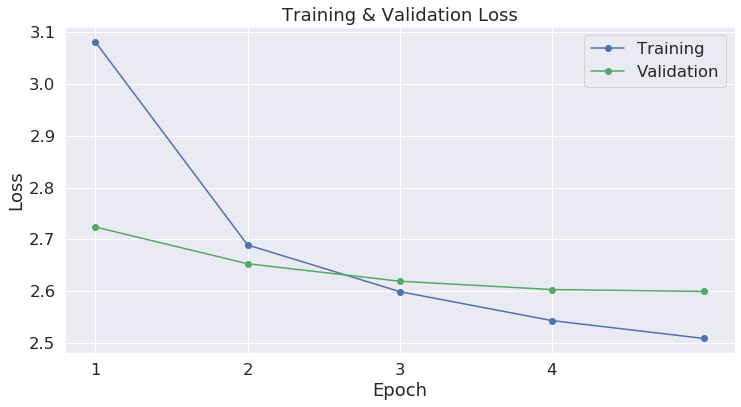

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")

# Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained("/data-disk/rap/model_save")
tokenizer = GPT2Tokenizer.from_pretrained("/data-disk/rap/model_save")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

## Test Dataset

In [ ]:
import math
#========================================
#                  Test
# ========================================

print("")
print("Running Test...")

t0 = time.time()

model.eval()

total_test_loss = 0
nb_test_steps = 0

# Evaluate data for one epoch
for batch in test_dataloader:
    
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
    
    with torch.no_grad():        

        outputs  = model(b_input_ids,  
                          attention_mask = b_masks,
                        labels=b_labels)
      
        loss = outputs[0]  
        
    batch_loss = loss.item()
    total_test_loss += batch_loss        

avg_test_loss = total_test_loss / len(test_dataloader)

ppl = math.exp(avg_test_loss)

test_time = format_time(time.time() - t0)    

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test Perplexity: {0:.2f}".format(ppl))
print("  Test took: {:}".format(test_time))


Running Test...
  Test Loss: 2.55
  Test Perplexity: 12.81
  Test took: 0:03:17


## Inference

In [ ]:
model.eval()

prompt = "<|startoftext|> Generating rap"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,  2980,   803,  4095]], device='cuda:0')
0:  Generating rap lyrics like a beatbox The sounds are just too potent and I make em fly A million different ways that I can get em If you think you can get with me and stop your whole life Cause I can get with you baby I just got started with rap I'm a rapper yeah I was born to do it Rap is my game and I will always stay with it You can't deny my style I got a new goal And I'm about to make it I got a plan And you'll never be a part of my plan If you think that you can get with me and stop your whole life Cause I can get with you baby I just got started with rap My whole life I've got nothing to lose I just got started with rap Like a million years ago I had the chance I didn't take the chance I went and I did some shit that's still in the past A million years ago the sun was shining And everytime we turn into stars You can't deny my style I got a new goal And I'm about to make it I got a plan And you'll never be a part of my pl